# <p style="color:#1BD1E7; font-size:1.5em">**Projeto Aplicado em Ciência de Dados I**</p> 
## <p style="color:#1BD1E7; font-size:1em">**Previsão do número de sets dos torneios de ténis nos Estados Unidos da América**</p> 

---

**Turma:** CDB1

* João Dias - 110305

* Rafael Cerqueira - 110860

* Felipe Pereira - 110861

* Samuel Ricardo - 110884

* David Franco - 110733

**Docentes:** Sérgio Moro / Diana Aldea Mendes

**Data:**  01/06/2024

--- 

**Índice:**
(para aceder diretamente a uma das secções do código)
1. [Business Understanding](##Business-understanding)

2. [Data Understanding](#Data-understanding)

3. [Data Preparation](#Data-preparation)

4. [Modeling and evaluation](#Modeling-and-evaluation)
    
5. [Deployment](#Deployment)

## Business Understanding

**Objetivo:** Previsão do número de sets de um jogo de ténis com base numa base de dados real do ATP para otimização de planos táticos e de treino para preparadores e treinadores de ténis.

**Framework:** Em termos de framework metodológico vamos focar-nos no CRISP-DM, sem grande destaque na fase de deployment, que se encontra sumarizado na imagem abaixo:

<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/b/b9/CRISP-DM_Process_Diagram.png/800px-CRISP-DM_Process_Diagram.png" alt="Drawing" style="width: 400px;"/>

## Data Understanding

### Setup inicial

In [1]:
# import das bibliotecas utilizadas ao longo do projeto
import pandas as pd
from datetime import datetime
import pycountry
import seaborn as sns
import matplotlib.pyplot as plt
import association_metrics as am
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import KNNImputer
import category_encoders as ce
import numpy as np
from scipy.stats import chi2_contingency
from sklearn.preprocessing import MinMaxScaler
from yellowbrick.classifier import ROCAUC
from sklearn import metrics
from sklearn.model_selection import train_test_split
import xgboost as xgb
import collections
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
import warnings
from sklearn.model_selection import RandomizedSearchCV
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import KFold
from imblearn.under_sampling import RandomUnderSampler
import scipy.stats as stats
from sklearn.ensemble import RandomForestClassifier
import random

pd.set_option('display.max_columns', None)
plt.rcParams['figure.figsize'] = [12, 8] 
random.seed(123)

### Importação dos datasets utilizados

In [2]:
# import dos datasets extraídos a partir do json inicial com a base de dados de atp após o pré-processamento em mongodb e mysql
games = pd.read_csv("games_after_sql.csv")
players = pd.read_csv("players_after_sql.csv")
tournaments = pd.read_csv("tournaments_after_sql.csv")

# import de uma BD adicional obtido num repositório aberto de 
atp_players = pd.read_csv("atp_players.csv")

#### Estrutura dos datasets importados

In [3]:
# ver as primeiras observações do dataset de jogos
games.head()

,player_name,link_player,tournament,start_date,end_date,ground,game_round,game_rank,oponent,wl,score,id
0,Novak Djokovic,https://www.atptour.com/en/players/novak-djoko...,ATP Masters 1000 Paris,2021-11-01,2021-11-07,Hard,Semi-Finals,10,Hubert Hurkacz,W,36 60 76,1
1,Novak Djokovic,https://www.atptour.com/en/players/novak-djoko...,ATP Masters 1000 Paris,2021-11-01,2021-11-07,Hard,Finals,2,Daniil Medvedev,W,46 63 63,2
2,Novak Djokovic,https://www.atptour.com/en/players/novak-djoko...,Davis Cup Finals,2021-11-22,2021-12-05,Hard,Round Robin,118,Dennis Novak,W,63 62,3
3,Novak Djokovic,https://www.atptour.com/en/players/novak-djoko...,Dubai,2022-02-21,2022-02-26,Hard,Round of 32,58,Lorenzo Musetti,W,63 63,4
4,Novak Djokovic,https://www.atptour.com/en/players/novak-djoko...,Davis Cup Finals,2021-11-22,2021-12-05,Hard,Quarter-Finals,36,Alexander Bublik,W,63 64,5


In [4]:
# ver as primeiras observações do dataset de torneios
tournaments.head()

,tournament,location,prize,start_date,end_date,country
0,'s-Hertogenbosch,"s-Hertogenbosch, Netherlands",475000,1998-06-15,1998-06-21,Netherlands
1,'s-Hertogenbosch,"s-Hertogenbosch, Netherlands",475000,1999-06-14,1999-06-20,Netherlands
2,'s-Hertogenbosch,"s-Hertogenbosch, Netherlands",375000,2000-06-19,2000-06-25,Netherlands
3,'s-Hertogenbosch,"s-Hertogenbosch, Netherlands",375000,2001-06-18,2001-06-24,Netherlands
4,'s-Hertogenbosch,"s-Hertogenbosch, Netherlands",356000,2002-06-17,2002-06-23,Netherlands


In [5]:
# ver as primeiras observações do dataset de jogadores
players.head()

,player_name,born,height,link_player,backhand,forehand,country
0,A.J. Catanzariti,NaN,0,https://www.atptour.com/en/players/a.j.-catanz...,Unknown Backhand,Unknown Forehand,NaN
1,Aaro Pollanen,NaN,0,https://www.atptour.com/en/players/aaro-pollan...,Unknown Backhand,Unknown Forehand,NaN
2,Aaron Cohen,NaN,0,https://www.atptour.com/en/players/aaron--cohe...,Unknown Backhand,Unknown Forehand,NaN
3,Aaron Addison,"Melbourne, Australia",193,https://www.atptour.com/en/players/aaron-addis...,Two-Handed Backhand,Right-Handed,Australia
4,Aaron Banasik,NaN,0,https://www.atptour.com/en/players/aaron-banas...,Unknown Backhand,Unknown Forehand,NaN


In [6]:
# ver estatísticas descritivas do dataset de jogadores
players.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
player_name,9960,9953,Andreas Weber,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN
born,3684,2238,"Buenos Aires, Argentina",72,NaN,NaN,NaN,NaN,NaN,NaN,NaN
height,9960.0,NaN,NaN,NaN,63.138153,87.535145,0.0,0.0,0.0,180.0,510.0
link_player,9960,9960,https://www.atptour.com/en/players/a.j.-catanz...,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
backhand,9960,3,Unknown Backhand,7347,NaN,NaN,NaN,NaN,NaN,NaN,NaN
forehand,9960,4,Right-Handed,5385,NaN,NaN,NaN,NaN,NaN,NaN,NaN
country,3681,113,United States,463,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
# ver estatísticas descritivas do dataset de torneios
tournaments.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
tournament,22232,5340,M15 Monastir,99,NaN,NaN,NaN,NaN,NaN,NaN,NaN
location,22232,2511,Spain,355,NaN,NaN,NaN,NaN,NaN,NaN,NaN
prize,22232.0,NaN,NaN,NaN,182285.609347,1034313.564993,0.0,10000.0,15000.0,50000.0,33784200.0
start_date,22232,2712,2020-03-02,47,NaN,NaN,NaN,NaN,NaN,NaN,NaN
end_date,22232,2676,0000-00-00,664,NaN,NaN,NaN,NaN,NaN,NaN,NaN
country,22232,139,United States,2446,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
# ver estatísticas descritivas do dataset de jogos
games.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
player_name,683980,9311,Harold Solomon,1744,NaN,NaN,NaN,NaN,NaN,NaN,NaN
link_player,683980,9317,https://www.atptour.com/en/players/harold-solo...,1744,NaN,NaN,NaN,NaN,NaN,NaN,NaN
tournament,683980,5340,Roland Garros,6972,NaN,NaN,NaN,NaN,NaN,NaN,NaN
start_date,683980,2712,2014-06-23,1044,NaN,NaN,NaN,NaN,NaN,NaN,NaN
end_date,683980,2676,0000-00-00,9919,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ground,683980,4,Clay,325147,NaN,NaN,NaN,NaN,NaN,NaN,NaN
game_round,683980,13,Round of 32,291553,NaN,NaN,NaN,NaN,NaN,NaN,NaN
game_rank,683980.0,NaN,NaN,NaN,479.9985,469.522126,0.0,94.0,336.0,748.0,2267.0
oponent,683973,22654,David Ferrer,1217,NaN,NaN,NaN,NaN,NaN,NaN,NaN
wl,683980,2,W,661337,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [9]:
# obter os links dos jogadores que têm o mesmo nome e que foram identificados em mongodb
pd.set_option('display.max_colwidth', 1000)
players[(players["player_name"] == "Alberto Gonzalez") | (players["player_name"] == "Alexey Nesterov") | (players["player_name"] == "Andreas Weber") | (players["player_name"] == "Martin Damm") | (players["player_name"] == "Enrique Pena") | (players["player_name"] == "Mark Kovacs") | (players["player_name"] == "Robert Phillips")]

,player_name,born,height,link_player,backhand,forehand,country
212,Alberto Gonzalez,NaN,0,https://www.atptour.com/en/players/alberto-gonzalez/g419/player-activity?year=all&matchType=Singles,Unknown Backhand,Right-Handed,NaN
213,Alberto Gonzalez,NaN,0,https://www.atptour.com/en/players/alberto-gonzalez/g975/player-activity?year=all&matchType=Singles,Unknown Backhand,Unknown Forehand,NaN
513,Alexey Nesterov,NaN,0,https://www.atptour.com/en/players/alexey-nesterov/n0ax/player-activity?year=all&matchType=Singles,Unknown Backhand,Unknown Forehand,NaN
514,Alexey Nesterov,NaN,0,https://www.atptour.com/en/players/alexey-nesterov/n645/player-activity?year=all&matchType=Singles,Unknown Backhand,Unknown Forehand,NaN
710,Andreas Weber,NaN,0,https://www.atptour.com/en/players/andreas-weber/w237/player-activity?year=all&matchType=Singles,Unknown Backhand,Right-Handed,NaN
711,Andreas Weber,NaN,0,https://www.atptour.com/en/players/andreas-weber/w449/player-activity?year=all&matchType=Singles,Unknown Backhand,Unknown Forehand,NaN
2714,Enrique Pena,NaN,0,https://www.atptour.com/en/players/enrique-pena/p0iz/player-activity?year=all&matchType=Singles,Unknown Backhand,Unknown Forehand,NaN
2715,Enrique Pena,NaN,0,https://www.atptour.com/en/players/enrique-pena/p306/player-activity?year=all&matchType=Singles,Unknown Backhand,Right-Handed,NaN
6038,Mark Kovacs,NaN,0,https://www.atptour.com/en/players/mark-kovacs/k678/player-activity?year=all&matchType=Singles,Unknown Backhand,Unknown Forehand,NaN
6039,Mark Kovacs,NaN,0,https://www.atptour.com/en/players/mark-kovacs/kb22/player-activity?year=all&matchType=Singles,Unknown Backhand,Unknown Forehand,NaN


#### Correção de `player_name` duplicados

In [10]:
# mudar o nome dos jogadores para que se possam utilizar como key com base no seu link, ficando apenas a faltar alterar o nome dos oponentes
players.loc[players['link_player'] == 'https://www.atptour.com/en/players/alberto-gonzalez/g419/player-activity?year=all&matchType=Singles', 'player_name'] = 'Alberto_Gonzalez'
games.loc[games['link_player'] == 'https://www.atptour.com/en/players/alberto-gonzalez/g419/player-activity?year=all&matchType=Singles', 'player_name'] = 'Alberto_Gonzalez'

players.loc[players['link_player'] == 'https://www.atptour.com/en/players/alexey-nesterov/n0ax/player-activity?year=all&matchType=Singles', 'player_name'] = 'Alexey_Nesterov'
games.loc[games['link_player'] == 'https://www.atptour.com/en/players/alexey-nesterov/n0ax/player-activity?year=all&matchType=Singles', 'player_name'] = 'Alexey_Nesterov'

players.loc[players['link_player'] == 'https://www.atptour.com/en/players/andreas-weber/w237/player-activity?year=all&matchType=Singles', 'player_name'] = 'Andreas_Weber'
games.loc[games['link_player'] == 'https://www.atptour.com/en/players/andreas-weber/w237/player-activity?year=all&matchType=Singles', 'player_name'] = 'Andreas_Weber'

players.loc[players['link_player'] == 'https://www.atptour.com/en/players/enrique-pena/p0iz/player-activity?year=all&matchType=Singles', 'player_name'] = 'Enrique_Pena'
games.loc[games['link_player'] == 'https://www.atptour.com/en/players/enrique-pena/p0iz/player-activity?year=all&matchType=Singles', 'player_name'] = 'Enrique_Pena'

players.loc[players['link_player'] == 'https://www.atptour.com/en/players/mark-kovacs/k678/player-activity?year=all&matchType=Singles', 'player_name'] = 'Mark_Kovacs'
games.loc[games['link_player'] == 'https://www.atptour.com/en/players/mark-kovacs/k678/player-activity?year=all&matchType=Singles', 'player_name'] = 'Mark_Kovacs'

players.loc[players['link_player'] == 'https://www.atptour.com/en/players/martin-damm/d214/player-activity?year=all&matchType=Singles', 'player_name'] = 'Martin_Damm'
games.loc[games['link_player'] == 'https://www.atptour.com/en/players/martin-damm/d214/player-activity?year=all&matchType=Singles', 'player_name'] = 'Martin_Damm'

players.loc[players['link_player'] == 'https://www.atptour.com/en/players/robert-phillips/p239/player-activity?year=all&matchType=Singles', 'player_name'] = 'Robert_Phillips'
games.loc[games['link_player'] == 'https://www.atptour.com/en/players/robert-phillips/p239/player-activity?year=all&matchType=Singles', 'player_name'] = 'Robert_Phillips'



#### Incorporação de uma base de dados adicional [do repositório do GitHub de Jeff Sackman](https://github.com/JeffSackmann/tennis_atp/blob/master/atp_players.csv)

In [11]:
# pré-processamento da BD adicional (extraída do repositório do GitHub) para que possamos incorporar a informação das datas de nascimento na nossa tabela de jogadores
atp_players['player_name'] = atp_players['name_first'] + ' ' + atp_players['name_last']
players_with_dob = pd.merge(players, atp_players[['player_name', 'dob', 'ioc']], on='player_name', how='outer')
players_with_dob = players_with_dob.drop_duplicates(subset=['player_name'])
players_with_dob['dob'] = pd.to_datetime(players_with_dob['dob'], format='%Y%m%d', errors='coerce').dt.strftime('%Y-%m-%d')

In [12]:
atp_players.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
player_id,64919.0,NaN,NaN,NaN,141942.574839,34756.973962,100001.0,116245.5,132475.0,148705.5,212817.0
name_first,64034,14310,David,588,NaN,NaN,NaN,NaN,NaN,NaN,NaN
name_last,64871,39681,Smith,167,NaN,NaN,NaN,NaN,NaN,NaN,NaN
hand,64902,4,U,47794,NaN,NaN,NaN,NaN,NaN,NaN,NaN
dob,46446.0,NaN,NaN,NaN,19810882.143866,200712.86903,18340000.0,19760929.0,19850610.5,19930630.0,20080113.0
ioc,64243,226,USA,13087,NaN,NaN,NaN,NaN,NaN,NaN,NaN
height,2819.0,NaN,NaN,NaN,183.748138,6.547397,145.0,180.0,183.0,188.0,211.0
wikidata_id,4894,4825,Q2163514,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN
player_name,64034,63272,Kenzo Ukon,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Data Preparation

### Junção dos datasets games + tournaments

In [13]:
# juntar os dois datasets de jogos + torneios com base nas caracteristicas comuns ['tournament', 'start_date', 'end_date']
df_games_tourns = pd.merge(games, tournaments, on=['tournament', 'start_date', 'end_date'], how="left")

In [14]:
# ver as primeiras observações do novo df criado
df_games_tourns.head()

,player_name,link_player,tournament,start_date,end_date,ground,game_round,game_rank,oponent,wl,score,id,location,prize,country
0,Novak Djokovic,https://www.atptour.com/en/players/novak-djokovic/d643/player-activity?year=all&matchType=Singles,ATP Masters 1000 Paris,2021-11-01,2021-11-07,Hard,Semi-Finals,10,Hubert Hurkacz,W,36 60 76,1,"Paris, France",5207405.0,France
1,Novak Djokovic,https://www.atptour.com/en/players/novak-djokovic/d643/player-activity?year=all&matchType=Singles,ATP Masters 1000 Paris,2021-11-01,2021-11-07,Hard,Finals,2,Daniil Medvedev,W,46 63 63,2,"Paris, France",5207405.0,France
2,Novak Djokovic,https://www.atptour.com/en/players/novak-djokovic/d643/player-activity?year=all&matchType=Singles,Davis Cup Finals,2021-11-22,2021-12-05,Hard,Round Robin,118,Dennis Novak,W,63 62,3,"Madrid, Spain",0.0,Spain
3,Novak Djokovic,https://www.atptour.com/en/players/novak-djokovic/d643/player-activity?year=all&matchType=Singles,Dubai,2022-02-21,2022-02-26,Hard,Round of 32,58,Lorenzo Musetti,W,63 63,4,"Dubai, U.A.E.",2794840.0,United Arab Emirates
4,Novak Djokovic,https://www.atptour.com/en/players/novak-djokovic/d643/player-activity?year=all&matchType=Singles,Davis Cup Finals,2021-11-22,2021-12-05,Hard,Quarter-Finals,36,Alexander Bublik,W,63 64,5,"Madrid, Spain",0.0,Spain


In [15]:
# ver as estatísticas descritivas do novo df criado
df_games_tourns.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
player_name,683980,9317,Harold Solomon,1744,NaN,NaN,NaN,NaN,NaN,NaN,NaN
link_player,683980,9317,https://www.atptour.com/en/players/harold-solomon/s065/player-activity?year=all&matchType=Singles,1744,NaN,NaN,NaN,NaN,NaN,NaN,NaN
tournament,683980,5340,Roland Garros,6972,NaN,NaN,NaN,NaN,NaN,NaN,NaN
start_date,683980,2712,2014-06-23,1044,NaN,NaN,NaN,NaN,NaN,NaN,NaN
end_date,683980,2676,0000-00-00,9919,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ground,683980,4,Clay,325147,NaN,NaN,NaN,NaN,NaN,NaN,NaN
game_round,683980,13,Round of 32,291553,NaN,NaN,NaN,NaN,NaN,NaN,NaN
game_rank,683980.0,NaN,NaN,NaN,479.9985,469.522126,0.0,94.0,336.0,748.0,2267.0
oponent,683973,22654,David Ferrer,1217,NaN,NaN,NaN,NaN,NaN,NaN,NaN
wl,683980,2,W,661337,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [16]:
# renomear colunas para clarificar o que representam as features
df_games_tourns.rename(columns={'country': 'tournament_country', 'location': 'tournament_location'}, inplace=True)

In [17]:
# verificar os missings
df_games_tourns.isna().sum()

player_name             0
link_player             0
tournament              0
start_date              0
end_date                0
ground                  0
game_round              0
game_rank               0
oponent                 7
wl                      0
score                  77
id                      0
tournament_location    31
prize                  31
tournament_country     31
dtype: int64

In [18]:
# filtrar de forma a perceber porque há jogos sem oponentes
df_games_tourns[df_games_tourns['oponent'].isna()]

,player_name,link_player,tournament,start_date,end_date,ground,game_round,game_rank,oponent,wl,score,id,tournament_location,prize,tournament_country
167730,Michael Redlicki,https://www.atptour.com/en/players/michael-redlicki/rc62/player-activity?year=all&matchType=Singles,Houston,2018-11-12,2018-11-18,Hard,1st Round Qualifying,0,NaN,W,62 62,167731,"Houston, TX, United States",150000.0,United States
406145,Ervand Gasparyan,https://www.atptour.com/en/players/ervand-gasparyan/g764/player-activity?year=all&matchType=Singles,Fergana,2011-05-16,2011-05-22,Hard,2nd Round Qualifying,0,NaN,W,60 62,406146,"Fergana, Uzbekistan",35000.0,Uzbekistan
485058,Francisco Rodriguez,https://www.atptour.com/en/players/francisco-rodriguez/r060/player-activity?year=all&matchType=Singles,PAR V JAM AOG2,1998-07-13,1998-07-19,Clay,Round Robin,0,NaN,W,63 61,485059,Paraguay,0.0,Paraguay
560831,Josip Dumanic,https://www.atptour.com/en/players/josip-dumanic/d286/player-activity?year=all&matchType=Singles,Croatia F3,1998-07-06,1998-07-12,Clay,Round of 32,0,NaN,W,64 63,560832,Croatia,10000.0,Croatia
621350,Alexandru Vasile Manole,https://www.atptour.com/en/players/alexandru-vasile-manole/mp84/player-activity?year=all&matchType=Singles,Romania F13,2018-09-10,2018-09-16,Clay,Round of 32,0,NaN,W,62 61,621351,"Iasi, Romania",15000.0,Romania
648377,Felipe Derdoy,https://www.atptour.com/en/players/felipe-derdoy/dg99/player-activity?year=all&matchType=Singles,Chile F1,2018-11-12,2018-11-18,Clay,Round of 32,0,NaN,W,63 46 61,648378,"Vina del Mar, Chile",15000.0,Chile
669301,Azizbek Lukmanov,https://www.atptour.com/en/players/azizbek-lukmanov/lc05/player-activity?year=all&matchType=Singles,Fergana,2011-05-16,2011-05-22,Hard,1st Round Qualifying,0,NaN,L,26 26,669302,"Fergana, Uzbekistan",35000.0,Uzbekistan


In [19]:
# como se tratam de jogos que nao fazem sentido e são poucas observações, optamos por remover estas instâncias
df_games_tourns = df_games_tourns.dropna(subset=['oponent'])

In [20]:
# verificar os missings no score
df_games_tourns[df_games_tourns['score'].isna()]

,player_name,link_player,tournament,start_date,end_date,ground,game_round,game_rank,oponent,wl,score,id,tournament_location,prize,tournament_country
53613,Mikhail Kukushkin,https://www.atptour.com/en/players/mikhail-kukushkin/k926/player-activity?year=all&matchType=Singles,KAZ vs. UZB WG Play-Off,2012-09-10,2012-09-16,Clay,Round Robin,308,Farrukh Dustov,W,NaN,53614,Kazakhstan,0.0,Kazakhstan
67126,Jason Jung,https://www.atptour.com/en/players/jason-jung/j380/player-activity?year=all&matchType=Singles,Sarasota,2013-04-15,2013-04-21,Clay,2nd Round Qualifying,238,Denys Molchanov,W,NaN,67127,"Sarasota, FL, U.S.A.",100000.0,United States
83743,Kaichi Uchida,https://www.atptour.com/en/players/kaichi-uchida/u120/player-activity?year=all&matchType=Singles,M15 Monastir,2021-01-11,2021-01-17,Hard,Round of 16,799,Louis Tessa,W,NaN,83744,"Monastir, Tunisia",15000.0,Tunisia
105925,Filip Peliwo,https://www.atptour.com/en/players/filip-peliwo/pf65/player-activity?year=all&matchType=Singles,M25 Nur-Sultan,2021-10-18,2021-10-24,Hard,Finals,291,Andrey Kuznetsov,W,NaN,105926,"Nur-Sultan, Kazakhstan",25000.0,Kazakhstan
110481,Martin Cuevas,https://www.atptour.com/en/players/martin-cuevas/cc98/player-activity?year=all&matchType=Singles,M25 Antalya,2022-02-21,2022-02-27,Hard,Finals,318,Alexander Shevchenko,W,NaN,110482,"Antalya, Turkey",25000.0,Turkey
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
669871,Stephane Bohli,https://www.atptour.com/en/players/stephane-bohli/b752/player-activity?year=all&matchType=Singles,St. Remy,2013-09-02,2013-09-08,Hard,2nd Round Qualifying,0,Alexandre Buchner,L,NaN,669872,"St. Remy, France",42500.0,France
674249,Ruben Gajardo,https://www.atptour.com/en/players/ruben-gajardo/g165/player-activity?year=all&matchType=Singles,Vina Del Mar,1986-01-27,1986-02-02,Clay,Round of 16,142,Juan Avendano,L,NaN,674250,"Vina Del Mar, Chile",25000.0,Chile
676695,Horacio De La Pena,https://www.atptour.com/en/players/horacio-de-la-pena/d008/player-activity?year=all&matchType=Singles,Guadalajara,1992-11-16,1992-11-22,Clay,Round of 16,300,Agustin Moreno,L,NaN,676696,"Guadalajara, Mexico",100000.0,Mexico
677806,Broderick Dyke,https://www.atptour.com/en/players/broderick-dyke/d049/player-activity?year=all&matchType=Singles,Hilversum,1984-07-23,1984-07-29,Clay,Round of 32,138,Peter Doohan,L,NaN,677807,"Hilversum, Netherlands",75000.0,Netherlands


In [21]:
# remover jogos que não aconteceram
df_games_tourns = df_games_tourns.dropna(subset=['score'])
# ver datas '0000-00-00' / como os torneios efetivamente aconteceram e duram em média 7 dias - imputamos a data 7 dias após a start_date
tournaments_inv_dates = df_games_tourns[(df_games_tourns['end_date'] == '0000-00-00')]
tournaments_inv_dates['tournament'].unique()
# ajustar datatypes
df_games_tourns['start_date'] = pd.to_datetime(df_games_tourns['start_date'])
df_games_tourns.loc[df_games_tourns['end_date'] == '0000-00-00', 'end_date'] = df_games_tourns.loc[df_games_tourns['end_date'] == '0000-00-00', 'start_date'] + pd.Timedelta(days=7)
df_games_tourns['end_date'] = pd.to_datetime(df_games_tourns['end_date'])

### Feature engineering - 1ª fase (todos os torneios)

#### Criação das variáveis `head_to_head_all_tournaments` e `diff_num_games_year_all_tournaments`

In [22]:
## FEATURE ENGINEERING ALL TOURNAMENTS (demora cerca de 1 minuto e 30s a correr o chunk)

# Calcular o número de jogos já disputados entre o jogador e o oponente (head-to-head) até à data do torneio
df_games_tourns['concatenated_sorted'] = df_games_tourns[['player_name', 'oponent']].apply(lambda x: ' - '.join(sorted(x)), axis=1)
# Ordenar o DataFrame pela data do jogo
df_games_tourns = df_games_tourns.sort_values(by='start_date')
# Inicializar um dicionário para armazenar o número de jogos head-to-head para cada par de jogadores
head_to_head_dict = {}
# Iterar sobre cada grupo de jogos (cada par de jogadores)
for _, group in df_games_tourns.groupby('concatenated_sorted'):
    # Calcular o número de jogos head-to-head para este grupo
    head_to_head_count = pd.Series(range(1, len(group) + 1), index=group.index)
    # Atualizar o dicionário com o número de jogos head-to-head para este par de jogadores
    head_to_head_dict.update(head_to_head_count.to_dict())
# Adicionar os números de head-to-head ao DataFrame
df_games_tourns['head_to_head_all_tournaments'] = df_games_tourns.index.map(head_to_head_dict)
# Reordenar o DataFrame pelo índice original
df_games_tourns = df_games_tourns.sort_index()


# Numero de jogos praticados na season anterior 
# Extrair o ano da data de início do jogo
df_games_tourns['start_year'] = df_games_tourns['start_date'].dt.year
# Inicialize um dicionário para armazenar o número total de jogos por ano para cada jogador
player_total_games_year = {}
# Percorra cada linha do DataFrame
for index, row in df_games_tourns.iterrows():
    # Obtenha o ano do jogo
    year = row['start_year']
    # Incrementa o número total de jogos para o jogador principal
    player = row['player_name']
    if (player, year) in player_total_games_year:
        player_total_games_year[(player, year)] += 1
    else:
        player_total_games_year[(player, year)] = 1
    # Incrementa o número total de jogos para o oponente
    opponent = row['oponent']
    if (opponent, year) in player_total_games_year:
        player_total_games_year[(opponent, year)] += 1
    else:
        player_total_games_year[(opponent, year)] = 1
# Adiciona os números totais de jogos como novas colunas no DataFrame
df_games_tourns['player_total_games_year'] = df_games_tourns.apply(lambda row: player_total_games_year.get((row['player_name'], row['start_year'] - 1), 0), axis=1)
df_games_tourns['opponent_total_games_year'] = df_games_tourns.apply(lambda row: player_total_games_year.get((row['oponent'], row['start_year'] - 1), 0), axis=1)
# Diferença em modulo do desgaste da season anterior
df_games_tourns['diff_num_games_year_all_tournaments'] = abs(df_games_tourns['player_total_games_year'] - df_games_tourns['opponent_total_games_year'])

In [23]:
# verificar por exemplo os jogos do Zverev contra o Nadal para garantir que o comportamentos das novas variáveis está correcto 
df_games_tourns[df_games_tourns['concatenated_sorted']=='Alexander Zverev - Rafael Nadal']

,player_name,link_player,tournament,start_date,end_date,ground,game_round,game_rank,oponent,wl,score,id,tournament_location,prize,tournament_country,concatenated_sorted,head_to_head_all_tournaments,start_year,player_total_games_year,opponent_total_games_year,diff_num_games_year_all_tournaments
1474,Rafael Nadal,https://www.atptour.com/en/players/rafael-nadal/n409/player-activity?year=all&matchType=Singles,ATP Masters 1000 Rome,2021-05-10,2021-05-16,Clay,Quarter-Finals,6,Alexander Zverev,W,63 64,1475,"Rome, Italy",2082960.0,Italy,Alexander Zverev - Rafael Nadal,9,2021,28,36,8
1594,Rafael Nadal,https://www.atptour.com/en/players/rafael-nadal/n409/player-activity?year=all&matchType=Singles,ATP Masters 1000 Rome,2018-05-14,2018-05-20,Clay,Finals,3,Alexander Zverev,W,61 16 63,1595,"Rome, Italy",4872105.0,Italy,Alexander Zverev - Rafael Nadal,5,2018,81,79,2
1615,Rafael Nadal,https://www.atptour.com/en/players/rafael-nadal/n409/player-activity?year=all&matchType=Singles,ESP vs. GER WG QF,2018-04-02,2018-04-08,Clay,Round Robin,4,Alexander Zverev,W,61 64 64,1616,"Valencia, Spain",0.0,Spain,Alexander Zverev - Rafael Nadal,4,2018,81,79,2
1669,Rafael Nadal,https://www.atptour.com/en/players/rafael-nadal/n409/player-activity?year=all&matchType=Singles,ATP Masters 1000 Monte Carlo,2017-04-17,2017-04-23,Clay,Round of 16,20,Alexander Zverev,W,61 61,1670,"Monte Carlo, Monaco",4273775.0,Monaco,Alexander Zverev - Rafael Nadal,3,2017,55,68,13
1686,Rafael Nadal,https://www.atptour.com/en/players/rafael-nadal/n409/player-activity?year=all&matchType=Singles,Australian Open,2017-01-16,2017-01-29,Hard,Round of 32,24,Alexander Zverev,W,"46 63 67, 63 62",1687,"Melbourne, Australia",22624000.0,Australia,Alexander Zverev - Rafael Nadal,2,2017,55,68,13
1719,Rafael Nadal,https://www.atptour.com/en/players/rafael-nadal/n409/player-activity?year=all&matchType=Singles,ATP Masters 1000 Indian Wells,2016-03-07,2016-03-20,Hard,Round of 16,58,Alexander Zverev,W,"67, 60 75",1720,"Indian Wells, CA, U.S.A.",6134605.0,United States,Alexander Zverev - Rafael Nadal,1,2016,81,66,15
2631,Alexander Zverev,https://www.atptour.com/en/players/alexander-zverev/z355/player-activity?year=all&matchType=Singles,ATP Masters 1000 Madrid,2021-05-03,2021-05-09,Clay,Quarter-Finals,2,Rafael Nadal,W,64 64,2632,"Madrid, Spain",2614465.0,Spain,Alexander Zverev - Rafael Nadal,8,2021,36,28,8
2649,Alexander Zverev,https://www.atptour.com/en/players/alexander-zverev/z355/player-activity?year=all&matchType=Singles,ATP Masters 1000 Paris,2020-11-02,2020-11-08,Hard,Semi-Finals,2,Rafael Nadal,W,64 75,2650,"Paris, France",3343725.0,France,Alexander Zverev - Rafael Nadal,7,2020,73,76,3
2675,Alexander Zverev,https://www.atptour.com/en/players/alexander-zverev/z355/player-activity?year=all&matchType=Singles,Nitto ATP Finals,2019-11-11,2019-11-17,Hard,Round Robin,1,Rafael Nadal,W,62 64,2676,"London, Great Britain",9000000.0,United Kingdom,Alexander Zverev - Rafael Nadal,6,2019,79,49,30


C:\Users\joaop\AppData\Local\Temp\ipykernel_15956\937327428.py:3: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared.
  df_games_tourns.hist(bins=20, edgecolor="black", ax=ax)


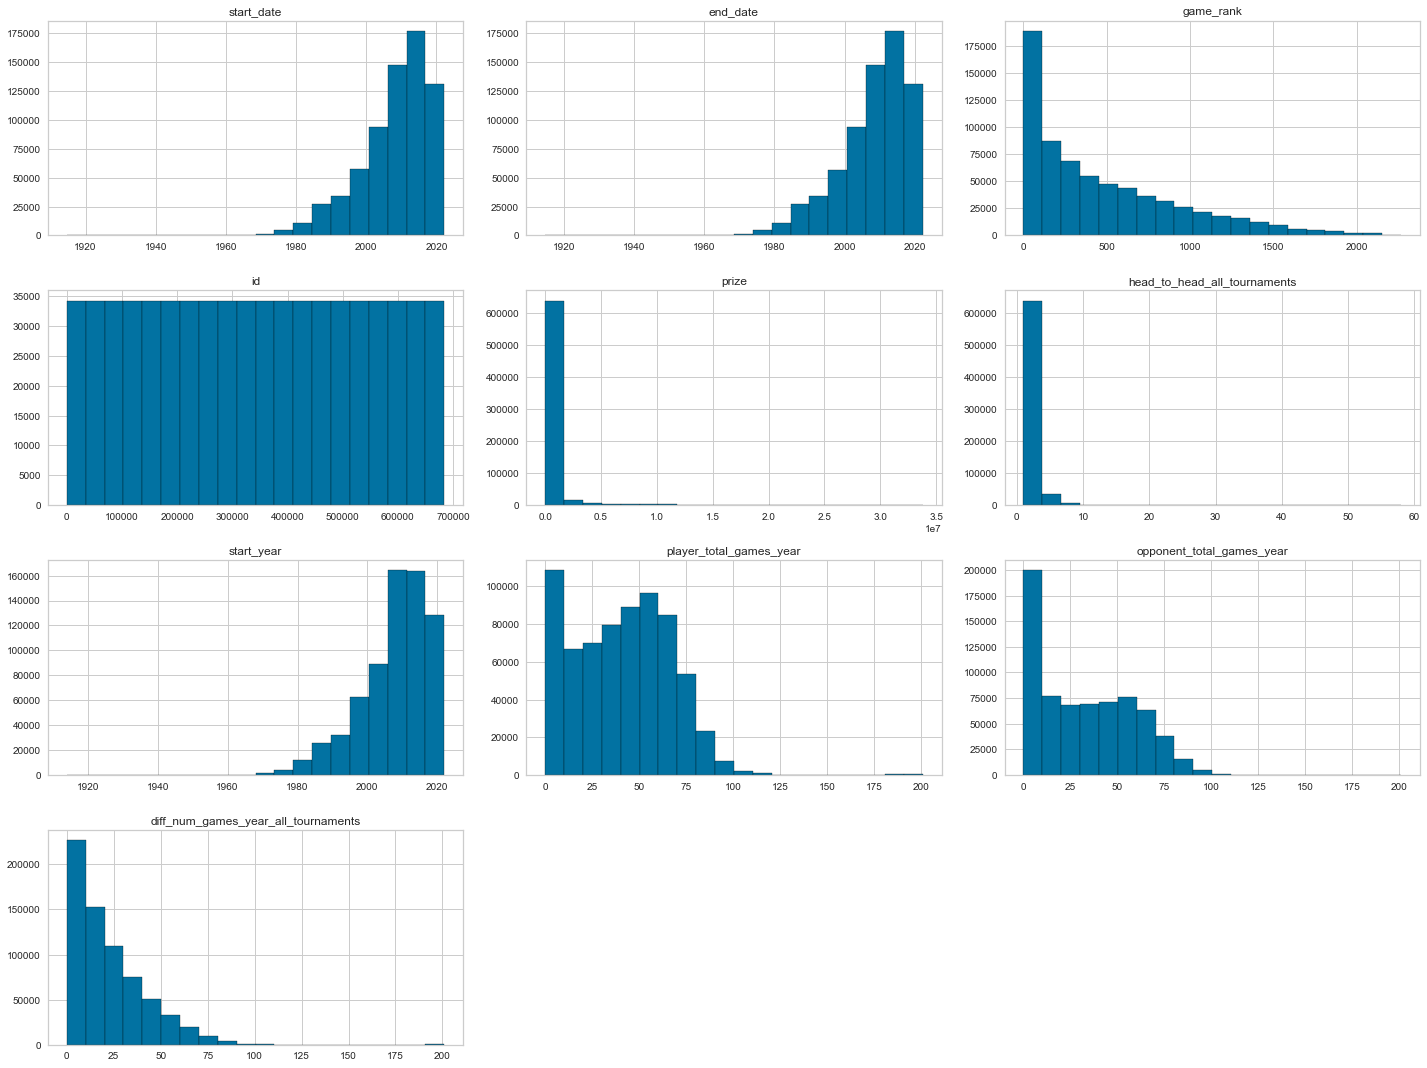

In [24]:
# Histogramas para as variáveis numéricas
fig, ax = plt.subplots(figsize=(20, 15))
df_games_tourns.hist(bins=20, edgecolor="black", ax=ax)
plt.tight_layout()
plt.show()

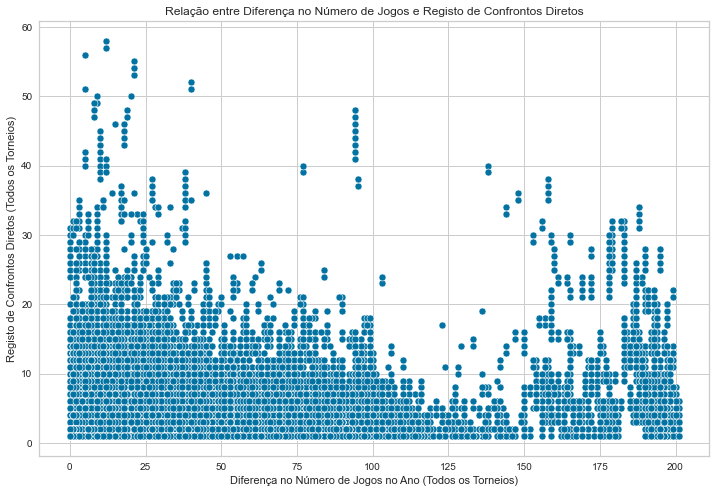

In [25]:
sns.scatterplot(data=df_games_tourns, x='diff_num_games_year_all_tournaments', y='head_to_head_all_tournaments')
plt.title('Relação entre Diferença no Número de Jogos e Registo de Confrontos Diretos')
plt.xlabel('Diferença no Número de Jogos no Ano (Todos os Torneios)')
plt.ylabel('Registo de Confrontos Diretos (Todos os Torneios)')
plt.grid(True)
plt.show()

### Filtragem dos jogos dos EUA

In [26]:
# filtrar apenas os jogos dos estados unidos
df_filtrado = df_games_tourns[df_games_tourns["tournament_country"] == 'United States']

# ver primeiras observações do df_filtrado
df_filtrado.head()

,player_name,link_player,tournament,start_date,end_date,ground,game_round,game_rank,oponent,wl,score,id,tournament_location,prize,tournament_country,concatenated_sorted,head_to_head_all_tournaments,start_year,player_total_games_year,opponent_total_games_year,diff_num_games_year_all_tournaments
6,Novak Djokovic,https://www.atptour.com/en/players/novak-djokovic/d643/player-activity?year=all&matchType=Singles,US Open,2021-08-30,2021-09-12,Hard,Semi-Finals,4,Alexander Zverev,W,46 62 64 46 62,7,"New York, NY, U.S.A.",27200000.0,United States,Alexander Zverev - Novak Djokovic,10,2021,40,36,4
8,Novak Djokovic,https://www.atptour.com/en/players/novak-djokovic/d643/player-activity?year=all&matchType=Singles,US Open,2021-08-30,2021-09-12,Hard,Round of 32,56,Kei Nishikori,W,"67, 63 63 62",9,"New York, NY, U.S.A.",27200000.0,United States,Kei Nishikori - Novak Djokovic,22,2021,40,6,34
9,Novak Djokovic,https://www.atptour.com/en/players/novak-djokovic/d643/player-activity?year=all&matchType=Singles,US Open,2021-08-30,2021-09-12,Hard,Round of 64,121,Tallon Griekspoor,W,62 63 62,10,"New York, NY, U.S.A.",27200000.0,United States,Novak Djokovic - Tallon Griekspoor,1,2021,40,27,13
10,Novak Djokovic,https://www.atptour.com/en/players/novak-djokovic/d643/player-activity?year=all&matchType=Singles,US Open,2021-08-30,2021-09-12,Hard,Round of 128,145,Holger Rune,W,"61 67, 62 61",11,"New York, NY, U.S.A.",27200000.0,United States,Holger Rune - Novak Djokovic,1,2021,40,48,8
15,Novak Djokovic,https://www.atptour.com/en/players/novak-djokovic/d643/player-activity?year=all&matchType=Singles,US Open,2021-08-30,2021-09-12,Hard,Quarter-Finals,8,Matteo Berrettini,W,57 62 62 63,16,"New York, NY, U.S.A.",27200000.0,United States,Matteo Berrettini - Novak Djokovic,4,2021,40,15,25


In [27]:
df_filtrado.describe(include='all').T

C:\Users\joaop\AppData\Local\Temp\ipykernel_15956\3319860543.py:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  df_filtrado.describe(include='all').T
C:\Users\joaop\AppData\Local\Temp\ipykernel_15956\3319860543.py:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  df_filtrado.describe(include='all').T


,count,unique,top,freq,first,last,mean,std,min,25%,50%,75%,max
player_name,85823,3241,Harold Solomon,1046,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
link_player,85823,3241,https://www.atptour.com/en/players/harold-solomon/s065/player-activity?year=all&matchType=Singles,1046,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
tournament,85823,420,US Open,6891,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
start_date,85823,1669,2019-08-26 00:00:00,242,1914-08-24,2022-03-21,NaN,NaN,NaN,NaN,NaN,NaN,NaN
end_date,85823,1663,2019-09-08 00:00:00,291,1914-09-01,2022-04-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ground,85823,4,Hard,65921,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
game_round,85823,13,Round of 32,30685,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
game_rank,85823.0,NaN,NaN,NaN,NaT,NaT,321.625695,383.52611,0.0,55.0,168.0,458.0,2226.0
oponent,85823,5841,Tommy Haas,362,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
wl,85823,2,W,81922,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN


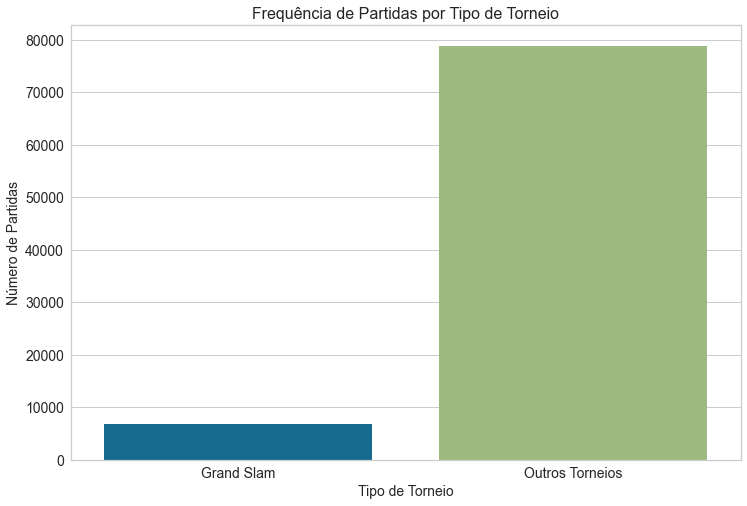

In [28]:
def categorize_tournament(tournament):
    if tournament in {'US Open', 'US Open Preliminary Round'}:
        return 'Grand Slam'
    else:
        return 'Outros Torneios'

# Criar o gráfico de contagem, aplicando a função diretamente no argumento hue
sns.countplot(data=df_filtrado, 
              x=df_filtrado['tournament'].apply(categorize_tournament),
              order=['Grand Slam', 'Outros Torneios'])
plt.title('Frequência de Partidas por Tipo de Torneio', fontsize=16)
plt.xlabel('Tipo de Torneio', fontsize=14)
plt.ylabel('Número de Partidas', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

In [29]:
# nomes de jogadores duplicados quando aparecem como oponentes
df_filtrado[(df_filtrado["oponent"] == "Alberto Gonzalez") | (df_filtrado["oponent"] == "Alexey Nesterov") | (df_filtrado["oponent"] == "Andreas Weber")
      | (df_filtrado["oponent"] == "Enrique Pena") | (df_filtrado["oponent"] == "Mark Kovacs") | (df_filtrado["oponent"] == "Martin Damm") | (df_filtrado["oponent"] == "Robert Phillips")]

,player_name,link_player,tournament,start_date,end_date,ground,game_round,game_rank,oponent,wl,score,id,tournament_location,prize,tournament_country,concatenated_sorted,head_to_head_all_tournaments,start_year,player_total_games_year,opponent_total_games_year,diff_num_games_year_all_tournaments
15575,Jenson Brooksby,https://www.atptour.com/en/players/jenson-brooksby/b0cd/player-activity?year=all&matchType=Singles,Tallahassee,2021-04-19,2021-04-25,Clay,Round of 32,699,Martin Damm,W,"67, 61 62",15576,"Tallahassee, FL, U.S.A.",52080.0,United States,Jenson Brooksby - Martin Damm,1,2021,0,16,16
36403,Tomas Martin Etcheverry,https://www.atptour.com/en/players/tomas-martin-etcheverry/ea24/player-activity?year=all&matchType=Singles,M25 Naples,2019-11-18,2019-11-24,Clay,Finals,0,Martin Damm,W,"76, 75",36404,"Naples, FL, U.S.A.",25000.0,United States,Martin Damm - Tomas Martin Etcheverry,1,2019,56,1,55
40798,Stefan Kozlov,https://www.atptour.com/en/players/stefan-kozlov/ke64/player-activity?year=all&matchType=Singles,Orlando,2020-11-16,2020-11-22,Hard,1st Round Qualifying,868,Martin Damm,W,"64 67, 64",40799,"Orlando, FL, U.S.A.",52080.0,United States,Martin Damm - Stefan Kozlov,1,2020,37,8,29
55152,J.J. Wolf,https://www.atptour.com/en/players/j.j.-wolf/w09g/player-activity?year=all&matchType=Singles,Charlottesville,2021-11-01,2021-11-07,Hard,Round of 32,580,Martin Damm,W,75 64,55153,"Charlottesville, VA, U.S.A.",52080.0,United States,J.J. Wolf - Martin Damm,1,2021,32,16,16
70640,Michael Mmoh,https://www.atptour.com/en/players/michael-mmoh/mp01/player-activity?year=all&matchType=Singles,Orlando,2021-04-12,2021-04-18,Hard,Round of 32,746,Martin Damm,W,64 46 61,70641,"Orlando, FL, U.S.A.",52080.0,United States,Martin Damm - Michael Mmoh,1,2021,23,16,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
636321,Cannon Kingsley,https://www.atptour.com/en/players/cannon-kingsley/k0db/player-activity?year=all&matchType=Singles,M15 Edwardsville,2021-07-19,2021-07-25,Hard,Round of 32,689,Martin Damm,W,63 64,636322,"Edwardsville, IL, U.S.A.",15000.0,United States,Cannon Kingsley - Martin Damm,1,2021,2,16,14
641160,Daniel Dutra da Silva,https://www.atptour.com/en/players/daniel-dutra-da-silva/sg56/player-activity?year=all&matchType=Singles,M25 Naples,2020-02-10,2020-02-16,Clay,Round of 32,917,Martin Damm,W,63 63,641161,"Naples, FL, U.S.A.",25000.0,United States,Daniel Dutra da Silva - Martin Damm,1,2020,41,8,33
645624,Dragos Constantin Ignat,https://www.atptour.com/en/players/dragos-constantin-ignat/i288/player-activity?year=all&matchType=Singles,M25 Orlando,2019-11-11,2019-11-17,Clay,Round of 32,0,Martin Damm,W,46 63 75,645625,"Orlando, FL, U.S.A.",25000.0,United States,Dragos Constantin Ignat - Martin Damm,1,2019,10,1,9
649000,Finn Bass,https://www.atptour.com/en/players/finn-bass/bu78/player-activity?year=all&matchType=Singles,"M15 Fayetteville, AR",2021-09-20,2021-09-26,Hard,Round of 32,679,Martin Damm,W,36 63 75,649001,"Fayetteville, AR, U.S.A.",15000.0,United States,Finn Bass - Martin Damm,1,2021,0,16,16


In [30]:
# Ajustar o nome do Martim Damm (conforme feito inicialmente para o player_name)
df_filtrado.loc[(df_filtrado['oponent'] == 'Martin Damm'), 'oponent'] = 'Martin_Damm'

In [31]:
# acrescentar a informação do dataset com a info dos jogadores 
df_filtrado_j = pd.merge(df_filtrado, players_with_dob, left_on=["player_name"], right_on=["player_name"], how='left')
df_filtrado_j = pd.merge(df_filtrado_j, players_with_dob, left_on="oponent", right_on="player_name", how='left')

In [32]:
# ver como fica o df depois das junções
df_filtrado_j.describe(include='all').T

C:\Users\joaop\AppData\Local\Temp\ipykernel_15956\893595838.py:2: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  df_filtrado_j.describe(include='all').T
C:\Users\joaop\AppData\Local\Temp\ipykernel_15956\893595838.py:2: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  df_filtrado_j.describe(include='all').T


,count,unique,top,freq,first,last,mean,std,min,25%,50%,75%,max
player_name_x,85823,3241,Harold Solomon,1046,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
link_player_x,85823,3241,https://www.atptour.com/en/players/harold-solomon/s065/player-activity?year=all&matchType=Singles,1046,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
tournament,85823,420,US Open,6891,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
start_date,85823,1669,2019-08-26 00:00:00,242,1914-08-24,2022-03-21,NaN,NaN,NaN,NaN,NaN,NaN,NaN
end_date,85823,1663,2019-09-08 00:00:00,291,1914-09-01,2022-04-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ground,85823,4,Hard,65921,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
game_round,85823,13,Round of 32,30685,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
game_rank,85823.0,NaN,NaN,NaN,NaT,NaT,321.625695,383.52611,0.0,55.0,168.0,458.0,2226.0
oponent,85823,5841,Tommy Haas,362,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
wl,85823,2,W,81922,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [33]:
df_filtrado_j.columns

Index(['player_name_x', 'link_player_x', 'tournament', 'start_date',
       'end_date', 'ground', 'game_round', 'game_rank', 'oponent', 'wl',
       'score', 'id', 'tournament_location', 'prize', 'tournament_country',
       'concatenated_sorted', 'head_to_head_all_tournaments', 'start_year',
       'player_total_games_year', 'opponent_total_games_year',
       'diff_num_games_year_all_tournaments', 'born_x', 'height_x',
       'link_player_y', 'backhand_x', 'forehand_x', 'country_x', 'dob_x',
       'ioc_x', 'player_name_y', 'born_y', 'height_y', 'link_player',
       'backhand_y', 'forehand_y', 'country_y', 'dob_y', 'ioc_y'],
      dtype='object')

In [34]:
# ajustar o nome das variáveis para que fique mais claro
df_filtrado_j.rename(columns={'player_name_x': 'player_name', 
                              'backhand_x': 'player_name_backhand', 
                              'forehand_x': 'player_name_forehand', 
                              'country_x': 'player_name_country',
                              'height_x': 'player_name_height',
                              'backhand_y': 'oponent_backhand', 
                              'forehand_y': 'oponent_forehand', 
                              'country_y': 'oponent_country',
                              'height_y': 'oponent_height',
                              'dob_x': 'player_name_dob',
                              'dob_y': 'oponent_dob',
                              'ioc_x': 'player_name_ioc',
                              'ioc_y': 'oponent_ioc'}, inplace=True)

In [35]:
# eliminar variáveis que são redundantes ou que não iremos utilizar
df_filtrado_j.drop(columns=[
    'link_player_x', 'link_player_y', 'link_player', 'born_x', 'born_y', 'player_name_y', 'wl' 
], inplace=True)

### Tratamento de outliers (variáveis baseline: `prize`, `game_rank`, `oponent_height` e `player_name_height`)

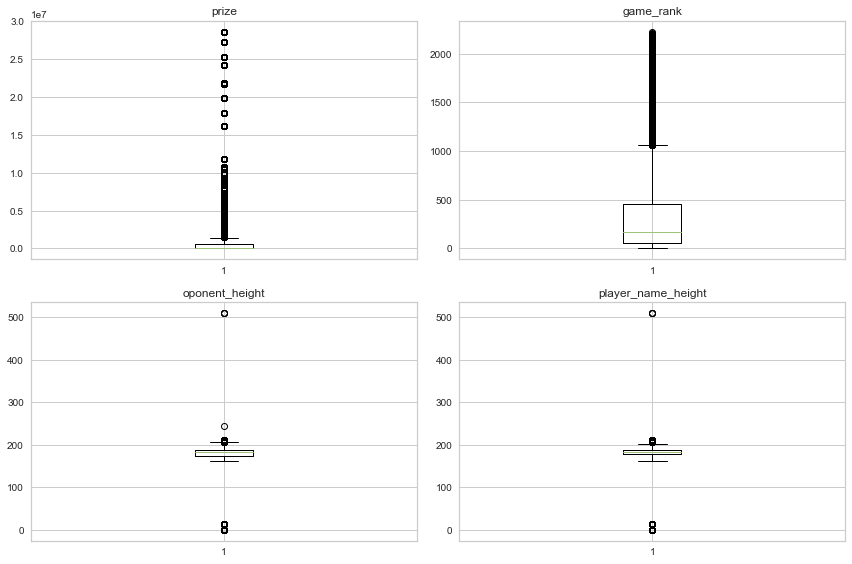

In [36]:
# Lista de variáveis numéricas
numerical_vars = ['prize', 'game_rank', 'oponent_height', 'player_name_height']

# Configurar o tamanho da figura
plt.figure(figsize=(12, 8))

# Criar um subplot para cada variável
for i, var in enumerate(numerical_vars, 1):
    plt.subplot(2, 2, i)  # 2 linhas, 2 colunas, índice i
    plt.boxplot(df_filtrado_j[var].dropna())
    plt.title(var)

plt.tight_layout()
plt.show()

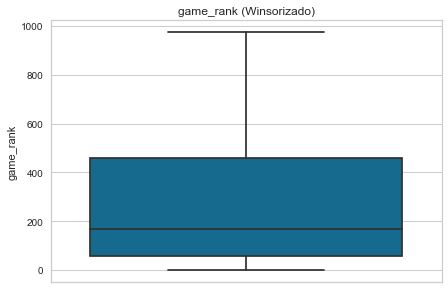

In [37]:
# Lista de variáveis numéricas
numerical_vars = ['game_rank']

# Aplicar winsorização
for var in numerical_vars:
    df_filtrado_j[var] = stats.mstats.winsorize(df_filtrado_j[var], limits=[0, 0.08])

# Configurar o tamanho da figura
plt.figure(figsize=(12, 8))

# Criar um subplot para cada variável após winsorização
for i, var in enumerate(numerical_vars, 1):
    plt.subplot(2, 2, i)  # 2 linhas, 2 colunas, índice i
    sns.boxplot(y=df_filtrado_j[var])
    plt.title(f'{var} (Winsorizado)')

plt.tight_layout()
plt.show()

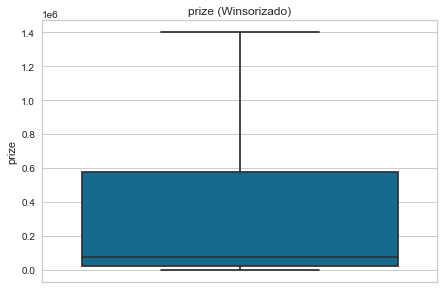

In [38]:
# Lista de variáveis numéricas
numerical_vars = ['prize']

# Aplicar winsorização
for var in numerical_vars:
    df_filtrado_j[var] = stats.mstats.winsorize(df_filtrado_j[var], limits=[0, 0.17])

# Configurar o tamanho da figura
plt.figure(figsize=(12, 8))

# Criar um subplot para cada variável após winsorização
for i, var in enumerate(numerical_vars, 1):
    plt.subplot(2, 2, i)  # 2 linhas, 2 colunas, índice i
    sns.boxplot(y=df_filtrado_j[var])
    plt.title(f'{var} (Winsorizado)')

plt.tight_layout()
plt.show()

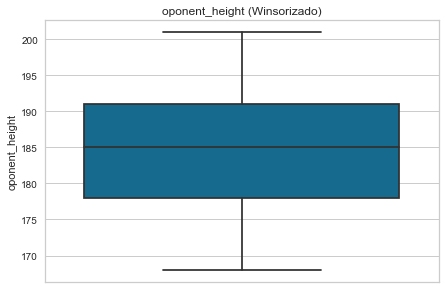

In [39]:
# Lista de variáveis numéricas
numerical_vars = ['oponent_height']

# Aplicar winsorização
for var in numerical_vars:
    df_filtrado_j[var] = stats.mstats.winsorize(df_filtrado_j[var], limits=[0.15, 0.15])

# Configurar o tamanho da figura
plt.figure(figsize=(12, 8))

# Criar um subplot para cada variável após winsorização
for i, var in enumerate(numerical_vars, 1):
    plt.subplot(2, 2, i)  # 2 linhas, 2 colunas, índice i
    sns.boxplot(y=df_filtrado_j[var])
    plt.title(f'{var} (Winsorizado)')

plt.tight_layout()
plt.show()

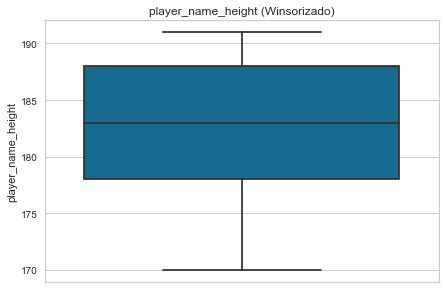

In [40]:
# Lista de variáveis numéricas
numerical_vars = ['player_name_height']

# Aplicar winsorização
for var in numerical_vars:
    df_filtrado_j[var] = stats.mstats.winsorize(df_filtrado_j[var], limits=[0.13, 0.13])

# Configurar o tamanho da figura
plt.figure(figsize=(12, 8))

# Criar um subplot para cada variável após winsorização
for i, var in enumerate(numerical_vars, 1):
    plt.subplot(2, 2, i)  # 2 linhas, 2 colunas, índice i
    sns.boxplot(y=df_filtrado_j[var])
    plt.title(f'{var} (Winsorizado)')

plt.tight_layout()
plt.show()

In [41]:
df_filtrado_j.describe(include='all').T

C:\Users\joaop\AppData\Local\Temp\ipykernel_15956\2940709602.py:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  df_filtrado_j.describe(include='all').T
C:\Users\joaop\AppData\Local\Temp\ipykernel_15956\2940709602.py:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  df_filtrado_j.describe(include='all').T
c:\Users\joaop\anaconda3\lib\site-packages\numpy\lib\function_base.py:4650: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  arr.partition(
c:\Users\joaop\anaconda3\lib\site-packages\numpy\lib\function_base.py:4650: UserWarning: Warning: 'partition' will ign

,count,unique,top,freq,first,last,mean,std,min,25%,50%,75%,max
player_name,85823,3241,Harold Solomon,1046,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
tournament,85823,420,US Open,6891,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
start_date,85823,1669,2019-08-26 00:00:00,242,1914-08-24,2022-03-21,NaN,NaN,NaN,NaN,NaN,NaN,NaN
end_date,85823,1663,2019-09-08 00:00:00,291,1914-09-01,2022-04-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ground,85823,4,Hard,65921,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
game_round,85823,13,Round of 32,30685,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
game_rank,85823.0,NaN,NaN,NaN,NaT,NaT,293.952693,308.073802,0.0,55.0,168.0,458.0,975.0
oponent,85823,5841,Tommy Haas,362,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
score,85823,5463,64 64,3050,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
id,85823.0,NaN,NaN,NaN,NaT,NaT,365187.574741,205830.027859,7.0,181398.5,395338.0,546470.5,683920.0


### Missings (Data Enrichment)

In [42]:
df_filtrado_j.describe(include='all').T

C:\Users\joaop\AppData\Local\Temp\ipykernel_15956\2940709602.py:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  df_filtrado_j.describe(include='all').T
C:\Users\joaop\AppData\Local\Temp\ipykernel_15956\2940709602.py:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  df_filtrado_j.describe(include='all').T
c:\Users\joaop\anaconda3\lib\site-packages\numpy\lib\function_base.py:4650: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  arr.partition(
c:\Users\joaop\anaconda3\lib\site-packages\numpy\lib\function_base.py:4650: UserWarning: Warning: 'partition' will ign

,count,unique,top,freq,first,last,mean,std,min,25%,50%,75%,max
player_name,85823,3241,Harold Solomon,1046,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
tournament,85823,420,US Open,6891,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
start_date,85823,1669,2019-08-26 00:00:00,242,1914-08-24,2022-03-21,NaN,NaN,NaN,NaN,NaN,NaN,NaN
end_date,85823,1663,2019-09-08 00:00:00,291,1914-09-01,2022-04-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ground,85823,4,Hard,65921,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
game_round,85823,13,Round of 32,30685,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
game_rank,85823.0,NaN,NaN,NaN,NaT,NaT,293.952693,308.073802,0.0,55.0,168.0,458.0,975.0
oponent,85823,5841,Tommy Haas,362,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
score,85823,5463,64 64,3050,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
id,85823.0,NaN,NaN,NaN,NaT,NaT,365187.574741,205830.027859,7.0,181398.5,395338.0,546470.5,683920.0


In [43]:
df_filtrado_j.isna().sum()

player_name                                0
tournament                                 0
start_date                                 0
end_date                                   0
ground                                     0
game_round                                 0
game_rank                                  0
oponent                                    0
score                                      0
id                                         0
tournament_location                        0
prize                                      0
tournament_country                         0
concatenated_sorted                        0
head_to_head_all_tournaments               0
start_year                                 0
player_total_games_year                    0
opponent_total_games_year                  0
diff_num_games_year_all_tournaments        0
player_name_height                         0
player_name_backhand                       0
player_name_forehand                       0
player_nam

In [44]:
# verificar os países (há NaNs)
df_filtrado_j['player_name_ioc'].unique()

array(['SRB', 'RUS', 'ESP', 'GER', 'GRE', 'ITA', 'NOR', nan, 'POL', 'GBR',
       'USA', 'CAN', 'ARG', 'GEO', 'CRO', 'FRA', 'SUI', 'BUL', 'CHI',
       'KAZ', 'BLR', 'RSA', 'AUT', 'JPN', 'HUN', 'NED', 'AUS', 'BEL',
       'FIN', 'CZE', 'POR', 'SWE', 'LTU', 'BOL', 'URU', 'SVK', 'BRA',
       'MDA', 'COL', 'PER', 'MEX', 'BIH', 'SLO', 'ECU', 'IND', 'TUR',
       'TPE', 'UKR', 'ROU', 'UZB', 'CHN', 'DOM', 'DEN', 'LAT', 'ISR',
       'TUN', 'KOR', 'EGY', 'BAR', 'MON', 'CYP', 'LBN', 'VIE', 'IRL',
       'ESA', 'MNE', 'BAH', 'EST', 'ALG', 'ZIM', 'MKD', 'NZL', 'COD',
       'SMR', 'JOR', 'LUX', 'JAM', 'INA', 'HAI', 'PHI', 'VEN', 'SRI',
       'PAK', 'PUR', 'MAR', 'THA', 'CUB', 'LIB', 'SLE', 'CIV', 'TRI',
       'PAR', 'KUW', 'ARM', 'NGR', 'CRC', 'ISL', 'AZE', 'SEN', 'YUG',
       'KEN', 'GHA', 'BDI', 'NAM'], dtype=object)

In [45]:
# como o país da nova BD extraída estava no formato ioc, criámos uma função para aplicar depois ao df de jogadores e passar de ioc para iso, mantendo a nomenclatura dos países uniforme
def ioc_to_iso(ioc_code):
    '''converte código ioc em iso'''
    if pd.isnull(ioc_code):  # Check if ioc_code is NaN
        return None
    try:
        country = pycountry.countries.get(alpha_3=ioc_code)
        if country:
            return country.alpha_2
        else:
            return None
    except AttributeError:
        return None

In [46]:
### TRATAR DOS MISSINGS DOS PAISES COM INFORMAÇÃO OBTIDA DA BD ADICIONAL
# passar de ioc para iso e depois uniformizar com base na tabela de paises
df_filtrado_j['player_name_ioc'] = df_filtrado_j['player_name_ioc'].apply(ioc_to_iso)
df_filtrado_j['oponent_ioc'] = df_filtrado_j['oponent_ioc'].apply(ioc_to_iso)

# ler bd de paises que foi utilizada em mysql
df_countries = pd.read_csv("countries.csv")

# Criar um dicionário de mapeamento de códigos ISO para nomes de países
iso_to_country = df_countries.set_index('Code')['Name'].to_dict()
# Aplicar o mapeamento ao DataFrame df_data
df_filtrado_j['player_name_country_v2'] = df_filtrado_j['player_name_ioc'].map(iso_to_country)
df_filtrado_j['oponent_country_v2'] = df_filtrado_j['oponent_ioc'].map(iso_to_country)

# preencher os nulos de country com os dados das colunas auxiliares que foram feitas 
df_filtrado_j['player_name_country'] = df_filtrado_j['player_name_country'].fillna(df_filtrado_j['player_name_country_v2'])
df_filtrado_j['oponent_country'] = df_filtrado_j['oponent_country'].fillna(df_filtrado_j['oponent_country_v2'])

# drop das colunas que foram utilizadas para esta limpeza
df_filtrado_j = df_filtrado_j.drop(columns=['player_name_country_v2', 'oponent_country_v2', 'player_name_ioc', 'oponent_ioc'])


### TRATAR MISSINGS DE HAND
df_filtrado_j['oponent_forehand'] = df_filtrado_j['oponent_forehand'].fillna('Unknown Forehand')
df_filtrado_j['oponent_backhand'] = df_filtrado_j['oponent_backhand'].fillna('Unknown Backhand')

In [47]:
df_filtrado_j.isna().sum()

player_name                               0
tournament                                0
start_date                                0
end_date                                  0
ground                                    0
game_round                                0
game_rank                                 0
oponent                                   0
score                                     0
id                                        0
tournament_location                       0
prize                                     0
tournament_country                        0
concatenated_sorted                       0
head_to_head_all_tournaments              0
start_year                                0
player_total_games_year                   0
opponent_total_games_year                 0
diff_num_games_year_all_tournaments       0
player_name_height                        0
player_name_backhand                      0
player_name_forehand                      0
player_name_country             

In [48]:
df_filtrado_j.describe(include='all').T

C:\Users\joaop\AppData\Local\Temp\ipykernel_15956\2940709602.py:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  df_filtrado_j.describe(include='all').T
C:\Users\joaop\AppData\Local\Temp\ipykernel_15956\2940709602.py:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  df_filtrado_j.describe(include='all').T


,count,unique,top,freq,first,last,mean,std,min,25%,50%,75%,max
player_name,85823,3241,Harold Solomon,1046,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
tournament,85823,420,US Open,6891,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
start_date,85823,1669,2019-08-26 00:00:00,242,1914-08-24,2022-03-21,NaN,NaN,NaN,NaN,NaN,NaN,NaN
end_date,85823,1663,2019-09-08 00:00:00,291,1914-09-01,2022-04-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ground,85823,4,Hard,65921,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
game_round,85823,13,Round of 32,30685,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
game_rank,85823.0,NaN,NaN,NaN,NaT,NaT,293.952693,308.073802,0.0,55.0,168.0,458.0,975.0
oponent,85823,5841,Tommy Haas,362,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
score,85823,5463,64 64,3050,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
id,85823.0,NaN,NaN,NaN,NaT,NaT,365187.574741,205830.027859,7.0,181398.5,395338.0,546470.5,683920.0


### Missings (imputação com KNN)

In [49]:
### apesar dos esforços em tentar obter o máximo de informação para preencher os missings, continuam a existir e para os restantes vamos fazer o tratamento com KNN (demora 2min a correr)
# copia do df original
df = df_filtrado_j.copy()

# Converter colunas de datas para datetime
df['oponent_dob'] = pd.to_datetime(df['oponent_dob'], errors='coerce')
df['player_name_dob'] = pd.to_datetime(df['player_name_dob'], errors='coerce')

# Definir uma data de referência abaixo da data min vista acima
reference_date = pd.Timestamp('1900-01-01')

# Converter datas para dias desde a data de referência
df['oponent_dob_days'] = (df['oponent_dob'] - reference_date).dt.days
df['player_name_dob_days'] = (df['player_name_dob'] - reference_date).dt.days

# Codificar variáveis categóricas
label_encoders = {}
for column in ['player_name_country', 'oponent_country']:
    le = LabelEncoder()
    df[column] = le.fit_transform(df[column].astype(str))
    label_encoders[column] = le

# Definir as colunas que serão imputadas
columns_to_impute = [
    'player_name_country',
    'player_name_dob_days',
    'oponent_height',
    'oponent_country',
    'oponent_dob_days'
]

# Selecionar apenas as colunas a serem imputadas
df_to_impute = df[columns_to_impute]

# Aplicar KNN Imputer
knn_imputer = KNNImputer(n_neighbors=5)
imputed_data = knn_imputer.fit_transform(df_to_impute)

# Converter o resultado de volta para um DataFrame
df_imputed = pd.DataFrame(imputed_data, columns=columns_to_impute)

# Converter os dias de volta para datas
df_imputed['oponent_dob'] = reference_date + pd.to_timedelta(df_imputed['oponent_dob_days'], unit='D')
df_imputed['player_name_dob'] = reference_date + pd.to_timedelta(df_imputed['player_name_dob_days'], unit='D')

# Decodificar as variáveis categóricas de volta para seus valores originais
for column in ['player_name_country', 'oponent_country']:
    le = label_encoders[column]
    df_imputed[column] = le.inverse_transform(df_imputed[column].astype(int))

# Atualizar o DataFrame original com os dados imputados
df.update(df_imputed)

# Remover colunas temporárias de dias
df.drop(columns=['oponent_dob_days', 'player_name_dob_days'], inplace=True)

# Passar as transformações para o df 
df_filtrado_j = df

In [50]:
# ver estatísticas descritivas após a imputação com KNN
df_filtrado_j.describe(include='all').T

C:\Users\joaop\AppData\Local\Temp\ipykernel_15956\1328022554.py:2: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  df_filtrado_j.describe(include='all').T
C:\Users\joaop\AppData\Local\Temp\ipykernel_15956\1328022554.py:2: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  df_filtrado_j.describe(include='all').T
C:\Users\joaop\AppData\Local\Temp\ipykernel_15956\1328022554.py:2: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt

,count,unique,top,freq,first,last,mean,std,min,25%,50%,75%,max
player_name,85823,3241,Harold Solomon,1046,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
tournament,85823,420,US Open,6891,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
start_date,85823,1669,2019-08-26 00:00:00,242,1914-08-24,2022-03-21,NaN,NaN,NaN,NaN,NaN,NaN,NaN
end_date,85823,1663,2019-09-08 00:00:00,291,1914-09-01,2022-04-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ground,85823,4,Hard,65921,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
game_round,85823,13,Round of 32,30685,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
game_rank,85823.0,NaN,NaN,NaN,NaT,NaT,293.952693,308.073802,0.0,55.0,168.0,458.0,975.0
oponent,85823,5841,Tommy Haas,362,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
score,85823,5463,64 64,3050,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
id,85823.0,NaN,NaN,NaN,NaT,NaT,365187.574741,205830.027859,7.0,181398.5,395338.0,546470.5,683920.0


In [51]:
df_filtrado_j.isna().sum()

player_name                            0
tournament                             0
start_date                             0
end_date                               0
ground                                 0
game_round                             0
game_rank                              0
oponent                                0
score                                  0
id                                     0
tournament_location                    0
prize                                  0
tournament_country                     0
concatenated_sorted                    0
head_to_head_all_tournaments           0
start_year                             0
player_total_games_year                0
opponent_total_games_year              0
diff_num_games_year_all_tournaments    0
player_name_height                     0
player_name_backhand                   0
player_name_forehand                   0
player_name_country                    0
player_name_dob                        0
oponent_height  

In [52]:
df_filtrado_j.head(10)

,player_name,tournament,start_date,end_date,ground,game_round,game_rank,oponent,score,id,tournament_location,prize,tournament_country,concatenated_sorted,head_to_head_all_tournaments,start_year,player_total_games_year,opponent_total_games_year,diff_num_games_year_all_tournaments,player_name_height,player_name_backhand,player_name_forehand,player_name_country,player_name_dob,oponent_height,oponent_backhand,oponent_forehand,oponent_country,oponent_dob
0,Novak Djokovic,US Open,2021-08-30,2021-09-12,Hard,Semi-Finals,4,Alexander Zverev,46 62 64 46 62,7,"New York, NY, U.S.A.",1400000.0,United States,Alexander Zverev - Novak Djokovic,10,2021,40,36,4,188.0,Two-Handed Backhand,Right-Handed,Serbia,1987-05-22,198.0,Two-Handed Backhand,Right-Handed,Germany,1997-04-20
1,Novak Djokovic,US Open,2021-08-30,2021-09-12,Hard,Round of 32,56,Kei Nishikori,"67, 63 63 62",9,"New York, NY, U.S.A.",1400000.0,United States,Kei Nishikori - Novak Djokovic,22,2021,40,6,34,188.0,Two-Handed Backhand,Right-Handed,Serbia,1987-05-22,178.0,Two-Handed Backhand,Right-Handed,Japan,1989-12-29
2,Novak Djokovic,US Open,2021-08-30,2021-09-12,Hard,Round of 64,121,Tallon Griekspoor,62 63 62,10,"New York, NY, U.S.A.",1400000.0,United States,Novak Djokovic - Tallon Griekspoor,1,2021,40,27,13,188.0,Two-Handed Backhand,Right-Handed,Serbia,1987-05-22,188.0,Two-Handed Backhand,Right-Handed,Netherlands,1996-07-02
3,Novak Djokovic,US Open,2021-08-30,2021-09-12,Hard,Round of 128,145,Holger Rune,"61 67, 62 61",11,"New York, NY, U.S.A.",1400000.0,United States,Holger Rune - Novak Djokovic,1,2021,40,48,8,188.0,Two-Handed Backhand,Right-Handed,Serbia,1987-05-22,188.0,Two-Handed Backhand,Right-Handed,Denmark,2003-04-29
4,Novak Djokovic,US Open,2021-08-30,2021-09-12,Hard,Quarter-Finals,8,Matteo Berrettini,57 62 62 63,16,"New York, NY, U.S.A.",1400000.0,United States,Matteo Berrettini - Novak Djokovic,4,2021,40,15,25,188.0,Two-Handed Backhand,Right-Handed,Serbia,1987-05-22,196.0,Two-Handed Backhand,Right-Handed,Italy,1996-04-12
5,Novak Djokovic,US Open,2021-08-30,2021-09-12,Hard,Round of 16,99,Jenson Brooksby,16 63 62 62,18,"New York, NY, U.S.A.",1400000.0,United States,Jenson Brooksby - Novak Djokovic,1,2021,40,0,40,188.0,Two-Handed Backhand,Right-Handed,Serbia,1987-05-22,193.0,Two-Handed Backhand,Right-Handed,United States,2000-10-26
6,Novak Djokovic,ATP Masters 1000 Cincinnati,2020-08-24,2020-08-29,Hard,Semi-Finals,12,Roberto Bautista Agut,46 64 76,74,"New York, NY, U.S.A.",1400000.0,United States,Novak Djokovic - Roberto Bautista Agut,12,2020,71,66,5,188.0,Two-Handed Backhand,Right-Handed,Serbia,1987-05-22,183.0,Two-Handed Backhand,Right-Handed,Spain,1988-04-14
7,Novak Djokovic,US Open,2020-08-31,2020-09-13,Hard,Round of 64,44,Kyle Edmund,"67, 63 64 62",75,"New York, NY, U.S.A.",1400000.0,United States,Kyle Edmund - Novak Djokovic,7,2020,71,44,27,188.0,Two-Handed Backhand,Right-Handed,Serbia,1987-05-22,188.0,Two-Handed Backhand,Right-Handed,South Africa,1995-01-08
8,Novak Djokovic,ATP Masters 1000 Cincinnati,2020-08-24,2020-08-29,Hard,Round of 16,55,Tennys Sandgren,62 64,76,"New York, NY, U.S.A.",1400000.0,United States,Novak Djokovic - Tennys Sandgren,3,2020,71,53,18,188.0,Two-Handed Backhand,Right-Handed,Serbia,1987-05-22,188.0,Two-Handed Backhand,Right-Handed,United States,1991-07-22
9,Novak Djokovic,ATP Masters 1000 Cincinnati,2020-08-24,2020-08-29,Hard,Quarter-Finals,34,Jan-Lennard Struff,63 61,77,"New York, NY, U.S.A.",1400000.0,United States,Jan-Lennard Struff - Novak Djokovic,4,2020,71,67,4,188.0,Two-Handed Backhand,Right-Handed,Serbia,1987-05-22,193.0,Two-Handed Backhand,Right-Handed,Germany,1987-04-25


### Feature engineering - 2ª fase (apenas torneios dos EUA)

#### Criação das variáveis `number_of_sets`, `tournament_duration`, `player_name_age`, `age_difference`, `height_difference`, `total_home_advantage_players`, `forehand_comp`, `backhand_comp`

In [53]:
# feature engineering (só aplicado aos torneios dos estados unidos)
# calcular o número de sets
df_filtrado_j['number_of_sets'] = df_filtrado_j['score'].apply(lambda x: len(x.split()))


# Calcular a duração dos torneios
df_filtrado_j['tournament_duration'] = (df_filtrado_j['end_date'] - df_filtrado_j['start_date']).dt.days


# Calcular a idade dos jogadores
df_filtrado_j['player_name_age'] = (df_filtrado_j['start_date'] - pd.to_datetime(df_filtrado_j['player_name_dob'])).dt.days // 365
df_filtrado_j['oponent_age'] = (df_filtrado_j['start_date'] - pd.to_datetime(df_filtrado_j['oponent_dob'])).dt.days // 365


# Calcular a diferença de idade entre o jogador e o oponente (em modulo)
df_filtrado_j['age_difference'] = abs(df_filtrado_j['player_name_age'] - df_filtrado_j['oponent_age'])


# Adicionar uma variável para indicar a diferença de altura entre o jogador e o oponente (em modulo)
df_filtrado_j['height_difference'] = abs(df_filtrado_j['player_name_height'] - df_filtrado_j['oponent_height'])


# variável que indica se o jogador joga em "casa" (baseado no país do torneio)
df_filtrado_j['player_name_home_advantage'] = (df_filtrado_j['player_name_country'] == df_filtrado_j['tournament_country'])
df_filtrado_j['oponent_home_advantage'] = (df_filtrado_j['oponent_country'] == df_filtrado_j['tournament_country'])
# Criar uma nova variável com o número total de jogadores com home court advantage
df_filtrado_j['total_home_advantage_players'] = df_filtrado_j['player_name_home_advantage'].astype(int) + df_filtrado_j['oponent_home_advantage'].astype(int)


# Criar comparações entre a forehand e a backhand
df_filtrado_j['forehand_comp'] = (df_filtrado_j['player_name_forehand'] == df_filtrado_j['oponent_forehand']).astype(int)
df_filtrado_j['backhand_comp'] = (df_filtrado_j['player_name_backhand'] == df_filtrado_j['oponent_backhand']).astype(int)


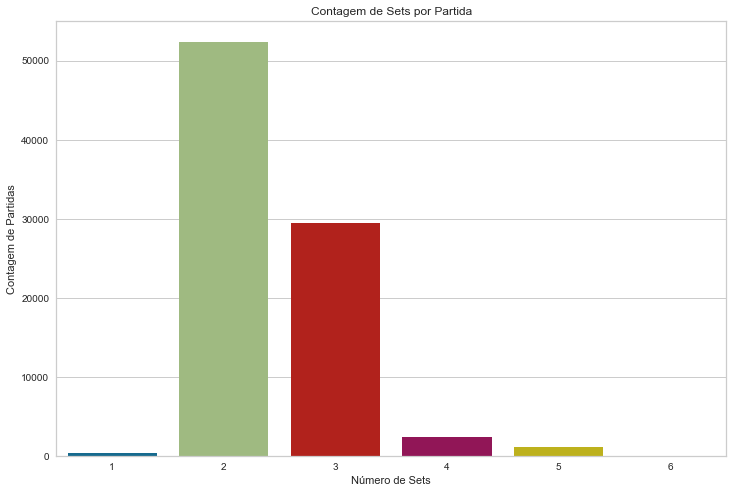

In [54]:
# Contagem de sets por partida
sns.countplot(data=df_filtrado_j, x='number_of_sets')
plt.title('Contagem de Sets por Partida')
plt.xlabel('Número de Sets')
plt.ylabel('Contagem de Partidas')
plt.show()

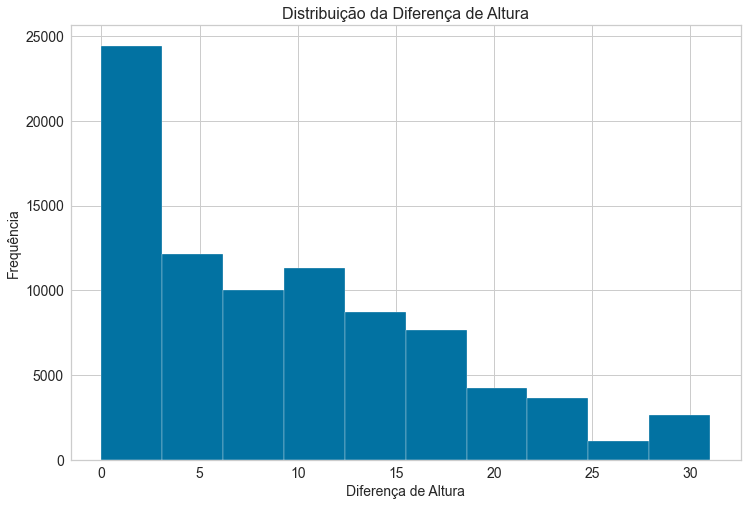

In [55]:
# Histograma para 'height_difference'
plt.hist(data=df_filtrado_j, x='height_difference', edgecolor='white')
plt.title('Distribuição da Diferença de Altura', fontsize=16)
plt.xlabel('Diferença de Altura', fontsize=14)
plt.ylabel('Frequência', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

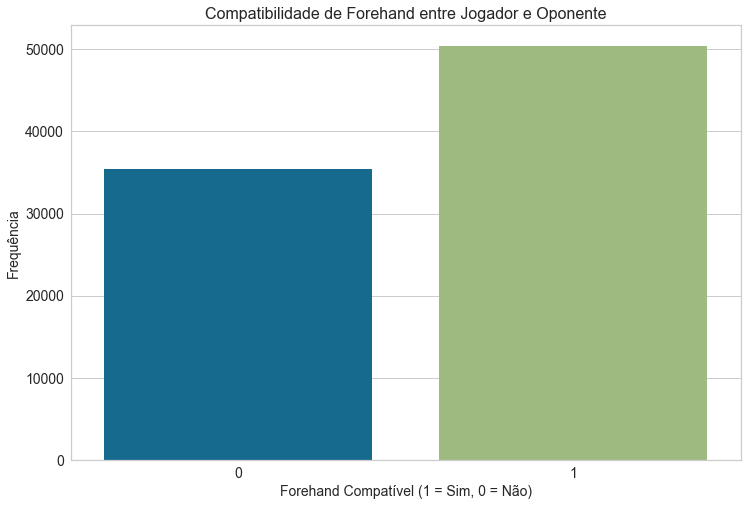

In [56]:
# Histograma para 'forehand_comp'
sns.countplot(x='forehand_comp', data=df_filtrado_j)
plt.title('Compatibilidade de Forehand entre Jogador e Oponente', fontsize=16)
plt.xlabel('Forehand Compatível (1 = Sim, 0 = Não)', fontsize=14)
plt.ylabel('Frequência', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

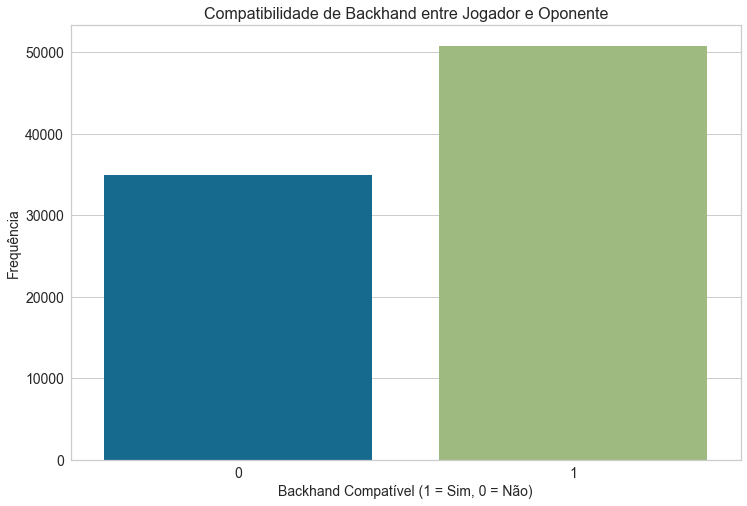

In [57]:
# Histograma para 'backhand_comp'
sns.countplot(x='backhand_comp', data=df_filtrado_j)
plt.title('Compatibilidade de Backhand entre Jogador e Oponente', fontsize=16)
plt.xlabel('Backhand Compatível (1 = Sim, 0 = Não)', fontsize=14)
plt.ylabel('Frequência', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

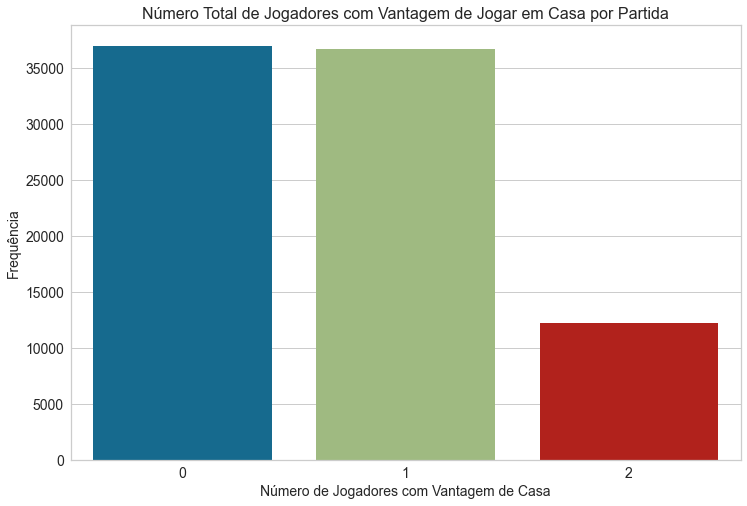

In [58]:
sns.countplot(x='total_home_advantage_players', data=df_filtrado_j)
plt.title('Número Total de Jogadores com Vantagem de Jogar em Casa por Partida', fontsize=16)
plt.xlabel('Número de Jogadores com Vantagem de Casa', fontsize=14)
plt.ylabel('Frequência', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

In [59]:
df_filtrado_j['game_round'].unique()

array(['Semi-Finals', 'Round of 32', 'Round of 64', 'Round of 128',
       'Quarter-Finals', 'Round of 16', 'Finals', 'Round Robin',
       '2nd Round Qualifying', '1st Round Qualifying',
       '3rd Round Qualifying', 'Olympic Bronze', '3rd/4th Place Match'],
      dtype=object)

#### Uniformização da variável multicategórica `game_round`

In [60]:
# Dicionário para mapear as categorias existentes para as novas categorias desejadas
mapeamento_categorias = {
    'Semi-Finals': 'Medal Rounds',
    'Round of 32': 'Early Rounds',
    'Round of 64': 'Early Rounds',
    'Round of 128': 'Early Rounds',
    'Quarter-Finals': 'Mid Rounds',
    'Round of 16': 'Mid Rounds',
    'Finals': 'Finals',
    'Round Robin': 'Qualifiers',
    '2nd Round Qualifying': 'Qualifiers',
    '1st Round Qualifying': 'Qualifiers',
    '3rd Round Qualifying': 'Qualifiers',
    'Olympic Bronze': 'Medal Rounds',
    '3rd/4th Place Match': 'Medal Rounds'
}

# Aplica o mapeamento de categorias à coluna 'game_round'
df_filtrado_j['game_round'] = df_filtrado_j['game_round'].replace(mapeamento_categorias)

In [61]:
df_filtrado_j['game_round'].unique()

array(['Medal Rounds', 'Early Rounds', 'Mid Rounds', 'Finals',
       'Qualifiers'], dtype=object)

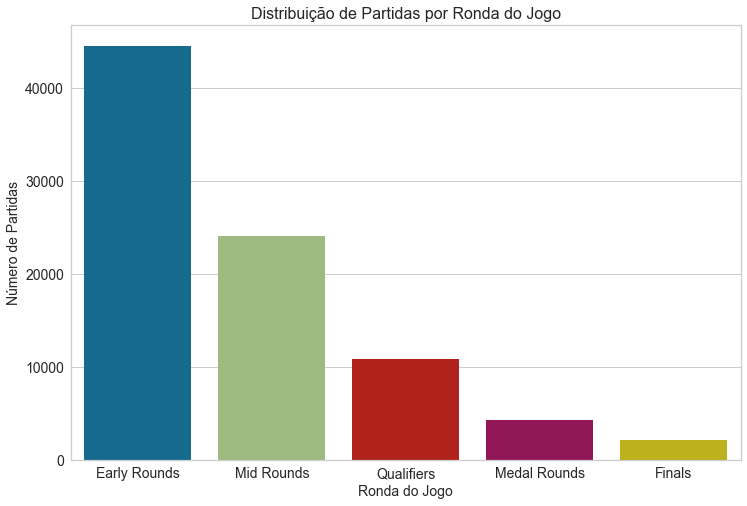

In [62]:
sns.countplot(x='game_round', data=df_filtrado_j, order=df_filtrado_j['game_round'].value_counts().index)
plt.title('Distribuição de Partidas por Ronda do Jogo', fontsize=16)
plt.xlabel('Ronda do Jogo', fontsize=14)
plt.ylabel('Número de Partidas', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

#### Criação da variável `rank_difference`

In [63]:
# Atualizar o game_rank para rank_oponent uma vez que este é referido apenas ao oponente
df_filtrado_j = df_filtrado_j.rename(columns={'game_rank': 'rank_oponent'})

In [64]:
# Função que devolve um dicionário com o nome do jogador e o respetivo rank em cada ano
def get_rank_by_year(data):
    # Cria um dicionário para armazenar os resultados
    result_dictionary = {}
    
    # Agrupa os dados pelo ano em que o jogo foi iniciado
    groups = data.groupby(data['start_date'].dt.year)
    
    # Para cada grupo, cria um dicionário com o nome do jogador e o respetivo rank nesse ano
    for year, group in groups:
        year_dictionary = {}
        for _, row in group.iterrows():
            year_dictionary[row['oponent']] = row['rank_oponent']
        result_dictionary[year] = year_dictionary
        
    return result_dictionary

In [65]:
# Obter um dicionário com os jogadores e seus ranks em cada ano
result_dictionary = get_rank_by_year(df_filtrado_j)

In [66]:
list(result_dictionary[2018].items())[:3]

[('Joao Sousa', 80), ('Richard Gasquet', 37), ('John Millman', 53)]

In [67]:
# Função que procura o valor do ranking no dicionário
def get_rank(row):
    year = row['start_date'].year
    player_name = row['player_name']
    if year in result_dictionary and player_name in result_dictionary[year]:
        return result_dictionary[year][player_name]
    else:
        return None
    
# Cria a coluna 'rank_player' já com os valores correspondentes
df_filtrado_j.insert(2, 'rank_player', df_filtrado_j.apply(get_rank, axis=1))

In [68]:
# verificar jogadores sem ranking 
df_filtrado_j[df_filtrado_j['rank_player'].isna()]

,player_name,tournament,rank_player,start_date,end_date,ground,game_round,rank_oponent,oponent,score,id,tournament_location,prize,tournament_country,concatenated_sorted,head_to_head_all_tournaments,start_year,player_total_games_year,opponent_total_games_year,diff_num_games_year_all_tournaments,player_name_height,player_name_backhand,player_name_forehand,player_name_country,player_name_dob,oponent_height,oponent_backhand,oponent_forehand,oponent_country,oponent_dob,number_of_sets,tournament_duration,player_name_age,oponent_age,age_difference,height_difference,player_name_home_advantage,oponent_home_advantage,total_home_advantage_players,forehand_comp,backhand_comp
342,Rafael Nadal,US Open,NaN,2013-08-26,2013-09-08,Hard,Finals,1,Novak Djokovic,62 36 64 61,1855,"New York, NY, U.S.A.",1400000.0,United States,Novak Djokovic - Rafael Nadal,37,2013,49,87,38,185.0,Two-Handed Backhand,Left-Handed,Spain,1986-06-03,188.0,Two-Handed Backhand,Right-Handed,Serbia,1987-05-22,4,13,27,26,1,3.0,False,False,0,0,1
343,Rafael Nadal,US Open,NaN,2013-08-26,2013-09-08,Hard,Medal Rounds,9,Richard Gasquet,"64 76, 62",1856,"New York, NY, U.S.A.",1400000.0,United States,Rafael Nadal - Richard Gasquet,12,2013,49,69,20,185.0,Two-Handed Backhand,Left-Handed,Spain,1986-06-03,183.0,One-Handed Backhand,Right-Handed,France,1986-06-18,3,13,27,27,0,2.0,False,False,0,0,0
344,Rafael Nadal,US Open,NaN,2013-08-26,2013-09-08,Hard,Mid Rounds,22,Tommy Robredo,60 62 62,1858,"New York, NY, U.S.A.",1400000.0,United States,Rafael Nadal - Tommy Robredo,7,2013,49,38,11,185.0,Two-Handed Backhand,Left-Handed,Spain,1986-06-03,180.0,One-Handed Backhand,Right-Handed,Spain,1982-05-01,3,13,27,31,4,5.0,False,False,0,0,0
345,Rafael Nadal,US Open,NaN,2013-08-26,2013-09-08,Hard,Mid Rounds,25,Philipp Kohlschreiber,"67, 64 63 61",1859,"New York, NY, U.S.A.",1400000.0,United States,Philipp Kohlschreiber - Rafael Nadal,13,2013,49,70,21,185.0,Two-Handed Backhand,Left-Handed,Spain,1986-06-03,178.0,One-Handed Backhand,Right-Handed,Germany,1983-10-16,4,13,27,29,2,7.0,False,False,0,0,0
346,Rafael Nadal,US Open,NaN,2013-08-26,2013-09-08,Hard,Early Rounds,38,Ivan Dodig,64 63 63,1860,"New York, NY, U.S.A.",1400000.0,United States,Ivan Dodig - Rafael Nadal,3,2013,49,60,11,185.0,Two-Handed Backhand,Left-Handed,Spain,1986-06-03,183.0,Two-Handed Backhand,Right-Handed,Bosnia and Herzegovina,1985-01-02,3,13,27,28,1,2.0,False,False,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85816,Harold Solomon,Houston,NaN,1971-04-19,1971-04-25,Clay,Mid Rounds,0,Cliff Richey,16 67,683866,"Houston, TX, U.S.A.",25000.0,United States,Cliff Richey - Harold Solomon,2,1971,2,3,1,170.0,Unknown Backhand,Right-Handed,United States,1952-09-17,201.0,Unknown Backhand,Unknown Forehand,United States,1946-12-31,2,6,18,24,6,31.0,True,True,2,0,1
85817,Harold Solomon,Clemmons,NaN,1971-07-19,1971-07-25,Clay,Mid Rounds,0,Cliff Richey,75 57 46,683867,"Clemmons, NC, U.S.A.",25000.0,United States,Cliff Richey - Harold Solomon,4,1971,2,3,1,170.0,Unknown Backhand,Right-Handed,United States,1952-09-17,201.0,Unknown Backhand,Unknown Forehand,United States,1946-12-31,3,6,18,24,6,31.0,True,True,2,0,1
85818,Harold Solomon,Washington WCT,NaN,1971-07-12,1971-07-18,Clay,Early Rounds,0,Stan Smith,46 26,683868,"Washington, DC, U.S.A.",50000.0,United States,Harold Solomon - Stan Smith,1,1971,2,5,3,170.0,Unknown Backhand,Right-Handed,United States,1952-09-17,201.0,Unknown Backhand,Unknown Forehand,United States,1946-12-14,2,6,18,24,6,31.0,True,True,2,0,1
85819,Harold Solomon,Boston-2,NaN,1969-08-16,1969-08-24,Grass,Early Rounds,0,Tico Carrero,46 86 68,683869,"Boston, MA, U.S.A.",20000.0,United States,Harold Solomon - Tico Carrero,1,1969,0,0,0,170.0,Unknown Backhand,Right-Handed,United States,1952-09-17,201.0,Unknown Backhand,Unknown Forehand,nan,1948-09-04,3,8,16,20,4,31.0,True,False,1,0,1


In [69]:
# como são jogadores que vêm de lesão, imputamos o pior ranking 
df_filtrado_j['rank_player'] = df_filtrado_j['rank_player'].fillna(max(df_filtrado_j['rank_player']))

In [70]:
# Cria a coluna 'rank_difference' já com os valores correspondentes
df_filtrado_j['rank_difference'] = df_filtrado_j.apply(lambda row: abs(row['rank_player'] - row['rank_oponent']), axis=1)

df_filtrado_j.head()

,player_name,tournament,rank_player,start_date,end_date,ground,game_round,rank_oponent,oponent,score,id,tournament_location,prize,tournament_country,concatenated_sorted,head_to_head_all_tournaments,start_year,player_total_games_year,opponent_total_games_year,diff_num_games_year_all_tournaments,player_name_height,player_name_backhand,player_name_forehand,player_name_country,player_name_dob,oponent_height,oponent_backhand,oponent_forehand,oponent_country,oponent_dob,number_of_sets,tournament_duration,player_name_age,oponent_age,age_difference,height_difference,player_name_home_advantage,oponent_home_advantage,total_home_advantage_players,forehand_comp,backhand_comp,rank_difference
0,Novak Djokovic,US Open,1.0,2021-08-30,2021-09-12,Hard,Medal Rounds,4,Alexander Zverev,46 62 64 46 62,7,"New York, NY, U.S.A.",1400000.0,United States,Alexander Zverev - Novak Djokovic,10,2021,40,36,4,188.0,Two-Handed Backhand,Right-Handed,Serbia,1987-05-22,198.0,Two-Handed Backhand,Right-Handed,Germany,1997-04-20,5,13,34,24,10,10.0,False,False,0,1,1,3.0
1,Novak Djokovic,US Open,1.0,2021-08-30,2021-09-12,Hard,Early Rounds,56,Kei Nishikori,"67, 63 63 62",9,"New York, NY, U.S.A.",1400000.0,United States,Kei Nishikori - Novak Djokovic,22,2021,40,6,34,188.0,Two-Handed Backhand,Right-Handed,Serbia,1987-05-22,178.0,Two-Handed Backhand,Right-Handed,Japan,1989-12-29,4,13,34,31,3,10.0,False,False,0,1,1,55.0
2,Novak Djokovic,US Open,1.0,2021-08-30,2021-09-12,Hard,Early Rounds,121,Tallon Griekspoor,62 63 62,10,"New York, NY, U.S.A.",1400000.0,United States,Novak Djokovic - Tallon Griekspoor,1,2021,40,27,13,188.0,Two-Handed Backhand,Right-Handed,Serbia,1987-05-22,188.0,Two-Handed Backhand,Right-Handed,Netherlands,1996-07-02,3,13,34,25,9,0.0,False,False,0,1,1,120.0
3,Novak Djokovic,US Open,1.0,2021-08-30,2021-09-12,Hard,Early Rounds,145,Holger Rune,"61 67, 62 61",11,"New York, NY, U.S.A.",1400000.0,United States,Holger Rune - Novak Djokovic,1,2021,40,48,8,188.0,Two-Handed Backhand,Right-Handed,Serbia,1987-05-22,188.0,Two-Handed Backhand,Right-Handed,Denmark,2003-04-29,4,13,34,18,16,0.0,False,False,0,1,1,144.0
4,Novak Djokovic,US Open,1.0,2021-08-30,2021-09-12,Hard,Mid Rounds,8,Matteo Berrettini,57 62 62 63,16,"New York, NY, U.S.A.",1400000.0,United States,Matteo Berrettini - Novak Djokovic,4,2021,40,15,25,188.0,Two-Handed Backhand,Right-Handed,Serbia,1987-05-22,196.0,Two-Handed Backhand,Right-Handed,Italy,1996-04-12,4,13,34,25,9,8.0,False,False,0,1,1,7.0


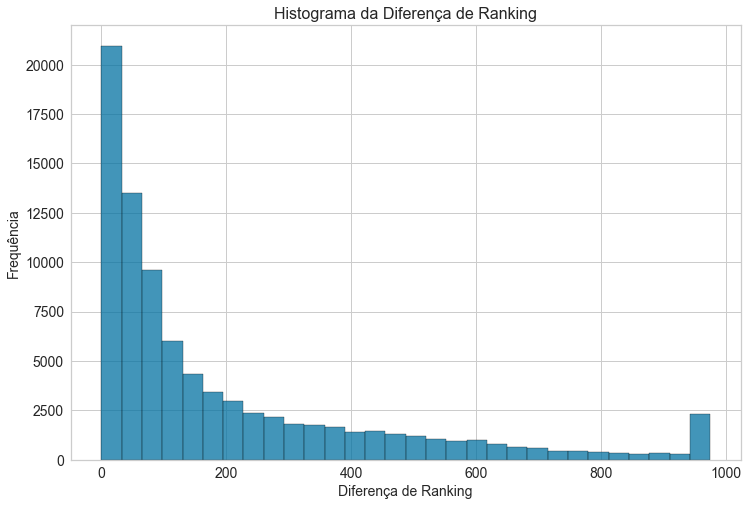

In [71]:
sns.histplot(df_filtrado_j['rank_difference'], bins=30, kde=False)
plt.title('Histograma da Diferença de Ranking', fontsize=16)
plt.xlabel('Diferença de Ranking', fontsize=14)
plt.ylabel('Frequência', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

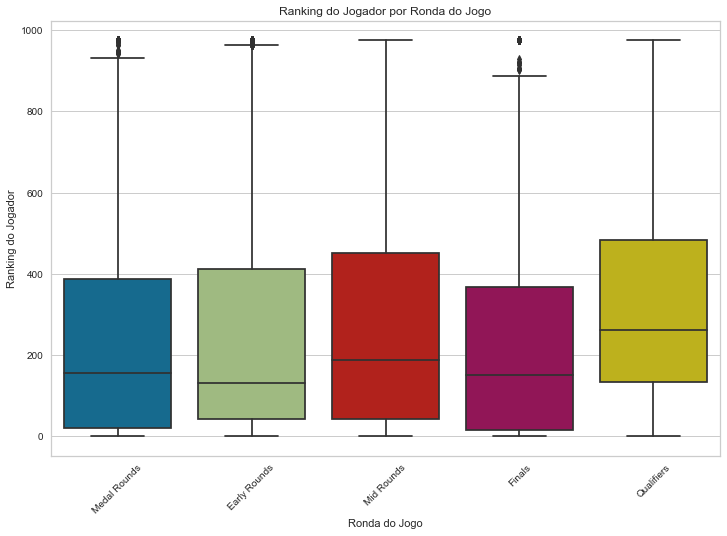

In [72]:
sns.boxplot(x='game_round', y='rank_player', data=df_filtrado_j)
plt.title('Ranking do Jogador por Ronda do Jogo')
plt.xticks(rotation=45)  # Rotação dos rótulos do eixo x para melhor visualização
plt.xlabel('Ronda do Jogo')
plt.ylabel('Ranking do Jogador')
plt.show()

In [73]:
# ver o número de sets (há valores estranhos, mas vamos verificar quando separarmos grand slams de outros torneios)
df_filtrado_j['number_of_sets'].value_counts()

2    52409
3    29502
4     2327
5     1165
1      400
6       20
Name: number_of_sets, dtype: int64

In [74]:
df_filtrado_j.describe(include='all').T

C:\Users\joaop\AppData\Local\Temp\ipykernel_15956\2940709602.py:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  df_filtrado_j.describe(include='all').T
C:\Users\joaop\AppData\Local\Temp\ipykernel_15956\2940709602.py:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  df_filtrado_j.describe(include='all').T
C:\Users\joaop\AppData\Local\Temp\ipykernel_15956\2940709602.py:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt

,count,unique,top,freq,first,last,mean,std,min,25%,50%,75%,max
player_name,85823,3241,Harold Solomon,1046,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
tournament,85823,420,US Open,6891,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
rank_player,85823.0,NaN,NaN,NaN,NaT,NaT,281.614357,293.364559,0.0,48.0,170.0,436.0,975.0
start_date,85823,1669,2019-08-26 00:00:00,242,1914-08-24,2022-03-21,NaN,NaN,NaN,NaN,NaN,NaN,NaN
end_date,85823,1663,2019-09-08 00:00:00,291,1914-09-01,2022-04-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ground,85823,4,Hard,65921,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
game_round,85823,5,Early Rounds,44558,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
rank_oponent,85823.0,NaN,NaN,NaN,NaT,NaT,293.952693,308.073802,0.0,55.0,168.0,458.0,975.0
oponent,85823,5841,Tommy Haas,362,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
score,85823,5463,64 64,3050,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Dos 85823 jogos presentes no data frame:

- *player_name e oponent:* existem 5841 jogadores, sendo que o jogador que mais aparece é o Harold Solomon (1046 jogos jogados)

- *tournament:* existem 420 torneios distintos, sendo que o US Open é o torneio mais jogado (6891 jogos no US Open)

- *start_date e end_date:* contém jogos desde 1914 até 2022

- *ground:* mais de 75% dos jogos são no hard ground

- *score:* o resultado mais comum é 6-4 6-4 (2 sets) tendo ocorrido 3050 vezes

- *prize:* o valor máximo do prémio registado num torneio é de 28619350$. No entanto é possível que este valor não esteja correto, uma vez que foge muito do valor médio praticado nos EUA de 1384047$

- *concatenated_sorted:* o confronto que ocorreu mais vezes foi entre o Harold Solom e o Eddie Dibbs (28 confrontos)

- *player_total_games_year e opponent_total_games_year:* o máximo de jogos registados num ano de um único jogador é 201 jogos

- *player_name_height e oponent_height:* observamos um erro no valor máximo que dá-se por 5.10m

- *player_name_forehand e oponent_forehand:* mais de 70% dos jogadores têm como mão dominante a mão direita

- *player_name_country e oponent_country:* estão representados jogadores de mais de 100 países diferentes, sendo que o país mais recorrente é os EUA representando cerca 35% dos jogadores

- *number_of_sets:* o número médio de sets é 2.434977

- *tournament_duration:* a duração média de um torneio é de 7 dias

- *rank_difference:* a média da diferença do rank dos jogadores é 321.6 tendo um desvio padrão de 383.5

In [75]:
df_filtrado_j.head()

,player_name,tournament,rank_player,start_date,end_date,ground,game_round,rank_oponent,oponent,score,id,tournament_location,prize,tournament_country,concatenated_sorted,head_to_head_all_tournaments,start_year,player_total_games_year,opponent_total_games_year,diff_num_games_year_all_tournaments,player_name_height,player_name_backhand,player_name_forehand,player_name_country,player_name_dob,oponent_height,oponent_backhand,oponent_forehand,oponent_country,oponent_dob,number_of_sets,tournament_duration,player_name_age,oponent_age,age_difference,height_difference,player_name_home_advantage,oponent_home_advantage,total_home_advantage_players,forehand_comp,backhand_comp,rank_difference
0,Novak Djokovic,US Open,1.0,2021-08-30,2021-09-12,Hard,Medal Rounds,4,Alexander Zverev,46 62 64 46 62,7,"New York, NY, U.S.A.",1400000.0,United States,Alexander Zverev - Novak Djokovic,10,2021,40,36,4,188.0,Two-Handed Backhand,Right-Handed,Serbia,1987-05-22,198.0,Two-Handed Backhand,Right-Handed,Germany,1997-04-20,5,13,34,24,10,10.0,False,False,0,1,1,3.0
1,Novak Djokovic,US Open,1.0,2021-08-30,2021-09-12,Hard,Early Rounds,56,Kei Nishikori,"67, 63 63 62",9,"New York, NY, U.S.A.",1400000.0,United States,Kei Nishikori - Novak Djokovic,22,2021,40,6,34,188.0,Two-Handed Backhand,Right-Handed,Serbia,1987-05-22,178.0,Two-Handed Backhand,Right-Handed,Japan,1989-12-29,4,13,34,31,3,10.0,False,False,0,1,1,55.0
2,Novak Djokovic,US Open,1.0,2021-08-30,2021-09-12,Hard,Early Rounds,121,Tallon Griekspoor,62 63 62,10,"New York, NY, U.S.A.",1400000.0,United States,Novak Djokovic - Tallon Griekspoor,1,2021,40,27,13,188.0,Two-Handed Backhand,Right-Handed,Serbia,1987-05-22,188.0,Two-Handed Backhand,Right-Handed,Netherlands,1996-07-02,3,13,34,25,9,0.0,False,False,0,1,1,120.0
3,Novak Djokovic,US Open,1.0,2021-08-30,2021-09-12,Hard,Early Rounds,145,Holger Rune,"61 67, 62 61",11,"New York, NY, U.S.A.",1400000.0,United States,Holger Rune - Novak Djokovic,1,2021,40,48,8,188.0,Two-Handed Backhand,Right-Handed,Serbia,1987-05-22,188.0,Two-Handed Backhand,Right-Handed,Denmark,2003-04-29,4,13,34,18,16,0.0,False,False,0,1,1,144.0
4,Novak Djokovic,US Open,1.0,2021-08-30,2021-09-12,Hard,Mid Rounds,8,Matteo Berrettini,57 62 62 63,16,"New York, NY, U.S.A.",1400000.0,United States,Matteo Berrettini - Novak Djokovic,4,2021,40,15,25,188.0,Two-Handed Backhand,Right-Handed,Serbia,1987-05-22,196.0,Two-Handed Backhand,Right-Handed,Italy,1996-04-12,4,13,34,25,9,8.0,False,False,0,1,1,7.0


In [76]:
# separar torneios de grand slams dos outros torneios
df_grand_slams_us = df_filtrado_j[(df_filtrado_j["tournament"] == "US Open") | (df_filtrado_j["tournament"] == "US Open Preliminary Round")]

df_other_tournaments_us = df_filtrado_j[~((df_filtrado_j["tournament"] == "US Open") | (df_filtrado_j["tournament"] == "US Open Preliminary Round"))]

In [77]:
df_other_tournaments_us.describe(include='all').T

C:\Users\joaop\AppData\Local\Temp\ipykernel_15956\81814664.py:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  df_other_tournaments_us.describe(include='all').T
C:\Users\joaop\AppData\Local\Temp\ipykernel_15956\81814664.py:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  df_other_tournaments_us.describe(include='all').T
C:\Users\joaop\AppData\Local\Temp\ipykernel_15956\81814664.py:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this war

,count,unique,top,freq,first,last,mean,std,min,25%,50%,75%,max
player_name,78930,3199,Harold Solomon,992,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
tournament,78930,418,ATP Masters 1000 Miami,3486,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
rank_player,78930.0,NaN,NaN,NaN,NaT,NaT,296.876371,296.956765,0.0,56.0,187.0,462.0,975.0
start_date,78930,1615,2021-10-04 00:00:00,195,1914-08-24,2022-03-21,NaN,NaN,NaN,NaN,NaN,NaN,NaN
end_date,78930,1611,2019-03-17 00:00:00,246,1914-09-01,2022-04-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ground,78930,4,Hard,59205,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
game_round,78930,5,Early Rounds,39930,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
rank_oponent,78930.0,NaN,NaN,NaN,NaT,NaT,309.277626,314.378782,0.0,58.0,183.0,495.0,975.0
oponent,78930,5773,Tommy Haas,312,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
score,78930,2901,64 64,2984,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### Verificação do `number_of_sets` em todos os torneios dos EUA exceto Grand Slams

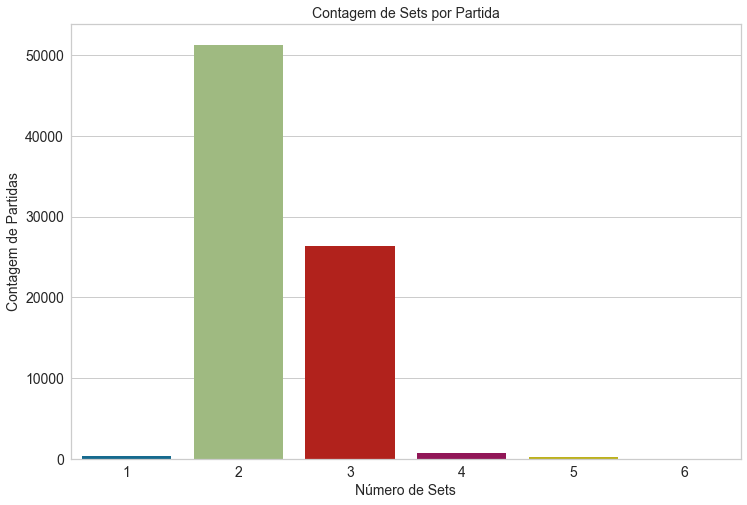

In [78]:
# Contagem de sets por partida
sns.countplot(data=df_other_tournaments_us, x='number_of_sets')
plt.title('Contagem de Sets por Partida', fontsize=14)
plt.xlabel('Número de Sets', fontsize=14)
plt.ylabel('Contagem de Partidas', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

In [79]:
# verificações dos números de sets estranhos
df_other_tournaments_us[df_other_tournaments_us['number_of_sets']==4]

,player_name,tournament,rank_player,start_date,end_date,ground,game_round,rank_oponent,oponent,score,id,tournament_location,prize,tournament_country,concatenated_sorted,head_to_head_all_tournaments,start_year,player_total_games_year,opponent_total_games_year,diff_num_games_year_all_tournaments,player_name_height,player_name_backhand,player_name_forehand,player_name_country,player_name_dob,oponent_height,oponent_backhand,oponent_forehand,oponent_country,oponent_dob,number_of_sets,tournament_duration,player_name_age,oponent_age,age_difference,height_difference,player_name_home_advantage,oponent_home_advantage,total_home_advantage_players,forehand_comp,backhand_comp,rank_difference
105,Novak Djokovic,USA vs. SRB WG QF,1.0,2013-04-01,2013-04-07,Hard,Qualifiers,20,Sam Querrey,"75 67, 61 60",511,"Boise, United States",0.0,United States,Novak Djokovic - Sam Querrey,7,2013,87,73,14,188.0,Two-Handed Backhand,Right-Handed,Serbia,1987-05-22,198.0,Two-Handed Backhand,Right-Handed,United States,1987-10-07,4,6,25,25,0,10.0,False,True,1,1,1,19.0
555,Alexander Zverev,U.S.A. F32,975.0,2012-11-12,2012-11-18,Clay,Mid Rounds,521,Benjamin Balleret,63 26 41 (RET),2965,"Bradenton, FL, U.S.A.",10000.0,United States,Alexander Zverev - Benjamin Balleret,2,2012,2,77,75,191.0,Two-Handed Backhand,Right-Handed,Germany,1997-04-20,183.0,Two-Handed Backhand,Right-Handed,Monaco,1983-01-15,4,6,15,29,14,8.0,False,False,0,1,1,454.0
1304,Reilly Opelka,New York,56.0,2019-02-11,2019-02-17,Hard,Mid Rounds,106,Denis Istomin,"67, 76, 10 (RET)",6828,"New York, NY, U.S.A",694995.0,United States,Denis Istomin - Reilly Opelka,2,2019,59,56,3,191.0,Two-Handed Backhand,Right-Handed,United States,1997-08-28,185.0,Two-Handed Backhand,Right-Handed,Russian Federation,1986-09-07,4,6,21,32,11,6.0,True,False,1,1,1,50.0
1561,John Isner,USA vs. BEL WG QF,11.0,2018-04-02,2018-04-08,Hard,Qualifiers,319,Joris De Loore,"63 67, 76, 64",8211,"Nashville, TN, United States",0.0,United States,John Isner - Joris De Loore,1,2018,62,48,14,191.0,Two-Handed Backhand,Right-Handed,United States,1985-04-26,191.0,Two-Handed Backhand,Right-Handed,Belgium,1993-04-21,4,6,32,24,8,0.0,True,False,1,1,1,308.0
1590,John Isner,USA vs. SUI WG 1st RD,23.0,2017-01-30,2017-02-05,Hard,Qualifiers,127,Henri Laaksonen,46 62 62 76,8266,"Birmingham, United States",0.0,United States,Henri Laaksonen - John Isner,1,2017,54,89,35,191.0,Two-Handed Backhand,Right-Handed,United States,1985-04-26,185.0,Two-Handed Backhand,Right-Handed,Finland,1992-03-31,4,6,31,24,7,6.0,True,False,1,1,1,104.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85217,Simone Colombo,Key Biscayne,174.0,1987-02-23,1987-03-08,Hard,Early Rounds,58,Tomas Smid,36 63 36 67,680620,"Key Biscayne, FL, U.S.A.",750000.0,United States,Simone Colombo - Tomas Smid,1,1987,41,49,8,180.0,Unknown Backhand,Right-Handed,Italy,1963-08-28,201.0,Unknown Backhand,Unknown Forehand,Czech Republic,1956-05-20,4,13,23,30,7,21.0,False,False,0,0,1,116.0
85299,Harold Solomon,North Conway,187.0,1984-07-30,1984-08-05,Clay,Early Rounds,311,Wolfgang Popp,64 67 01 (RET),681327,"North Conway, NH, U.S.A.",200000.0,United States,Harold Solomon - Wolfgang Popp,4,1984,36,0,36,170.0,Unknown Backhand,Right-Handed,United States,1952-09-17,201.0,Unknown Backhand,Unknown Forehand,nan,1959-05-19,4,6,31,25,6,31.0,True,False,1,0,1,124.0
85493,Jan Kodes,Philadelphia WCT,8.0,1974-01-21,1974-01-27,Carpet,Medal Rounds,8,Rod Laver,46 61 46 06,681899,"Philadelphia, PA, U.S.A.",100000.0,United States,Jan Kodes - Rod Laver,5,1974,78,12,66,175.0,Unknown Backhand,Right-Handed,Czech Republic,1946-03-01,201.0,Unknown Backhand,Unknown Forehand,Australia,1938-08-09,4,6,27,35,8,26.0,False,False,0,0,1,0.0
85579,Andrey Kuznetsov,Irving,68.0,2017-03-13,2017-03-19,Hard,Early Rounds,93,Jared Donaldson,16 62 13 (RET),682464,"Irving, TX, U.S.A.",150000.0,United States,Andrey Kuznetsov - Jared Donaldson

In [80]:
# eliminar os jogos em que os jogadores se retiram ou há walkover ou desqualificação 
mask = (df_other_tournaments_us['score'].str.contains("(RET)") | df_other_tournaments_us['score'].str.contains("(W/O)") | df_other_tournaments_us['score'].str.contains("(DEF)"))
df_other_tournaments_us = df_other_tournaments_us[~mask]

C:\Users\joaop\AppData\Local\Temp\ipykernel_15956\3824881808.py:2: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  mask = (df_other_tournaments_us['score'].str.contains("(RET)") | df_other_tournaments_us['score'].str.contains("(W/O)") | df_other_tournaments_us['score'].str.contains("(DEF)"))


In [81]:
df_other_tournaments_us['number_of_sets'].value_counts()


2    50689
3    25274
4      264
5      158
1        8
Name: number_of_sets, dtype: int64

In [82]:
df_grand_slams_us['number_of_sets'].value_counts()


3    3118
4    1655
2    1084
5    1003
6      17
1      16
Name: number_of_sets, dtype: int64

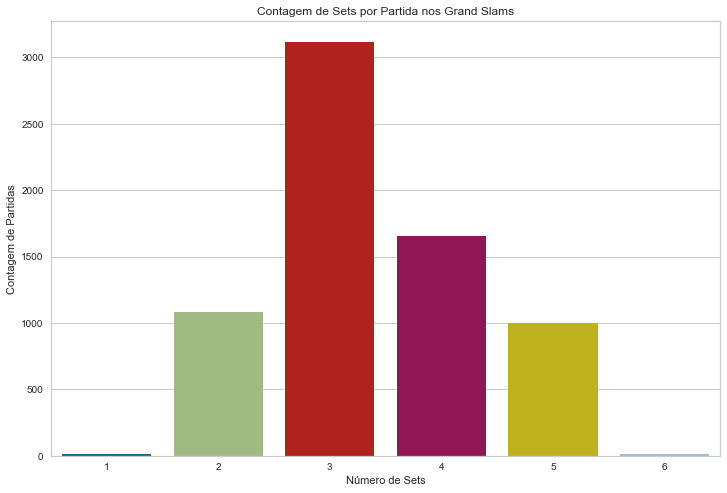

In [83]:
# Contagem de sets por partida de grand slams
sns.countplot(data=df_grand_slams_us, x='number_of_sets')
plt.title('Contagem de Sets por Partida nos Grand Slams')
plt.xlabel('Número de Sets')
plt.ylabel('Contagem de Partidas')
plt.show()

In [84]:
df_grand_slams_us[df_grand_slams_us['number_of_sets']==2]

,player_name,tournament,rank_player,start_date,end_date,ground,game_round,rank_oponent,oponent,score,id,tournament_location,prize,tournament_country,concatenated_sorted,head_to_head_all_tournaments,start_year,player_total_games_year,opponent_total_games_year,diff_num_games_year_all_tournaments,player_name_height,player_name_backhand,player_name_forehand,player_name_country,player_name_dob,oponent_height,oponent_backhand,oponent_forehand,oponent_country,oponent_dob,number_of_sets,tournament_duration,player_name_age,oponent_age,age_difference,height_difference,player_name_home_advantage,oponent_home_advantage,total_home_advantage_players,forehand_comp,backhand_comp,rank_difference
39,Novak Djokovic,US Open,1.0,2016-08-29,2016-09-11,Hard,Early Rounds,61,Mikhail Youzhny,42 (RET),253,"New York, NY, U.S.A.",1400000.0,United States,Mikhail Youzhny - Novak Djokovic,11,2016,89,49,40,188.0,Two-Handed Backhand,Right-Handed,Serbia,1987-05-22,183.0,One-Handed Backhand,Right-Handed,Russian Federation,1982-06-25,2,13,29,34,5,5.0,False,False,0,1,0,60.0
529,Alexander Zverev,US Open,119.0,2015-08-31,2015-09-13,Hard,Qualifiers,136,Ivan Dodig,"76, 75",2879,"New York, NY, U.S.A.",1400000.0,United States,Alexander Zverev - Ivan Dodig,1,2015,62,37,25,191.0,Two-Handed Backhand,Right-Handed,Germany,1997-04-20,183.0,Two-Handed Backhand,Right-Handed,Bosnia and Herzegovina,1985-01-02,2,13,18,30,12,8.0,False,False,0,1,1,17.0
531,Alexander Zverev,US Open,119.0,2015-08-31,2015-09-13,Hard,Qualifiers,148,Horacio Zeballos,61 64,2881,"New York, NY, U.S.A.",1400000.0,United States,Alexander Zverev - Horacio Zeballos,4,2015,62,58,4,191.0,Two-Handed Backhand,Right-Handed,Germany,1997-04-20,188.0,One-Handed Backhand,Left-Handed,Argentina,1985-04-27,2,13,18,30,12,3.0,False,False,0,0,0,29.0
542,Alexander Zverev,US Open,157.0,2014-08-25,2014-09-08,Hard,Qualifiers,241,Yasutaka Uchiyama,64 64,2924,"New York City, NY, U.S.A.",1400000.0,United States,Alexander Zverev - Yasutaka Uchiyama,1,2014,26,88,62,191.0,Two-Handed Backhand,Right-Handed,Germany,1997-04-20,183.0,Two-Handed Backhand,Right-Handed,Japan,1992-08-05,2,14,17,22,5,8.0,False,False,0,1,1,84.0
618,Matteo Berrettini,US Open,139.0,2017-08-28,2017-09-10,Hard,Qualifiers,315,Marcelo Arevalo,62 76,3486,"New York, NY, U.S.A.",1400000.0,United States,Marcelo Arevalo - Matteo Berrettini,1,2017,28,86,58,191.0,Two-Handed Backhand,Right-Handed,Italy,1996-04-12,193.0,Two-Handed Backhand,Right-Handed,El Salvador,1990-10-17,2,13,21,26,5,2.0,False,False,0,1,1,176.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85176,Juan Gisbert Sr,US Open,35.0,1975-08-25,1975-09-07,Clay,Early Rounds,11,Rod Laver,57 46,680460,"New York, NY, U.S.A.",166810.0,United States,Juan Gisbert Sr - Rod Laver,3,1975,70,8,62,188.0,Unknown Backhand,Right-Handed,Spain,1956-06-06,201.0,Unknown Backhand,Unknown Forehand,Australia,1938-08-09,2,13,19,37,18,13.0,False,False,0,0,1,24.0
85381,Harold Solomon,US Open,17.0,1976-08-30,1976-09-12,Clay,Early Rounds,51,Billy Martin,57 46,681470,"New York, NY, U.S.A.",217000.0,United States,Billy Martin - Harold Solomon,5,1976,201,9,192,170.0,Unknown Backhand,Right-Handed,United States,1952-09-17,201.0,Unknown Backhand,Unknown Forehand,United States,1956-12-25,2,13,23,19,4,31.0,True,True,2,0,1,34.0
85473,Jan Kodes,US Open,975.0,1977-08-29,1977-09-11,Clay,Early Rounds,3,Brian Gottfried,46 26,681832,"New York, NY, U.S.A.",250000.0,United States,Brian Gottfried - Jan Kodes,3,1977,71,27,44,175.0,Unknown Backhand,Right-Handed,Czech Republic,1946-03-01,201.0,Unknown Backhand,Unknown Forehand,United States,1952-01-27,2,13,31,25,6,26.0,False,True,1,0,1,972.0
85576,Andrea Collarini,US Open,374.0,2017-08-28,2017-09-10,Hard,Qualifiers,254,Riccardo Bellotti,57 36,682423,"New York, NY, U.S.A.",1400000.0,United States,Andrea Collarini - Riccardo Bellotti,2,2017,77,89,12,185.0,Two-Handed Backhand,Left-Handed,Unite

Nos grand slams: 
- Quando há 6 sets, significa que o jogador se retirou no último set; 

Nos outros torneios:
- 1 set aparece com (W/O) porque significa walkover; 

In [85]:
df_other_tournaments_us[df_other_tournaments_us['number_of_sets']==1]

,player_name,tournament,rank_player,start_date,end_date,ground,game_round,rank_oponent,oponent,score,id,tournament_location,prize,tournament_country,concatenated_sorted,head_to_head_all_tournaments,start_year,player_total_games_year,opponent_total_games_year,diff_num_games_year_all_tournaments,player_name_height,player_name_backhand,player_name_forehand,player_name_country,player_name_dob,oponent_height,oponent_backhand,oponent_forehand,oponent_country,oponent_dob,number_of_sets,tournament_duration,player_name_age,oponent_age,age_difference,height_difference,player_name_home_advantage,oponent_home_advantage,total_home_advantage_players,forehand_comp,backhand_comp,rank_difference
74147,John McEnroe,Pepsi Grand Slam,2.0,1980-02-11,1980-02-18,Clay,Medal Rounds,6,Guillermo Vilas,87,593894,"Boca Raton, FL, U.S.A.",300000.0,United States,Guillermo Vilas - John McEnroe,7,1980,112,94,18,180.0,Unknown Backhand,Left-Handed,Germany,1959-02-16,180.0,One-Handed Backhand,Left-Handed,Argentina,1952-08-17,1,7,21,27,6,0.0,False,False,0,1,0,4.0
77881,Jan Kodes,Denver,975.0,1970-10-07,1970-10-11,Hard,Qualifiers,0,Marty Riessen,62,609048,"Denver, CO, U.S.A.",16500.0,United States,Jan Kodes - Marty Riessen,5,1970,61,0,61,175.0,Unknown Backhand,Right-Handed,Czech Republic,1946-03-01,201.0,Unknown Backhand,Unknown Forehand,United States,1941-12-04,1,4,24,28,4,26.0,False,True,1,0,1,975.0
77882,Jan Kodes,Denver,975.0,1970-10-07,1970-10-11,Hard,Qualifiers,0,Erik Van Dillen,64,609049,"Denver, CO, U.S.A.",16500.0,United States,Erik Van Dillen - Jan Kodes,1,1970,61,0,61,175.0,Unknown Backhand,Right-Handed,Czech Republic,1946-03-01,201.0,Unknown Backhand,Unknown Forehand,United States,1951-02-21,1,4,24,19,5,26.0,False,True,1,0,1,975.0
77887,Jan Kodes,Denver,975.0,1970-10-07,1970-10-11,Hard,Qualifiers,0,Charlie Pasarell,61,609055,"Denver, CO, U.S.A.",16500.0,United States,Charlie Pasarell - Jan Kodes,2,1970,61,0,61,175.0,Unknown Backhand,Right-Handed,Czech Republic,1946-03-01,201.0,Unknown Backhand,Unknown Forehand,United States,1944-02-12,1,4,24,26,2,26.0,False,True,1,0,1,975.0
77889,Jan Kodes,Denver,975.0,1970-10-07,1970-10-11,Hard,Qualifiers,0,Stan Smith,64,609060,"Denver, CO, U.S.A.",16500.0,United States,Jan Kodes - Stan Smith,4,1970,61,1,60,175.0,Unknown Backhand,Right-Handed,Czech Republic,1946-03-01,201.0,Unknown Backhand,Unknown Forehand,United States,1946-12-14,1,4,24,23,1,26.0,False,True,1,0,1,975.0
77890,Jan Kodes,Denver,975.0,1970-10-07,1970-10-11,Hard,Qualifiers,0,Robert Lutz,63,609061,"Denver, CO, U.S.A.",16500.0,United States,Jan Kodes - Robert Lutz,3,1970,61,1,60,175.0,Unknown Backhand,Right-Handed,Czech Republic,1946-03-01,201.0,Unknown Backhand,Unknown Forehand,nan,1950-04-18,1,4,24,20,4,26.0,False,False,0,0,1,975.0
85523,Jan Kodes,Denver,975.0,1970-10-07,1970-10-11,Hard,Qualifiers,0,Dennis Ralston,36,681975,"Denver, CO, U.S.A.",16500.0,United States,Dennis Ralston - Jan Kodes,2,1970,61,0,61,175.0,Unknown Backhand,Right-Handed,Czech Republic,1946-03-01,201.0,Unknown Backhand,Unknown Forehand,United States,1942-07-27,1,4,24,28,4,26.0,False,True,1,0,1,975.0
85532,Jan Kodes,Charlotte,975.0,1969-04-07,1969-04-13,Clay,Finals,0,Mark Cox,11-1326,682000,"Charlotte, NC, U.S.A.",0.0,United States,Jan Kodes - Mark Cox,3,1969,43,2,41,175.0,Unknown Backhand,Right-Handed,Czech Republic,1946-03-01,201.0,Unknown Backhand,Unknown Forehand,United Kingdom,1943-07-05,1,6,23,25,2,26.0,False,False,0,0,1,975.0


**Para os torneios com 1 set:**
- O torneio de Denver de 1970 teve uma estrutura diferente, fizeram round robin que basicamente consiste em cada jogador jogar contra todos os outros jogadores uma única vez, num único set. O jogador com mais vitórias passa para a fase seguinte.
- Neste jogo, final do torneio de Charlotte há um erro de formatação dos dados, houve 2 sets, no entanto como o primeiro ficou 11 a 13, não foi cotado corretamente. O jogo ficou 1113 26. (linha 85539)

In [86]:
df_other_tournaments_us[df_other_tournaments_us['tournament']=='Denver']

,player_name,tournament,rank_player,start_date,end_date,ground,game_round,rank_oponent,oponent,score,id,tournament_location,prize,tournament_country,concatenated_sorted,head_to_head_all_tournaments,start_year,player_total_games_year,opponent_total_games_year,diff_num_games_year_all_tournaments,player_name_height,player_name_backhand,player_name_forehand,player_name_country,player_name_dob,oponent_height,oponent_backhand,oponent_forehand,oponent_country,oponent_dob,number_of_sets,tournament_duration,player_name_age,oponent_age,age_difference,height_difference,player_name_home_advantage,oponent_home_advantage,total_home_advantage_players,forehand_comp,backhand_comp,rank_difference
23887,Rajeev Ram,Denver,348.0,2004-08-02,2004-08-08,Hard,Mid Rounds,0,Luke Shields,62 64,218102,"Denver, CO, U.S.A.",50000.0,United States,Luke Shields - Rajeev Ram,1,2004,21,10,11,191.0,One-Handed Backhand,Right-Handed,United States,1984-03-18,168.0,Unknown Backhand,Unknown Forehand,United States,1985-04-01,2,6,20,19,1,23.0,True,True,2,0,0,348.0
23892,Rajeev Ram,Denver,348.0,2004-08-02,2004-08-08,Hard,Early Rounds,851,Sanjin Sadovich,60 64,218107,"Denver, CO, U.S.A.",50000.0,United States,Rajeev Ram - Sanjin Sadovich,2,2004,21,18,3,191.0,One-Handed Backhand,Right-Handed,United States,1984-03-18,168.0,Unknown Backhand,Unknown Forehand,Canada,1982-11-19,2,6,20,21,1,23.0,True,False,1,0,0,503.0
23904,Rajeev Ram,Denver,392.0,2003-07-28,2003-08-03,Hard,Mid Rounds,477,Kepler Orellana,36 60 61,218126,"Denver, CO, U.S.A.",25000.0,United States,Kepler Orellana - Rajeev Ram,1,2003,24,65,41,191.0,One-Handed Backhand,Right-Handed,United States,1984-03-18,168.0,Unknown Backhand,Right-Handed,"Venezuela, Bolivarian Republic of",1977-10-08,3,6,19,25,6,23.0,True,False,1,1,0,85.0
23905,Rajeev Ram,Denver,392.0,2003-07-28,2003-08-03,Hard,Early Rounds,211,Jimmy Wang,64 46 64,218127,"Denver, CO, U.S.A.",25000.0,United States,Jimmy Wang - Rajeev Ram,1,2003,24,53,29,191.0,One-Handed Backhand,Right-Handed,United States,1984-03-18,180.0,Two-Handed Backhand,Right-Handed,Saudi Arabia,1985-02-08,3,6,19,18,1,11.0,True,False,1,1,0,181.0
23908,Rajeev Ram,Denver,392.0,2003-07-28,2003-08-03,Hard,Mid Rounds,304,Uros Vico,61 64,218130,"Denver, CO, U.S.A.",25000.0,United States,Rajeev Ram - Uros Vico,1,2003,24,19,5,191.0,One-Handed Backhand,Right-Handed,United States,1984-03-18,188.0,Unknown Backhand,Right-Handed,Croatia,1981-02-19,2,6,19,22,3,3.0,True,False,1,1,0,88.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85010,Johan Kriek,Denver,28.0,1979-02-19,1979-02-25,Carpet,Early Rounds,23,Buster C. Mottram,67 46,679646,"Denver, CO, U.S.A.",125000.0,United States,Buster C. Mottram - Johan Kriek,1,1979,45,7,38,175.0,Unknown Backhand,Right-Handed,South Africa,1958-04-05,201.0,Unknown Backhand,Unknown Forehand,nan,1958-03-12,2,6,20,20,0,26.0,False,False,0,0,1,5.0
85101,Thierry Tulasne,Denver,0.0,1982-02-01,1982-02-08,Carpet,Early Rounds,30,Wojtek Fibak,67 46,680013,"Denver, CO, U.S.A.",250000.0,United States,Thierry Tulasne - Wojtek Fibak,1,1982,49,12,37,178.0,Unknown Backhand,Right-Handed,France,1963-07-12,201.0,Unknown Backhand,Unknown Forehand,Poland,1952-08-03,2,7,18,29,11,23.0,False,False,0,0,1,30.0
85520,Jan Kodes,Denver,975.0,1970-10-07,1970-10-11,Hard,Medal Rounds,0,Arthur Ashe,46 46,681971,"Denver, CO, U.S.A.",16500.0,United States,Arthur Ashe - Jan Kodes,4,1970,61,3,58,175.0,Unknown Backhand,Right-Handed,Czech Republic,1946-03-01,201.0,Unknown Backhand,Unknown Forehand,United States,1943-07-10,2,4,24,27,3,26.0,False,True,1,0,1,975.0
85521,Jan Kodes,Denver,975.0,1970-10-07,1970-10-11,Hard,Medal Rounds,0,Robert Lutz,56 56,681972,"Denver, CO, U.S.A.",16500.0,United States,Jan Kodes - Robert Lutz,4,1970,61,1,60,175.0,Unknown Backhand,Right-Handed,Czech Republic,1946-03-01,201.0,Unknown Backhand,Unknown Forehand,nan,1950-04-18,2,4,24,20,4,26.0,False,False,0,0,1,975

In [87]:
df_filtrado_j.dtypes

player_name                                    object
tournament                                     object
rank_player                                   float64
start_date                             datetime64[ns]
end_date                               datetime64[ns]
ground                                         object
game_round                                     object
rank_oponent                                    int64
oponent                                        object
score                                          object
id                                              int64
tournament_location                            object
prize                                         float64
tournament_country                             object
concatenated_sorted                            object
head_to_head_all_tournaments                    int64
start_year                                      int64
player_total_games_year                         int64
opponent_total_games_year   

In [88]:
# eliminar os jogos em que o nr de sets nao faz sentido
mask = (df_other_tournaments_us['number_of_sets']==1) | (df_other_tournaments_us['number_of_sets']==4) | (df_other_tournaments_us['number_of_sets']==5) | (df_other_tournaments_us['number_of_sets']==6)
df_other_tournaments_us = df_other_tournaments_us[~mask]

In [89]:
df_other_tournaments_us.describe(include = 'all').T

C:\Users\joaop\AppData\Local\Temp\ipykernel_15956\3169287924.py:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  df_other_tournaments_us.describe(include = 'all').T
C:\Users\joaop\AppData\Local\Temp\ipykernel_15956\3169287924.py:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  df_other_tournaments_us.describe(include = 'all').T
C:\Users\joaop\AppData\Local\Temp\ipykernel_15956\3169287924.py:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silenc

,count,unique,top,freq,first,last,mean,std,min,25%,50%,75%,max
player_name,75963,3168,Harold Solomon,966,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
tournament,75963,418,ATP Masters 1000 Miami,3357,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
rank_player,75963.0,NaN,NaN,NaN,NaT,NaT,296.108329,295.976458,0.0,57.0,187.0,461.0,975.0
start_date,75963,1610,2021-10-04 00:00:00,189,1914-08-24,2022-03-21,NaN,NaN,NaN,NaN,NaN,NaN,NaN
end_date,75963,1607,2019-03-17 00:00:00,236,1914-09-01,2022-04-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ground,75963,4,Hard,56983,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
game_round,75963,5,Early Rounds,38534,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
rank_oponent,75963.0,NaN,NaN,NaN,NaT,NaT,310.071877,314.911475,0.0,58.0,184.0,497.0,975.0
oponent,75963,5729,Tommy Haas,297,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
score,75963,1797,64 64,2984,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [90]:
df_other_tournaments_us['number_of_sets'].value_counts()

2    50689
3    25274
Name: number_of_sets, dtype: int64

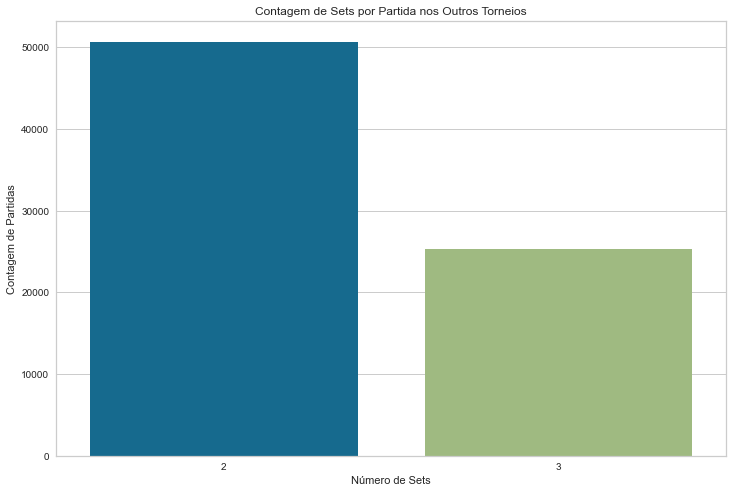

In [91]:
# Contagem de sets por partida de outros torneios
sns.countplot(data=df_other_tournaments_us, x='number_of_sets')
plt.title('Contagem de Sets por Partida nos Outros Torneios')
plt.xlabel('Número de Sets')
plt.ylabel('Contagem de Partidas')
plt.show()

In [92]:
# Drop de colunas não utilizadas
df_other_tournaments_us.drop(columns=[
    'tournament', 'concatenated_sorted', 'start_year', 'player_name_age', 'oponent_age', 'player_name', 'oponent', 'player_name_home_advantage', 'oponent_home_advantage', 'concatenated_sorted', 'start_date', 'end_date',
    'player_total_games_year', 'opponent_total_games_year', 'player_name_country', 'oponent_country', 'oponent_dob', 'player_name_dob', 'oponent_height', 'player_name_height', 'player_name_backhand',
    'player_name_forehand', 'oponent_forehand', 'oponent_backhand', 'id', 'tournament_country', 'score', 'tournament_location', 'rank_oponent', 'rank_player'
    ], inplace=True)

df_grand_slams_us.drop(columns=[
    'tournament', 'concatenated_sorted', 'start_year', 'player_name_age', 'oponent_age', 'player_name', 'oponent', 'player_name_home_advantage', 'oponent_home_advantage', 'concatenated_sorted', 'start_date', 'end_date',
    'player_total_games_year', 'opponent_total_games_year', 'player_name_country', 'oponent_country', 'oponent_dob', 'player_name_dob', 'oponent_height', 'player_name_height', 'player_name_backhand',
    'player_name_forehand', 'oponent_forehand', 'oponent_backhand', 'id', 'tournament_country', 'score', 'tournament_location', 'rank_oponent', 'rank_player'
    ], inplace=True)

C:\Users\joaop\AppData\Local\Temp\ipykernel_15956\2272783142.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_grand_slams_us.drop(columns=[


In [93]:
# daqui em diante só utilizamos os torneios à melhor de 3 sets (que só podem ficar 2-1 ou 2-0)
df_other_tournaments_us.dtypes

ground                                  object
game_round                              object
prize                                  float64
head_to_head_all_tournaments             int64
diff_num_games_year_all_tournaments      int64
number_of_sets                           int64
tournament_duration                      int64
age_difference                           int64
height_difference                      float64
total_home_advantage_players             int32
forehand_comp                            int32
backhand_comp                            int32
rank_difference                        float64
dtype: object

In [94]:
df_other_tournaments_us.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
ground,75963,4,Hard,56983,NaN,NaN,NaN,NaN,NaN,NaN,NaN
game_round,75963,5,Early Rounds,38534,NaN,NaN,NaN,NaN,NaN,NaN,NaN
prize,75963.0,NaN,NaN,NaN,301481.288061,446065.175335,0.0,15000.0,50000.0,375000.0,1400000.0
head_to_head_all_tournaments,75963.0,NaN,NaN,NaN,1.827745,2.053409,1.0,1.0,1.0,2.0,48.0
diff_num_games_year_all_tournaments,75963.0,NaN,NaN,NaN,23.703316,24.490641,0.0,7.0,17.0,33.0,201.0
number_of_sets,75963.0,NaN,NaN,NaN,2.332715,0.471188,2.0,2.0,2.0,3.0,3.0
tournament_duration,75963.0,NaN,NaN,NaN,6.719205,2.133306,-1.0,6.0,6.0,6.0,13.0
age_difference,75963.0,NaN,NaN,NaN,4.42709,3.974748,0.0,2.0,4.0,6.0,59.0
height_difference,75963.0,NaN,NaN,NaN,9.811487,7.723741,0.0,3.0,8.0,15.0,31.0
total_home_advantage_players,75963.0,NaN,NaN,NaN,0.743151,0.703024,0.0,0.0,1.0,1.0,2.0


In [95]:
# ajustar data types
df_other_tournaments_us['height_difference'] = df_other_tournaments_us['height_difference'].astype(int)

# transformar em variavel binária (quando fica 2-0 temos 0, quando fica 2-1 temos 1)
df_other_tournaments_us['number_of_sets'] = (df_other_tournaments_us['number_of_sets'] == 3).astype(int)

#### Análise de correlações

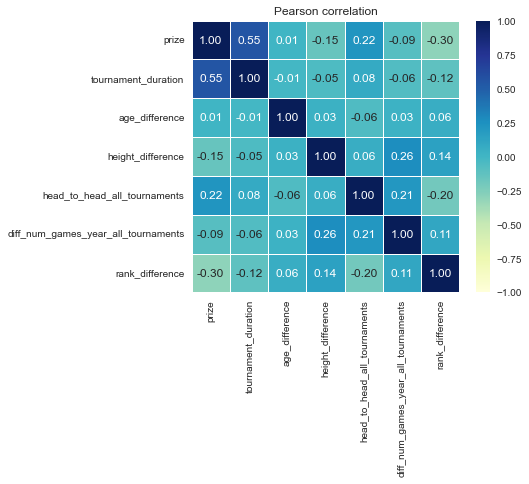

In [96]:
# Matriz de correlação para variáveis numéricas
colunas_numericas = ['prize', 'tournament_duration', 'age_difference', 'height_difference', 'head_to_head_all_tournaments', 'diff_num_games_year_all_tournaments', 'rank_difference']
fig, ax = plt.subplots(figsize=(6,5))
corr_matrix = df_other_tournaments_us[colunas_numericas].copy()
corr_matrix = corr_matrix.corr(method="pearson")
sns.heatmap(corr_matrix, vmin=-1., vmax=1., annot=True, fmt='.2f', cmap="YlGnBu", cbar=True, linewidths=0.5, ax=ax)
plt.title("Pearson correlation");

In [97]:
# Encode categorical variables to dummy variables
cols = ['ground', 'game_round']
ce_one_hot = ce.OneHotEncoder(cols = cols, use_cat_names=True)
df_other_tournaments_us = ce_one_hot.fit_transform(df_other_tournaments_us)

c:\Users\joaop\anaconda3\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version. Use is_categorical_dtype instead.
  elif pd.api.types.is_categorical(cols):


In [98]:
df_other_tournaments_us.dtypes

ground_Hard                              int64
ground_Clay                              int64
ground_Grass                             int64
ground_Carpet                            int64
game_round_Medal Rounds                  int64
game_round_Mid Rounds                    int64
game_round_Finals                        int64
game_round_Early Rounds                  int64
game_round_Qualifiers                    int64
prize                                  float64
head_to_head_all_tournaments             int64
diff_num_games_year_all_tournaments      int64
number_of_sets                           int32
tournament_duration                      int64
age_difference                           int64
height_difference                        int32
total_home_advantage_players             int32
forehand_comp                            int32
backhand_comp                            int32
rank_difference                        float64
dtype: object

In [99]:
categoricas = ['number_of_sets', 'total_home_advantage_players', 'forehand_comp', 'backhand_comp', 'ground_Carpet', 'ground_Clay', 'ground_Grass', 'ground_Hard', 'game_round_Medal Rounds', 
               'game_round_Finals', 'game_round_Mid Rounds', 'game_round_Early Rounds', 'game_round_Qualifiers'
               ]

for column in categoricas:
    df_other_tournaments_us[column] = df_other_tournaments_us[column].astype('category')

cramersv = am.CramersV(df_other_tournaments_us[categoricas]) 
cramersv.fit()

,number_of_sets,total_home_advantage_players,forehand_comp,backhand_comp,ground_Carpet,ground_Clay,ground_Grass,ground_Hard,game_round_Medal Rounds,game_round_Finals,game_round_Mid Rounds,game_round_Early Rounds,game_round_Qualifiers
number_of_sets,1.000000,0.010506,0.028683,0.017144,0.008138,0.018662,0.010021,0.010320,0.010467,0.018896,0.009121,0.007199,0.018468
total_home_advantage_players,0.010506,1.000000,0.067539,0.024849,0.064789,0.007589,0.015452,0.021819,0.019652,0.013087,0.039655,0.037544,0.022124
forehand_comp,0.028683,0.067539,1.000000,0.046848,0.136864,0.081346,0.000236,0.132862,0.009392,0.009519,0.006169,0.011266,0.002486
backhand_comp,0.017144,0.024849,0.046848,1.000000,0.051748,0.002871,0.001996,0.025432,0.015528,0.012062,0.001833,0.037863,0.039674
ground_Carpet,0.008138,0.064789,0.136864,0.051748,1.000000,0.094376,0.027501,0.333143,0.030544,0.018977,0.031700,0.028786,0.030964
ground_Clay,0.018662,0.007589,0.081346,0.002871,0.094376,1.000000,0.070211,0.850512,0.018517,0.015611,0.041516,0.005407,0.088306
ground_Grass,0.010021,0.015452,0.000236,0.001996,0.027501,0.070211,1.000000,0.247840,0.004211,0.001726,0.010618,0.027160,0.023432
ground_Hard,0.010320,0.021819,0.132862,0.025432,0.333143,0.850512,0.247840,1.000000,0.031363,0.022950,0.054946,0.016181,0.086356
game_round_Medal Rounds,0.010467,0.019652,0.009392,0.015528,0.030544,0.018517,0.004211,0.031363,1.000000,0.038457,0.152551,0.237413,0.084859
game_round_Finals,0.018896,0.013087,0.009519,0.012062,0.018977,0.015611,0.001726,0.022950,0.038457,1.000000,0.107155,0.166764,0.059607


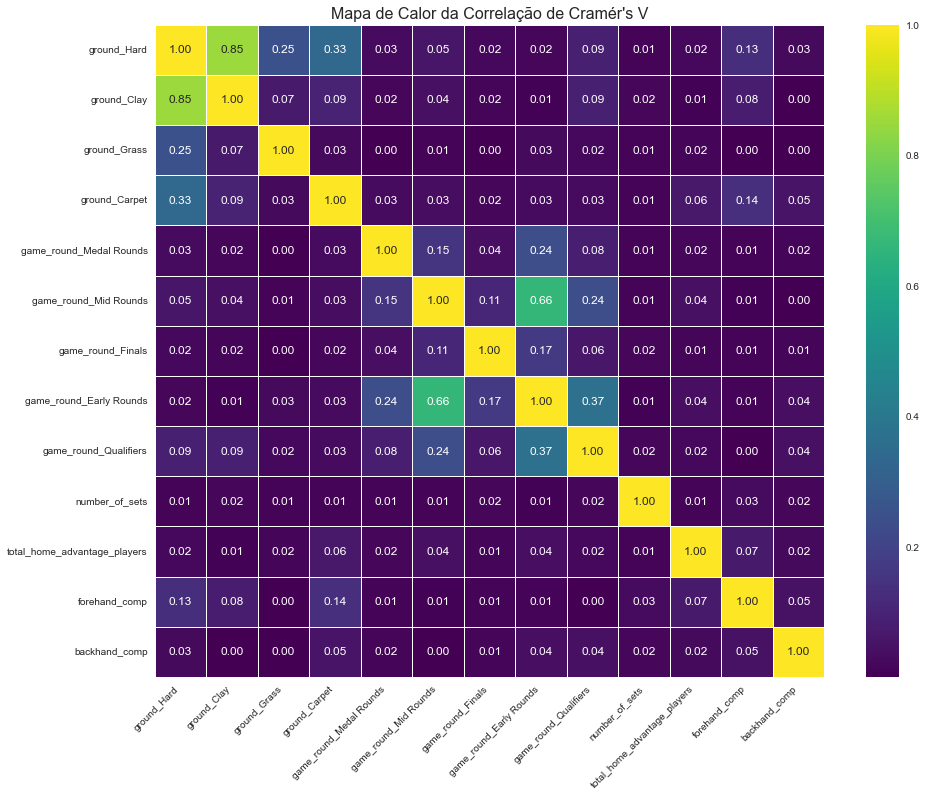

In [100]:
# Função para calcular o Cramér's V
def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x, y)
    chi2 = chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    return np.sqrt(chi2 / (n * (min(confusion_matrix.shape) - 1)))

# Calcular a matriz de Cramér's V
categoricas = df_other_tournaments_us.select_dtypes(include='category').columns.tolist()
n = len(categoricas)
cramers_v_matrix = np.zeros((n, n))

for i in range(n):
    for j in range(n):
        if i == j:
            cramers_v_matrix[i, j] = 1.0
        elif i < j:
            cramers_v_matrix[i, j] = cramers_v(df_other_tournaments_us[categoricas[i]], df_other_tournaments_us[categoricas[j]])
            cramers_v_matrix[j, i] = cramers_v_matrix[i, j]

cramers_v_df = pd.DataFrame(cramers_v_matrix, index=categoricas, columns=categoricas)

# Plotar o mapa de calor com ajustes
plt.figure(figsize=(15, 12))
ax = sns.heatmap(cramers_v_df, annot=True, fmt=".2f", cmap="viridis", cbar=True, linewidths=0.5)
plt.title("Mapa de Calor da Correlação de Cramér's V", fontsize=16)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')
ax.set_yticklabels(ax.get_yticklabels(), rotation=0, horizontalalignment='right')
plt.show()

In [101]:
# Verificar o número de observações em ground_Clay para perceber a elevada correlação (acontece pelo elevado nr de torneios em hard ground)
print(df_other_tournaments_us['ground_Clay'].value_counts())
print(df_other_tournaments_us['ground_Hard'].value_counts())

# Verificar para early rounds e mid rounds (elevado nr de early rounds e relação mais direta entre os dois tipos de ronda do torneio)
print(df_other_tournaments_us['game_round_Early Rounds'].value_counts())
print(df_other_tournaments_us['game_round_Mid Rounds'].value_counts())

0    61214
1    14749
Name: ground_Clay, dtype: int64
1    56983
0    18980
Name: ground_Hard, dtype: int64
1    38534
0    37429
Name: game_round_Early Rounds, dtype: int64
0    53305
1    22658
Name: game_round_Mid Rounds, dtype: int64


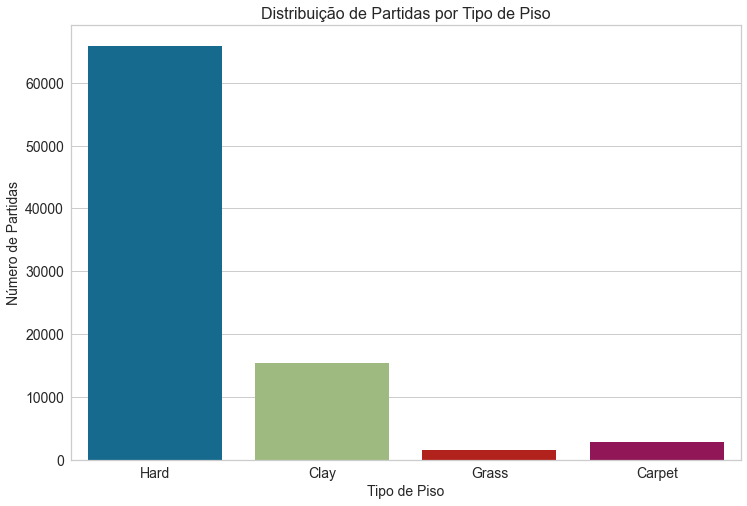

In [102]:
sns.countplot(x='ground', data=df_filtrado_j)
plt.title('Distribuição de Partidas por Tipo de Piso', fontsize=16)
plt.xlabel('Tipo de Piso', fontsize=14)
plt.ylabel('Número de Partidas', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

In [103]:
### VIF para verificar a multicolinearidade
def compute_vif(considered_features):
    
    X = df_other_tournaments_us[considered_features]
    # o cálculo requer a utilização de uma constante
    X['intercept'] = 1
    
    # criar o df para armazenar os valores do vif
    vif = pd.DataFrame()
    vif["Variable"] = X.columns
    vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    vif = vif[vif['Variable']!='intercept']
    return vif

considered_features = df_other_tournaments_us.select_dtypes(include=['int32', 'int64', 'float64']).columns

# computar o vif 
compute_vif(considered_features).sort_values('VIF', ascending=False)

C:\Users\joaop\AppData\Local\Temp\ipykernel_15956\934787406.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['intercept'] = 1


,Variable,VIF
0,prize,1.635115
3,tournament_duration,1.439548
1,head_to_head_all_tournaments,1.156359
6,rank_difference,1.153649
2,diff_num_games_year_all_tournaments,1.140428
5,height_difference,1.104325
4,age_difference,1.009633


In [104]:
df_other_tournaments_us.dtypes

ground_Hard                            category
ground_Clay                            category
ground_Grass                           category
ground_Carpet                          category
game_round_Medal Rounds                category
game_round_Mid Rounds                  category
game_round_Finals                      category
game_round_Early Rounds                category
game_round_Qualifiers                  category
prize                                   float64
head_to_head_all_tournaments              int64
diff_num_games_year_all_tournaments       int64
number_of_sets                         category
tournament_duration                       int64
age_difference                            int64
height_difference                         int32
total_home_advantage_players           category
forehand_comp                          category
backhand_comp                          category
rank_difference                         float64
dtype: object

In [105]:
# Selecionar todas as colunas categóricas 
binary_categorical_columns = df_other_tournaments_us.select_dtypes(include='category').columns

# Converter todas as colunas categóricas para int64
df_other_tournaments_us[binary_categorical_columns] = df_other_tournaments_us[binary_categorical_columns].astype('int64')

In [106]:
df_other_tournaments_us.describe(include='all').T

,count,mean,std,min,25%,50%,75%,max
ground_Hard,75963.0,0.750142,0.432934,0.0,1.0,1.0,1.0,1.0
ground_Clay,75963.0,0.194160,0.395555,0.0,0.0,0.0,0.0,1.0
ground_Grass,75963.0,0.020049,0.140170,0.0,0.0,0.0,0.0,1.0
ground_Carpet,75963.0,0.035649,0.185415,0.0,0.0,0.0,0.0,1.0
game_round_Medal Rounds,75963.0,0.051907,0.221840,0.0,0.0,0.0,0.0,1.0
game_round_Mid Rounds,75963.0,0.298277,0.457505,0.0,0.0,0.0,1.0,1.0
game_round_Finals,75963.0,0.026302,0.160034,0.0,0.0,0.0,0.0,1.0
game_round_Early Rounds,75963.0,0.507273,0.499950,0.0,0.0,1.0,1.0,1.0
game_round_Qualifiers,75963.0,0.116241,0.320516,0.0,0.0,0.0,0.0,1.0
prize,75963.0,301481.288061,446065.175335,0.0,15000.0,50000.0,375000.0,1400000.0


### Tratamento de outliers das variáveis geradas através de feature engineering

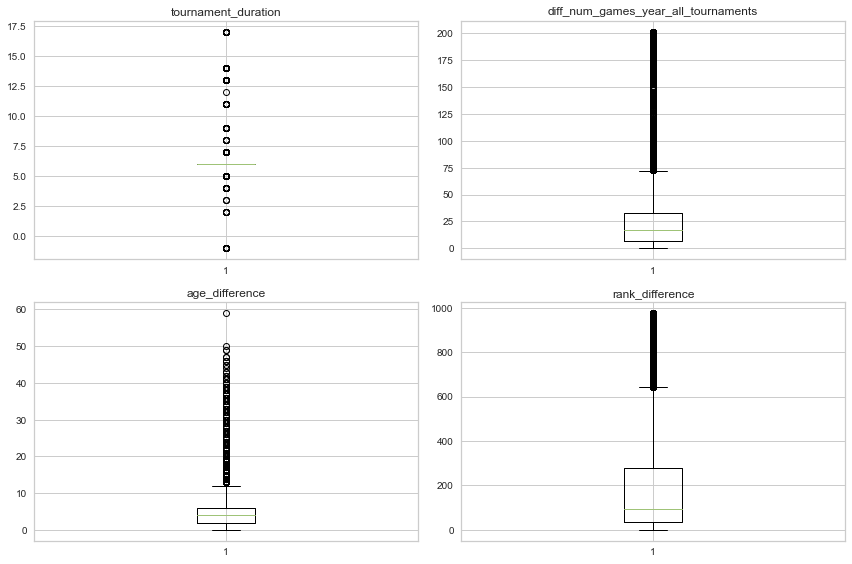

In [107]:
# Lista de variáveis numéricas
vars = ['tournament_duration', 'diff_num_games_year_all_tournaments', 'age_difference', 'rank_difference']

# Configurar o tamanho da figura
plt.figure(figsize=(12, 8))

# Criar um subplot para cada variável
for i, var in enumerate(vars, 1):
    plt.subplot(2, 2, i)  # 2 linhas, 2 colunas, índice i
    plt.boxplot(df_filtrado_j[var].dropna())
    plt.title(var)

plt.tight_layout()
plt.show()

In [108]:
# como não há praticamente variação na feature da duração dos torneios - são praticamente sempre 6 dias, optamos por removê-la
df_other_tournaments_us.drop(columns=[
    'tournament_duration'
    ], inplace=True)

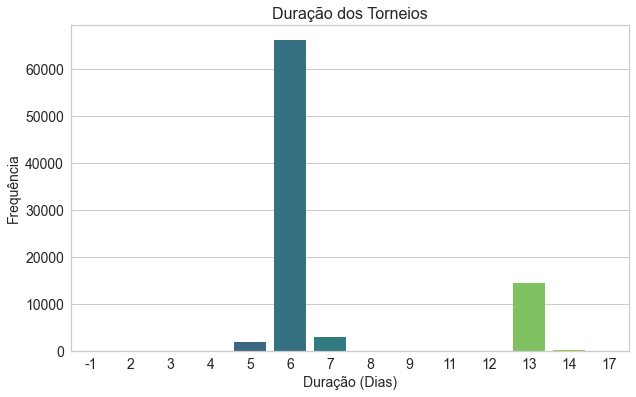

In [109]:
# Contar a frequência de cada duração de torneio
duration_counts = df_filtrado_j['tournament_duration'].value_counts().reset_index()
duration_counts.columns = ['tournament_duration', 'frequency']

# Plotar o gráfico de barras
plt.figure(figsize=(10, 6))
sns.barplot(data=duration_counts, x='tournament_duration', y='frequency', palette='viridis')

# Ajustar o título e rótulos
plt.title('Duração dos Torneios', fontsize=16)
plt.xlabel('Duração (Dias)', fontsize=14)
plt.ylabel('Frequência', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.show()

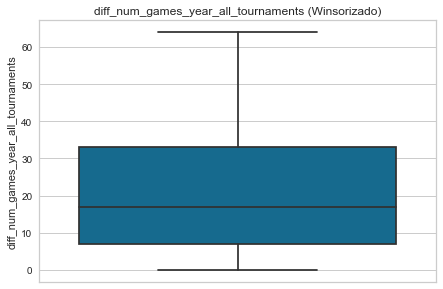

In [110]:
# Lista de variáveis numéricas
numerical_vars = ['diff_num_games_year_all_tournaments']

# Aplicar winsorização
for var in numerical_vars:
    df_filtrado_j[var] = stats.mstats.winsorize(df_filtrado_j[var], limits=[0, 0.05])

# Configurar o tamanho da figura
plt.figure(figsize=(12, 8))

# Criar um subplot para cada variável após winsorização
for i, var in enumerate(numerical_vars, 1):
    plt.subplot(2, 2, i)  # 2 linhas, 2 colunas, índice i
    sns.boxplot(y=df_filtrado_j[var])
    plt.title(f'{var} (Winsorizado)')

plt.tight_layout()
plt.show()

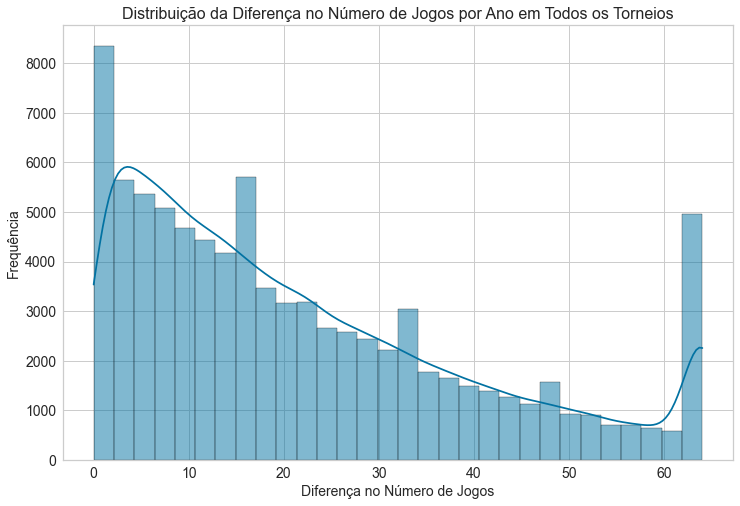

In [111]:
sns.histplot(data=df_filtrado_j, x='diff_num_games_year_all_tournaments', bins=30, kde=True)
plt.title('Distribuição da Diferença no Número de Jogos por Ano em Todos os Torneios', fontsize=16)
plt.xlabel('Diferença no Número de Jogos', fontsize=14)
plt.ylabel('Frequência', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

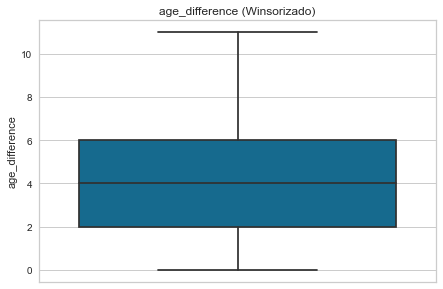

In [112]:
# Lista de variáveis numéricas
numerical_vars = ['age_difference']

# Aplicar winsorização
for var in numerical_vars:
    df_filtrado_j[var] = stats.mstats.winsorize(df_filtrado_j[var], limits=[0, 0.05])

# Configurar o tamanho da figura
plt.figure(figsize=(12, 8))

# Criar um subplot para cada variável após winsorização
for i, var in enumerate(numerical_vars, 1):
    plt.subplot(2, 2, i)  # 2 linhas, 2 colunas, índice i
    sns.boxplot(y=df_filtrado_j[var])
    plt.title(f'{var} (Winsorizado)')

plt.tight_layout()
plt.show()

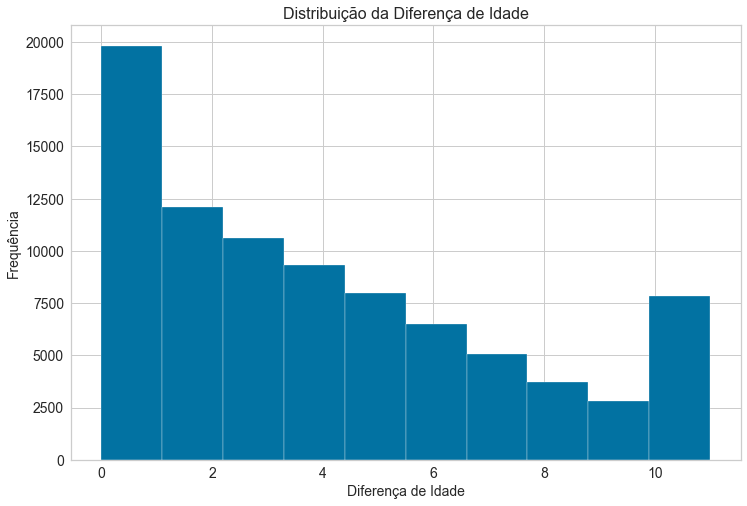

In [113]:
# Histograma para 'age_difference'
plt.hist(data=df_filtrado_j, x='age_difference', edgecolor='white')
plt.title('Distribuição da Diferença de Idade', fontsize=16)
plt.xlabel('Diferença de Idade', fontsize=14)
plt.ylabel('Frequência', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

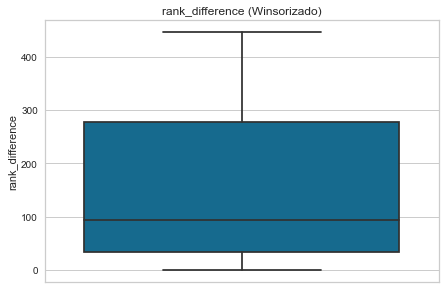

In [114]:
# Lista de variáveis numéricas
numerical_vars = ['rank_difference']

# Aplicar winsorização
for var in numerical_vars:
    df_filtrado_j[var] = stats.mstats.winsorize(df_filtrado_j[var], limits=[0, 0.15])

# Configurar o tamanho da figura
plt.figure(figsize=(12, 8))

# Criar um subplot para cada variável após winsorização
for i, var in enumerate(numerical_vars, 1):
    plt.subplot(2, 2, i)  # 2 linhas, 2 colunas, índice i
    sns.boxplot(y=df_filtrado_j[var])
    plt.title(f'{var} (Winsorizado)')

plt.tight_layout()
plt.show()

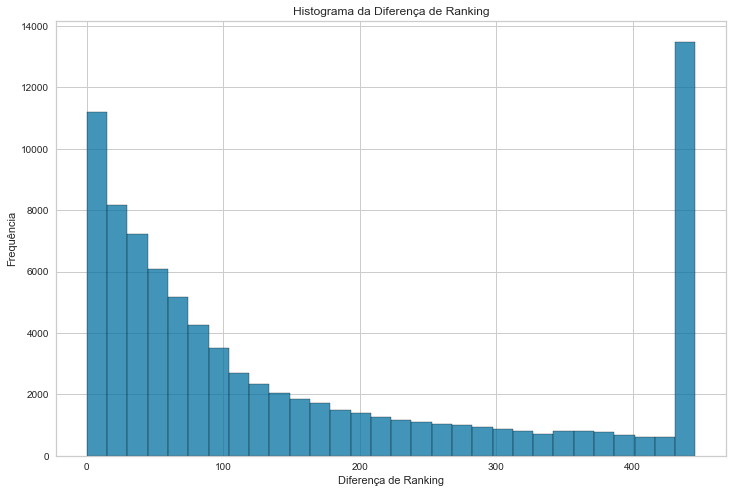

In [115]:
sns.histplot(df_filtrado_j['rank_difference'], bins=30, kde=False)
plt.title('Histograma da Diferença de Ranking')
plt.xlabel('Diferença de Ranking')
plt.ylabel('Frequência')
plt.show()

In [116]:
df_other_tournaments_us.describe(include='all').T

,count,mean,std,min,25%,50%,75%,max
ground_Hard,75963.0,0.750142,0.432934,0.0,1.0,1.0,1.0,1.0
ground_Clay,75963.0,0.194160,0.395555,0.0,0.0,0.0,0.0,1.0
ground_Grass,75963.0,0.020049,0.140170,0.0,0.0,0.0,0.0,1.0
ground_Carpet,75963.0,0.035649,0.185415,0.0,0.0,0.0,0.0,1.0
game_round_Medal Rounds,75963.0,0.051907,0.221840,0.0,0.0,0.0,0.0,1.0
game_round_Mid Rounds,75963.0,0.298277,0.457505,0.0,0.0,0.0,1.0,1.0
game_round_Finals,75963.0,0.026302,0.160034,0.0,0.0,0.0,0.0,1.0
game_round_Early Rounds,75963.0,0.507273,0.499950,0.0,0.0,1.0,1.0,1.0
game_round_Qualifiers,75963.0,0.116241,0.320516,0.0,0.0,0.0,0.0,1.0
prize,75963.0,301481.288061,446065.175335,0.0,15000.0,50000.0,375000.0,1400000.0


## Modeling and evaluation

### Treino e teste split

Counter({0: 40551, 1: 20219})


<AxesSubplot:xlabel='y', ylabel='count'>

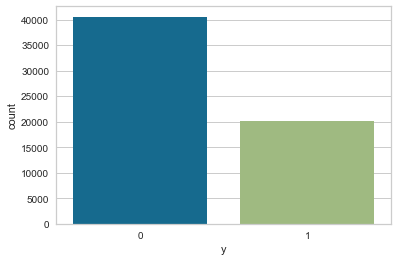

In [117]:
# Target
y = df_other_tournaments_us['number_of_sets']

# Split em sets de treino e teste
X_train, X_test, y_train2, y_test = train_test_split(df_other_tournaments_us, y, test_size=0.20, stratify=y, random_state=123)

# Remover o target do training set
X_train_temp = X_train.drop(['number_of_sets'], axis=1)
X_test_temp = X_test.drop(['number_of_sets'], axis=1)

# Ver a distribuição do target no training set
print(collections.Counter(y_train2))
fig, ax = plt.subplots(figsize=(6,4))
sns.countplot(x="y", data=pd.DataFrame(data={'y':y_train2}), ax=ax)

#### Oversampling para corrigir desbalanceamento no dataset

Counter({1: 40551, 0: 40551})


<AxesSubplot:xlabel='y', ylabel='count'>

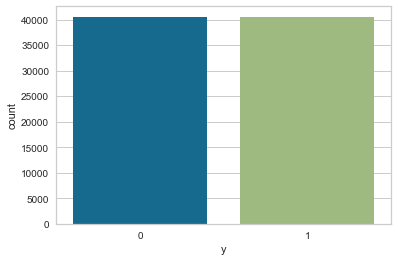

In [118]:
# Aplicar SMOTE para balancear o dataset
smote = SMOTE(random_state=123)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_temp, y_train2)

# Normalizar os dados com minmax 
scaler = MinMaxScaler(feature_range=(0, 1))
X_train_scaled2 = scaler.fit_transform(X_train_resampled)
X_test_scaled = scaler.transform(X_test_temp)

# Ver a distribuição do target no training set
print(collections.Counter(y_train_resampled))
fig, ax = plt.subplots(figsize=(6,4))
sns.countplot(x="y", data=pd.DataFrame(data={'y':y_train_resampled}), ax=ax)

#### Definição de funções utilizadas na fase de modelação

In [119]:
# Função utilizada para criar o dataset com as métricas
def performanceMetricsDF(metricsObj, yTrain, yPredTrain, yTest, yPredTest):
  measures_list = ['ACCURACY','PRECISION', 'RECALL','F1 SCORE']
  train_results = [metricsObj.accuracy_score(yTrain, yPredTrain),
                metricsObj.precision_score(yTrain, yPredTrain),
                metricsObj.recall_score(yTrain, yPredTrain),
                metricsObj.f1_score(yTrain, yPredTrain)
                ]
  test_results = [metricsObj.accuracy_score(yTest, yPredTest),
               metricsObj.precision_score(yTest, yPredTest),
               metricsObj.recall_score(yTest, yPredTest),
               metricsObj.f1_score(yTest, yPredTest)
               ]
  resultsDF = pd.DataFrame({'Measure': measures_list, 'Train': train_results, 'Test':test_results})
  return(resultsDF)

# Confusion matrix - De https://github.com/DTrimarchi10/confusion_matrix/blob/master/cf_matrix.py
def make_confusion_matrix(cf,
                          group_names=None,
                          categories='auto',
                          count=True,
                          percent=True,
                          cbar=True,
                          xyticks=True,
                          xyplotlabels=True,
                          sum_stats=True,
                          figsize=None,
                          cmap='Blues',
                          title=None):
    '''
    This function will make a pretty plot of an sklearn Confusion Matrix cm using a Seaborn heatmap visualization.
    Arguments
    ---------
    cf:            confusion matrix to be passed in
    group_names:   List of strings that represent the labels row by row to be shown in each square.
    categories:    List of strings containing the categories to be displayed on the x,y axis. Default is 'auto'
    count:         If True, show the raw number in the confusion matrix. Default is True.
    normalize:     If True, show the proportions for each category. Default is True.
    cbar:          If True, show the color bar. The cbar values are based off the values in the confusion matrix.
                   Default is True.
    xyticks:       If True, show x and y ticks. Default is True.
    xyplotlabels:  If True, show 'True Label' and 'Predicted Label' on the figure. Default is True.
    sum_stats:     If True, display summary statistics below the figure. Default is True.
    figsize:       Tuple representing the figure size. Default will be the matplotlib rcParams value.
    cmap:          Colormap of the values displayed from matplotlib.pyplot.cm. Default is 'Blues'
                   See http://matplotlib.org/examples/color/colormaps_reference.html
                   
    title:         Title for the heatmap. Default is None.
    '''

    blanks = ['' for i in range(cf.size)]

    if group_names and len(group_names)==cf.size:
        group_labels = ["{}\n".format(value) for value in group_names]
    else:
        group_labels = blanks

    if count:
        group_counts = ["{0:0.0f}\n".format(value) for value in cf.flatten()]
    else:
        group_counts = blanks

    if percent:
        group_percentages = ["{0:.2%}".format(value) for value in cf.flatten()/np.sum(cf)]
    else:
        group_percentages = blanks

    box_labels = [f"{v1}{v2}{v3}".strip() for v1, v2, v3 in zip(group_labels,group_counts,group_percentages)]
    box_labels = np.asarray(box_labels).reshape(cf.shape[0],cf.shape[1])

    if sum_stats:
        accuracy  = np.trace(cf) / float(np.sum(cf))
        if len(cf)==2:
            precision = cf[1,1] / sum(cf[:,1])
            recall    = cf[1,1] / sum(cf[1,:])
            f1_score  = 2*precision*recall / (precision + recall)
            stats_text = "\n\nAccuracy={:0.3f}\nPrecision={:0.3f}\nRecall={:0.3f}\nF1 Score={:0.3f}".format(
                accuracy,precision,recall,f1_score)
        else:
            stats_text = "\n\nAccuracy={:0.3f}".format(accuracy)
    else:
        stats_text = ""

    if figsize==None:
        figsize = plt.rcParams.get('figure.figsize')

    if xyticks==False:
        categories=False

    plt.figure(figsize=figsize)
    ax = sns.heatmap(cf,annot=box_labels, fmt="",cmap=cmap,cbar=cbar,xticklabels=categories,yticklabels=categories)

    if xyplotlabels:
        plt.ylabel('True label')
        plt.xlabel('Predicted label' + stats_text)
    else:
        plt.xlabel(stats_text)
    
    if title:
        plt.title(title)

In [120]:
# Definimos a regressão logística como MVM (minimum viable model)
logreg_model = LogisticRegression(C=0.1, penalty='l2', solver='liblinear', random_state=12)

# Treinar o modelo com os dados balanceados
logreg_model.fit(X_train_scaled2, y_train_resampled)

# Previsões nos sets de treino e teste
y_pred_train_logreg = logreg_model.predict(X_train_scaled2)
y_pred_test_logreg = logreg_model.predict(X_test_scaled)

# Avaliar a performance
resultsDF_logreg = performanceMetricsDF(metrics, y_train_resampled, y_pred_train_logreg, y_test, y_pred_test_logreg)
resultsDF_logreg


,Measure,Train,Test
0,ACCURACY,0.674940,0.655433
1,PRECISION,0.903848,0.371429
2,RECALL,0.391532,0.051434
3,F1 SCORE,0.546381,0.090356


In [121]:
# Comentado porque demora cerca de 7 min a correr 

#warnings.filterwarnings('ignore')

## Modelo base
#logreg_model = LogisticRegression(random_state=100)

## Grid de hiperparametros para fazer a pesquisa
#param_grid = {
#    'C': [0.1, 1, 10],
#    'penalty': ['l1', 'l2'],
#    'solver': ['liblinear', 'saga']
#}

#random_search_logreg = RandomizedSearchCV(logreg_model, param_distributions=param_grid, scoring='recall', cv=5, n_iter=10, random_state=42)
#random_search_logreg.fit(X_train_scaled2, y_train_resampled)

#print("Tuned Hyperparameters: ", random_search_logreg.best_params_)

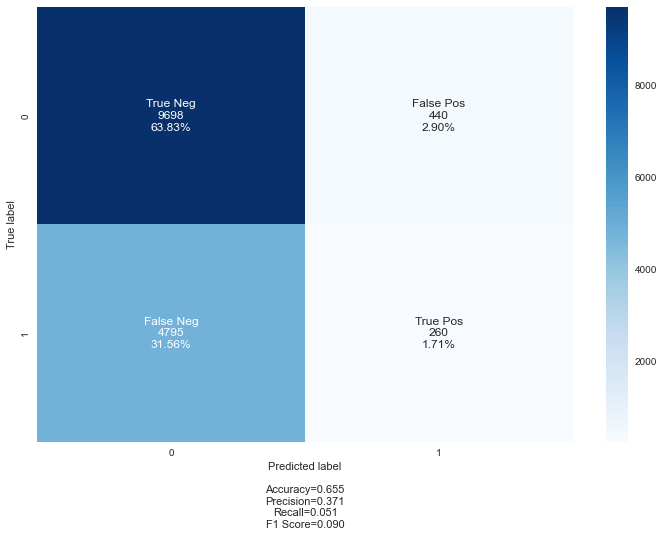

In [122]:
# Confusion matrix
cf_logreg = metrics.confusion_matrix(y_test,y_pred_test_logreg)  # PARA VER TREINO y_train_resampled, y_pred_train_logreg
labels_logreg = ['True Neg','False Pos','False Neg','True Pos']
categories_logreg = ['0', '1']
make_confusion_matrix(cf_logreg, 
                      group_names=labels_logreg,
                      categories=categories_logreg, 
                      cmap='Blues')

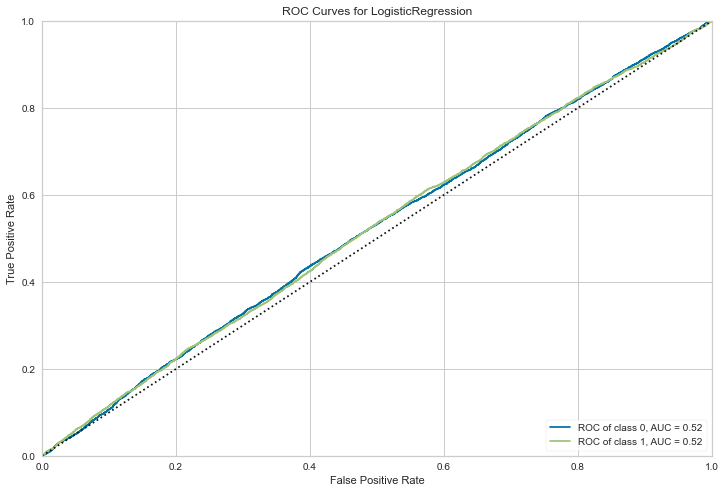

<AxesSubplot:title={'center':'ROC Curves for LogisticRegression'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

In [123]:
# ROC curve
logreg_visualizer = ROCAUC(logreg_model, classes=['0','1'], macro=False, micro=False)
logreg_visualizer.fit(X_train_scaled2, y_train_resampled)
logreg_visualizer.score(X_test_scaled, y_test)
logreg_visualizer.show()

#### XGBoost 

In [124]:
# XGBoost
xgb_model = xgb.XGBClassifier(objective='binary:logistic', n_estimators=200, max_depth=4, learning_rate=0.3, 
                              subsample=0.8, colsample_bytree=0.8, min_child_weight=3, random_state=100)

# Treinar o modelo com os dados balanceados
xgb_model.fit(X_train_scaled2, y_train_resampled)

# Previsões nos sets de treino e teste
y_pred_train_XGB = xgb_model.predict(X_train_scaled2)
y_pred_test_XGB = xgb_model.predict(X_test_scaled)

# Avaliar a performance
resultsDF_XGB = performanceMetricsDF(metrics, y_train_resampled, y_pred_train_XGB, y_test, y_pred_test_XGB)
resultsDF_XGB

,Measure,Train,Test
0,ACCURACY,0.714557,0.638584
1,PRECISION,0.874424,0.358257
2,RECALL,0.501073,0.109001
3,F1 SCORE,0.637079,0.167147


In [125]:
# Comentado por demorar cerca de 5m a correr

# Grid search para tuning dos params
#warnings.filterwarnings('ignore')

#xgb_model = xgb.XGBClassifier(objective='binary:logistic', random_state=100)

# grid de parametros
#param_grid = {
#    'learning_rate': [0.05, 0.1, 0.2, 0.3],
#    'n_estimators': [50, 100, 150, 200],
#    'max_depth': [2, 3, 4],
#    'min_child_weight': [1, 2, 3, 4]
#}

#grid_search_xgb = GridSearchCV(xgb_model, param_grid=param_grid, scoring='roc_auc', cv=5)
#grid_search_xgb.fit(X_train_scaled2, y_train_resampled)

#print("Tuned Hyperparameters: ", grid_search_xgb.best_params_)

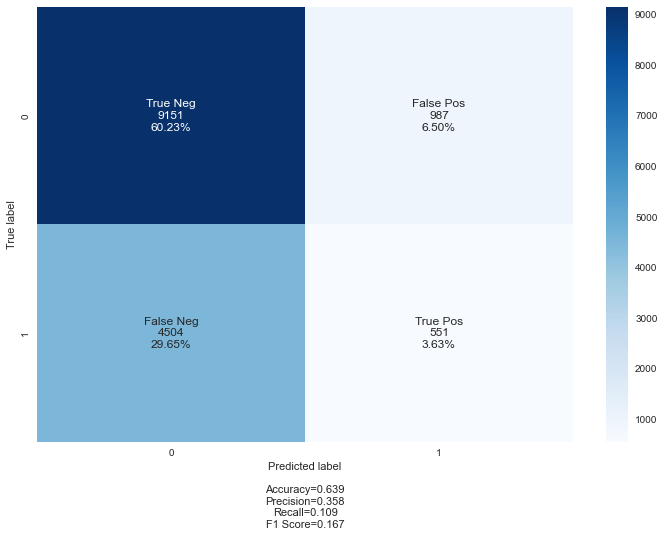

In [126]:
# Confusion matrix
cf_xgb = metrics.confusion_matrix(y_test,y_pred_test_XGB)
labels_xgb = ['True Neg','False Pos','False Neg','True Pos']
categories_xgb = ['0', '1']
make_confusion_matrix(cf_xgb, 
                      group_names=labels_xgb,
                      categories=categories_xgb, 
                      cmap='Blues')

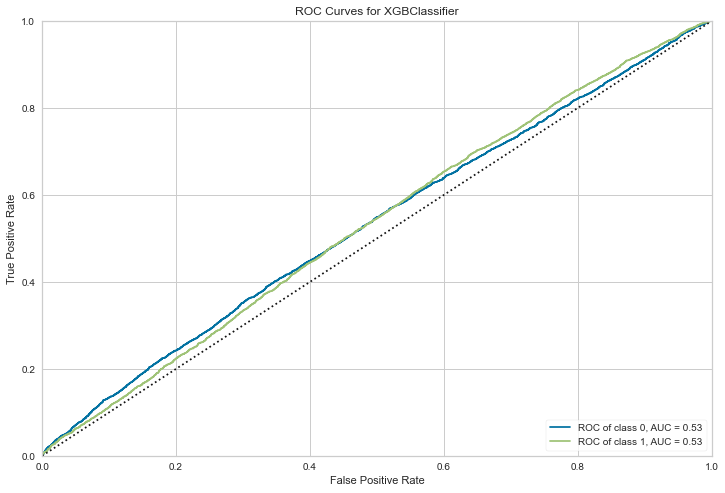

<AxesSubplot:title={'center':'ROC Curves for XGBClassifier'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

In [127]:
# ROC curve
XGB_visualizer = ROCAUC(xgb_model, classes=['0','1'], macro=False, micro=False)
XGB_visualizer.fit(X_train_scaled2, y_train2)
XGB_visualizer.score(X_test_scaled, y_test)
XGB_visualizer.show()

In [128]:
# Feature importance
importances = pd.DataFrame({'Feature':X_train_resampled.columns, 'Importance':np.round(xgb_model.feature_importances_, 3)})
importances = importances.sort_values('Importance',ascending=False).set_index('Feature')

# Tabela com a feature importance
print(importances)

                                     Importance
Feature                                        
game_round_Qualifiers                     0.191
game_round_Mid Rounds                     0.158
game_round_Medal Rounds                   0.135
game_round_Early Rounds                   0.099
ground_Clay                               0.091
game_round_Finals                         0.073
ground_Grass                              0.068
ground_Carpet                             0.042
ground_Hard                               0.034
total_home_advantage_players              0.023
forehand_comp                             0.018
height_difference                         0.017
backhand_comp                             0.016
prize                                     0.009
rank_difference                           0.007
age_difference                            0.006
diff_num_games_year_all_tournaments       0.006
head_to_head_all_tournaments              0.006


#### MLP Classifier 

In [129]:
# MLP 
mlp_model = MLPClassifier(hidden_layer_sizes=(100, ), activation='relu', solver='adam', alpha=0.0001, 
                      learning_rate='constant', learning_rate_init=0.05, max_iter=50, random_state=12)

# Treinar o modelo com os dados balanceados
mlp_model.fit(X_train_scaled2, y_train_resampled)

# Previsões nos sets de treino e teste
y_pred_train_MLP = mlp_model.predict(X_train_scaled2)
y_pred_test_MLP = mlp_model.predict(X_test_scaled)

# Avaliar a performance
resultsDF_MLP = performanceMetricsDF(metrics, y_train_resampled, y_pred_train_MLP, y_test, y_pred_test_MLP)
resultsDF_MLP

,Measure,Train,Test
0,ACCURACY,0.675754,0.641743
1,PRECISION,0.830566,0.359827
2,RECALL,0.441592,0.098516
3,F1 SCORE,0.576613,0.154682


In [130]:
### Comentado porque demora cerca de 1h3min a correr 
# Grid search CV

#warnings.filterwarnings('ignore')

# Modelo base
#mlp_model = MLPClassifier(hidden_layer_sizes=(100, ), activation='relu', solver='adam', alpha=0.0001, 
#                          learning_rate='constant', learning_rate_init=0.001, max_iter=200, random_state=12)

# grid de hiperparametros
#param_grid = {
#    'learning_rate_init': [0.05, 0.1, 0.2, 0.3],
#    'max_iter': [50, 100, 150, 200],
#    'alpha': [0.0001, 0.001, 0.01],
#    'hidden_layer_sizes': [(50,), (100,), (150,)]
#}

# Grid Search CV com recurso à grid definida antes
#grid_search_mlp = GridSearchCV(mlp_model, param_grid=param_grid, scoring='roc_auc', cv=5)
#grid_search_mlp.fit(X_train_scaled2, y_train_resampled)

#print("Tuned Hyperparameters: ", grid_search_mlp.best_params_)

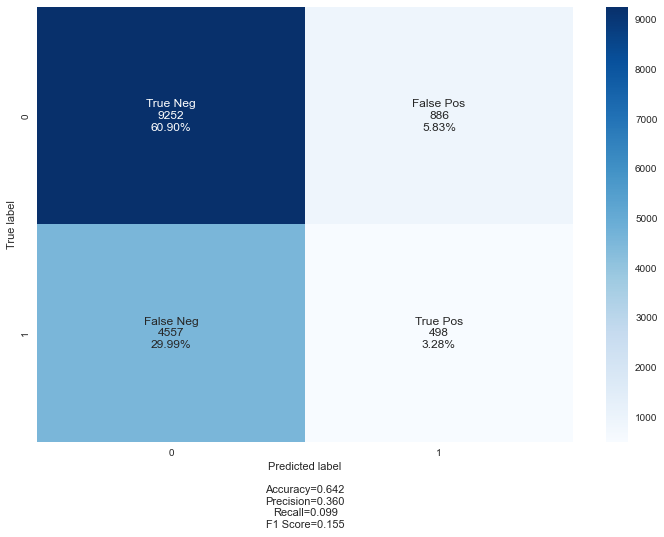

In [131]:
# Show the confusion matrix
cf_MLP = metrics.confusion_matrix(y_test,y_pred_test_MLP)
labels_MLP = ['True Neg','False Pos','False Neg','True Pos']
categories_MLP = ['0', '1']
make_confusion_matrix(cf_MLP, 
                      group_names=labels_MLP,
                      categories=categories_MLP, 
                      cmap='Blues')

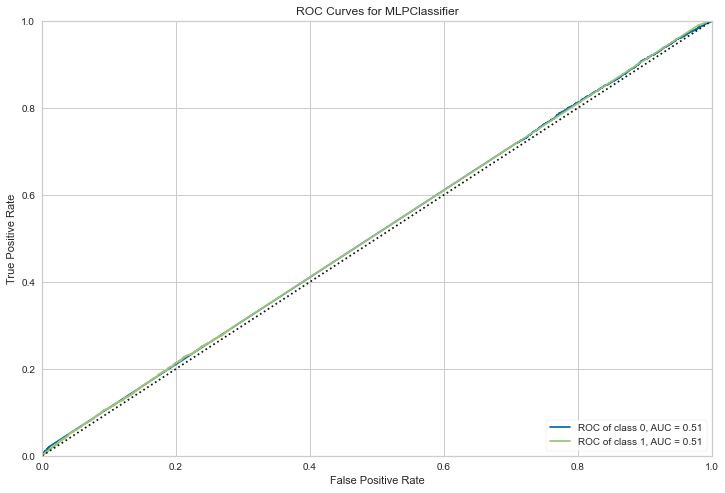

<AxesSubplot:title={'center':'ROC Curves for MLPClassifier'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

In [132]:
# ROC curve
MLP_visualizer = ROCAUC(mlp_model, classes=['0','1'], macro=False, micro=False)
MLP_visualizer.fit(X_train_scaled2, y_train2)
MLP_visualizer.score(X_test_scaled, y_test)
MLP_visualizer.show()

In [133]:
# Feature importance
importances = pd.DataFrame({'Feature': X_train_resampled.columns, 'Importance': np.abs(mlp_model.coefs_[0]).mean(axis=1)})
importances = importances.sort_values('Importance', ascending=False).set_index('Feature')

print(importances)

                                     Importance
Feature                                        
head_to_head_all_tournaments           0.223776
ground_Hard                            0.222751
game_round_Mid Rounds                  0.222173
game_round_Early Rounds                0.204469
age_difference                         0.193392
game_round_Finals                      0.187946
game_round_Medal Rounds                0.187224
ground_Carpet                          0.180417
ground_Clay                            0.176170
forehand_comp                          0.156128
game_round_Qualifiers                  0.155837
backhand_comp                          0.155667
diff_num_games_year_all_tournaments    0.152368
ground_Grass                           0.152261
height_difference                      0.149559
total_home_advantage_players           0.136043
rank_difference                        0.107279
prize                                  0.087895


#### Random Forest

In [134]:
rf = RandomForestClassifier(max_depth=8, min_samples_split=2, n_estimators=100, random_state=100)
rf.fit(X_train_scaled2, y_train_resampled)

# Predict y for X_train and X_test
y_pred_train_RF = rf.predict(X_train_scaled2) 
y_pred_test_RF = rf.predict(X_test_scaled) 

# metrics
resultsDF_RF = performanceMetricsDF(metrics, y_train_resampled, y_pred_train_RF, y_test, y_pred_test_RF)
resultsDF_RF

,Measure,Train,Test
0,ACCURACY,0.679453,0.625485
1,PRECISION,0.777812,0.368530
2,RECALL,0.502429,0.176063
3,F1 SCORE,0.610503,0.238286


In [135]:
# Comentado porque demora cerca de 11m a correr

# Grid search to hypertune the model
#warnings.filterwarnings('ignore')

# Define the hyperparameter grid to search
#param_grid = {
#    'n_estimators': [10, 20, 30, 40, 80, 100],
#    'max_depth': [2, 3, 4, 6, 8],
#    'min_samples_split': [2, 4, 6, 10, 20]
#}

# Create a Random Forest classifier object
#rf_clf = RandomForestClassifier(random_state=42)

# Perform a Grid Search CV using the hyperparameter grid
#grid_search_rf = GridSearchCV(rf_clf, param_grid=param_grid, scoring='roc_auc', cv=5)
#grid_search_rf.fit(X_train_scaled2, y_train_resampled)

# Print the best hyperparameters found
#print("Tuned Hyperparameters :", grid_search_rf.best_params_)

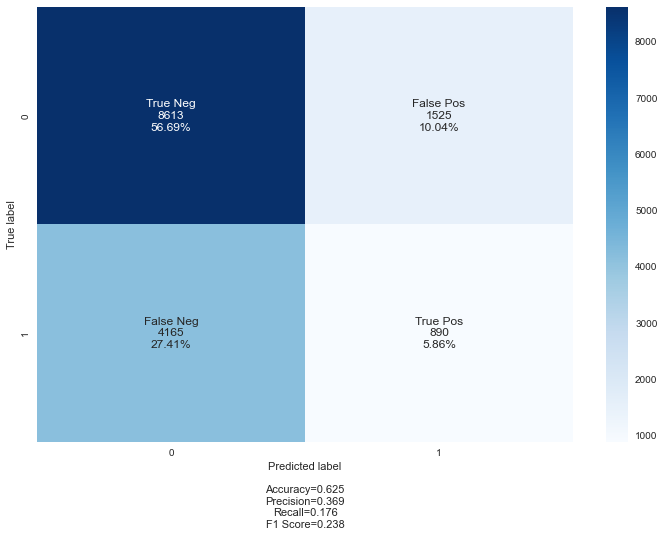

In [136]:
# Show the confusion matrix
cf_RF = metrics.confusion_matrix(y_test, y_pred_test_RF)
labels_RF = ['True Neg','False Pos','False Neg','True Pos']
categories_RF = ['0', '1']
make_confusion_matrix(cf_RF, 
                      group_names=labels_RF,
                      categories=categories_RF, 
                      cmap='Blues')

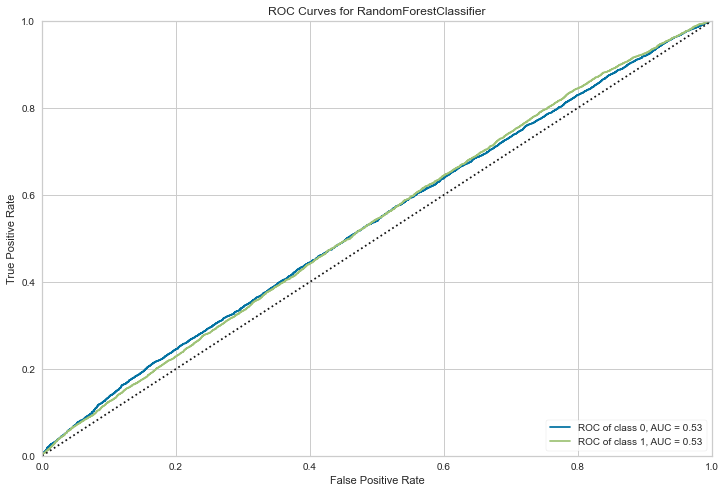

<AxesSubplot:title={'center':'ROC Curves for RandomForestClassifier'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

In [137]:
# ROC curve
RF_visualizer = ROCAUC(rf, classes=['0','1'], macro=False, micro=False)
RF_visualizer.fit(X_train_scaled2, y_train2)
RF_visualizer.score(X_test_scaled, y_test)
RF_visualizer.show()

### Cross validation (c/ oversampling)

In [138]:
# Função utilizada para criar o dataset com as métricas
# Definir o target
y = df_other_tournaments_us['number_of_sets']

# Remover o target do conjunto de dados
X = df_other_tournaments_us.drop(['number_of_sets'], axis=1)

# Aplicar SMOTE para balancear o conjunto de dados
smote = SMOTE(random_state=123)
X_resampled, y_resampled = smote.fit_resample(X, y)

# Normalizar os dados com MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
X_scaled = scaler.fit_transform(X_resampled)

#### Logistic regression

In [139]:
# MVM
model = LogisticRegression(C=0.1, penalty='l2', solver='liblinear', random_state=12)

# Definir o número de folds para a validação cruzada
num_folds = 10

# Criar um objeto StratifiedKFold para dividir os dados (preservando a distribuição das classes)
kf = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=123)

# Lista para armazenar os resultados de métricas de cada fold
all_results = []

# Loop sobre cada fold
for train_index, test_index in kf.split(X_scaled, y_resampled):
    X_train_fold, X_test_fold = X_scaled[train_index], X_scaled[test_index]
    y_train_fold, y_test_fold = y_resampled[train_index], y_resampled[test_index]
    
    # Treinar o modelo
    model.fit(X_train_fold, y_train_fold)
    
    # Fazer previsões no conjunto de treino e teste
    y_pred_train_fold = model.predict(X_train_fold)
    y_pred_test_fold = model.predict(X_test_fold)
    
    # Calcular as métricas de desempenho
    fold_results = performanceMetricsDF(metrics, y_train_fold, y_pred_train_fold, y_test_fold, y_pred_test_fold)
    
    # Adicionar os resultados deste fold à lista
    all_results.append(fold_results)

# Concatenar os resultados de todos os folds em um único DataFrame
final_results = pd.concat(all_results)

# Imprimir o DataFrame final com as métricas médias para todos os folds
final_results = final_results.groupby('Measure').mean()
final_results

,Train,Test
Measure,,
ACCURACY,0.673236,0.673134
F1 SCORE,0.543941,0.543784
PRECISION,0.900096,0.899853
RECALL,0.389732,0.389631


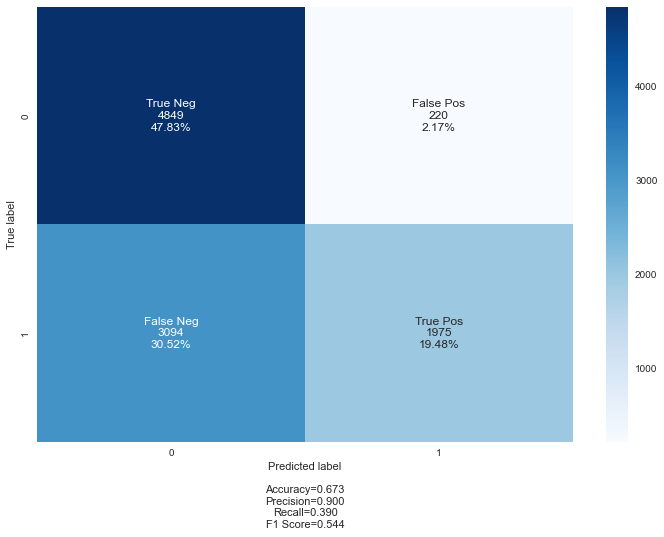

In [140]:
# Lista para armazenar todas as matrizes de confusão
all_confusion_matrices = []

# iterar por cada fold
for train_index, test_index in kf.split(X_scaled, y_resampled):
    X_train_fold, X_test_fold = X_scaled[train_index], X_scaled[test_index]
    y_train_fold, y_test_fold = y_resampled[train_index], y_resampled[test_index]
    
    # treinar o modelo
    model.fit(X_train_fold, y_train_fold)
    
    # fazer as previsões no test set
    y_pred_test_fold = model.predict(X_test_fold)
    
    # calcular a matriz de confusão
    cm_fold = metrics.confusion_matrix(y_test_fold, y_pred_test_fold)
    
    # adicionar estes fold à lista anterior
    all_confusion_matrices.append(cm_fold)

# calcular a matriz de confusão média
average_confusion_matrix = sum(all_confusion_matrices) / num_folds

labels = ['True Neg','False Pos','False Neg','True Pos']
categories = ['0', '1']

# plot com a função que criámos/adaptámos logo no início da secção de modelling (ainda com train/test split)
make_confusion_matrix(average_confusion_matrix, group_names=labels, categories=categories)

#### MLP Classifier

In [141]:
# MLP Classifier
model = MLPClassifier(hidden_layer_sizes=(100, ), activation='relu', solver='adam', alpha=0.0001, 
                      learning_rate='constant', learning_rate_init=0.05, max_iter=50, random_state=12)

# Definir o número de folds para a validação cruzada
num_folds = 10

# Criar um objeto StratifiedKFold para dividir os dados (preservando a distribuição das classes)
kf = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=123)

# Lista para armazenar os resultados de métricas de cada fold
all_results = []

# Loop sobre cada fold
for train_index, test_index in kf.split(X_scaled, y_resampled):
    X_train_fold, X_test_fold = X_scaled[train_index], X_scaled[test_index]
    y_train_fold, y_test_fold = y_resampled[train_index], y_resampled[test_index]
    
    # Treinar o modelo
    model.fit(X_train_fold, y_train_fold)
    
    # Fazer previsões no conjunto de treino e teste
    y_pred_train_fold = model.predict(X_train_fold)
    y_pred_test_fold = model.predict(X_test_fold)
    
    # Calcular as métricas de desempenho
    fold_results = performanceMetricsDF(metrics, y_train_fold, y_pred_train_fold, y_test_fold, y_pred_test_fold)
    
    # Adicionar os resultados deste fold à lista
    all_results.append(fold_results)

# Concatenar os resultados de todos os folds em um único DataFrame
final_results = pd.concat(all_results)

# Imprimir o DataFrame final com as métricas médias para todos os folds
final_results = final_results.groupby('Measure').mean()
final_results

,Train,Test
Measure,,
ACCURACY,0.674158,0.674130
F1 SCORE,0.568470,0.568716
PRECISION,0.846265,0.845969
RECALL,0.430931,0.431178


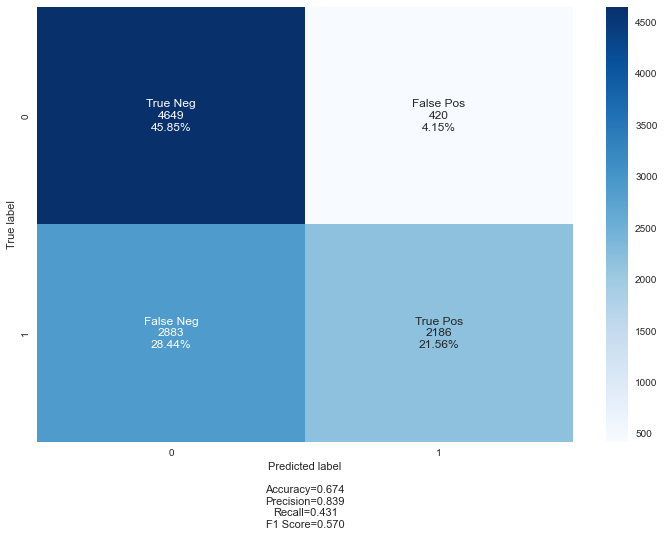

In [142]:
# Lista para armazenar todas as matrizes de confusão
all_confusion_matrices = []

# iterar por cada fold
for train_index, test_index in kf.split(X_scaled, y_resampled):
    X_train_fold, X_test_fold = X_scaled[train_index], X_scaled[test_index]
    y_train_fold, y_test_fold = y_resampled[train_index], y_resampled[test_index]
    
    # treinar o modelo
    model.fit(X_train_fold, y_train_fold)
    
    # fazer as previsões no test set
    y_pred_test_fold = model.predict(X_test_fold)
    
    # calcular a matriz de confusão
    cm_fold = metrics.confusion_matrix(y_test_fold, y_pred_test_fold)
    
    # adicionar estes fold à lista anterior
    all_confusion_matrices.append(cm_fold)

# calcular a matriz de confusão média
average_confusion_matrix = sum(all_confusion_matrices) / num_folds

labels = ['True Neg','False Pos','False Neg','True Pos']
categories = ['0', '1']

# plot com a função que criámos/adaptámos logo no início da secção de modelling (ainda com train/test split)
make_confusion_matrix(average_confusion_matrix, group_names=labels, categories=categories)

#### XGBoost

In [143]:
# XGBoost
model = xgb.XGBClassifier(objective='binary:logistic', n_estimators=200, max_depth=4, learning_rate=0.3, 
                              subsample=0.8, colsample_bytree=0.8, min_child_weight=3, random_state=100)

# Definir o número de folds para a validação cruzada
num_folds = 10

# Criar um objeto StratifiedKFold para dividir os dados (preservando a distribuição das classes)
kf = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=123)

# Lista para armazenar os resultados de métricas de cada fold
all_results = []

# Loop sobre cada fold
for train_index, test_index in kf.split(X_scaled, y_resampled):
    X_train_fold, X_test_fold = X_scaled[train_index], X_scaled[test_index]
    y_train_fold, y_test_fold = y_resampled[train_index], y_resampled[test_index]
    
    # Treinar o modelo
    model.fit(X_train_fold, y_train_fold)
    
    # Fazer previsões no conjunto de treino e teste
    y_pred_train_fold = model.predict(X_train_fold)
    y_pred_test_fold = model.predict(X_test_fold)
    
    # Calcular as métricas de desempenho
    fold_results = performanceMetricsDF(metrics, y_train_fold, y_pred_train_fold, y_test_fold, y_pred_test_fold)
    
    # Adicionar os resultados deste fold à lista
    all_results.append(fold_results)

# Concatenar os resultados de todos os folds em um único DataFrame
final_results = pd.concat(all_results)

# Imprimir o DataFrame final com as métricas médias para todos os folds
final_results = final_results.groupby('Measure').mean()
final_results

,Train,Test
Measure,,
ACCURACY,0.711157,0.692192
F1 SCORE,0.631630,0.607088
PRECISION,0.871608,0.839119
RECALL,0.495271,0.475606


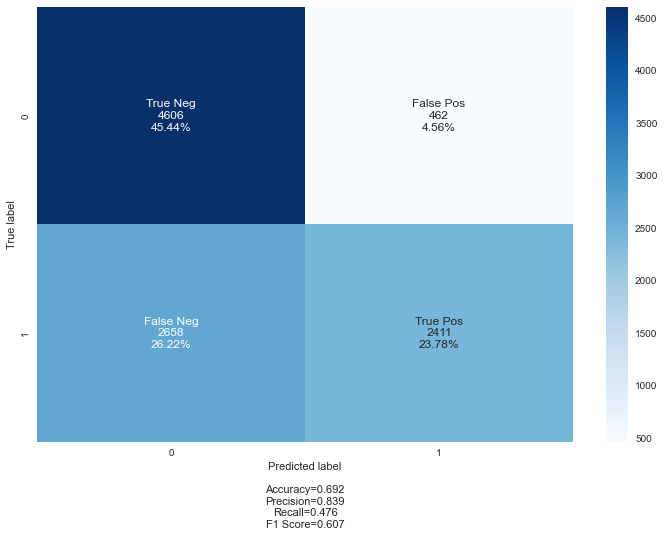

In [144]:
# Lista para armazenar todas as matrizes de confusão
all_confusion_matrices = []

# iterar por cada fold
for train_index, test_index in kf.split(X_scaled, y_resampled):
    X_train_fold, X_test_fold = X_scaled[train_index], X_scaled[test_index]
    y_train_fold, y_test_fold = y_resampled[train_index], y_resampled[test_index]
    
    # treinar o modelo
    model.fit(X_train_fold, y_train_fold)
    
    # fazer as previsões no test set
    y_pred_test_fold = model.predict(X_test_fold)
    
    # calcular a matriz de confusão
    cm_fold = metrics.confusion_matrix(y_test_fold, y_pred_test_fold)
    
    # adicionar estes fold à lista anterior
    all_confusion_matrices.append(cm_fold)

# calcular a matriz de confusão média
average_confusion_matrix = sum(all_confusion_matrices) / num_folds

labels = ['True Neg','False Pos','False Neg','True Pos']
categories = ['0', '1']

# plot com a função que criámos/adaptámos logo no início da secção de modelling (ainda com train/test split)
make_confusion_matrix(average_confusion_matrix, group_names=labels, categories=categories)

                                Feature  Importance
8                 game_round_Qualifiers    0.198107
4               game_round_Medal Rounds    0.153280
5                 game_round_Mid Rounds    0.142531
7               game_round_Early Rounds    0.103943
1                           ground_Clay    0.084398
6                     game_round_Finals    0.067332
3                         ground_Carpet    0.060875
2                          ground_Grass    0.052060
0                           ground_Hard    0.034137
14         total_home_advantage_players    0.023673
15                        forehand_comp    0.016364
13                    height_difference    0.016121
16                        backhand_comp    0.015487
9                                 prize    0.008811
17                      rank_difference    0.006270
11  diff_num_games_year_all_tournaments    0.006192
12                       age_difference    0.005316
10         head_to_head_all_tournaments    0.005103


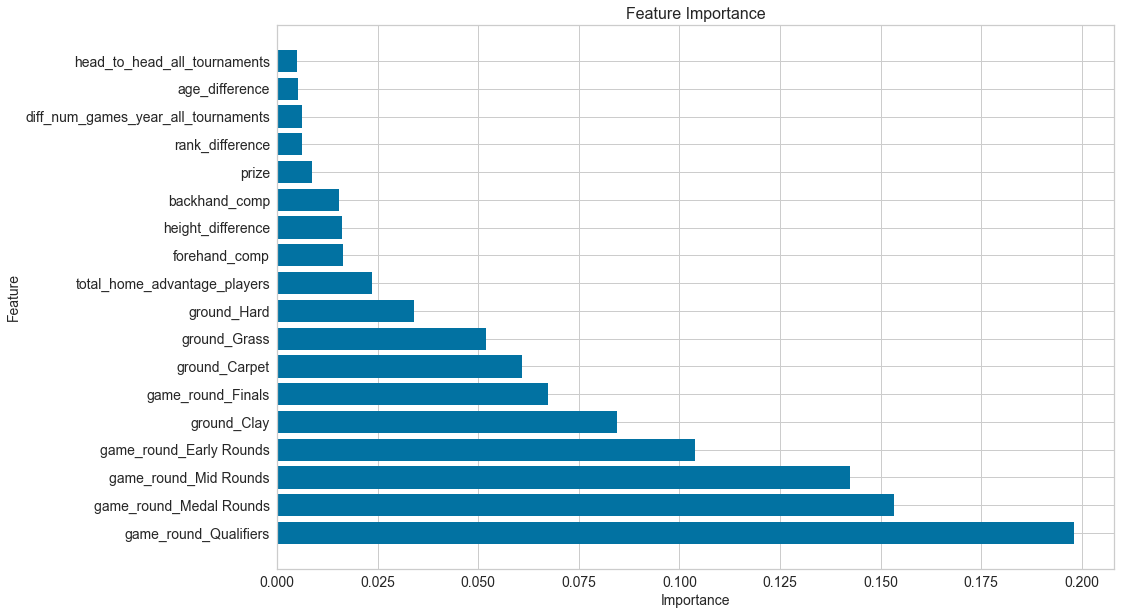

In [145]:
importances = model.feature_importances_
feature_names = X.columns

# Criar um DataFrame com os nomes das features e suas importâncias
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
})

# Ordenar as features pela importância
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Imprimir as importâncias das features
print(feature_importance_df)

# Plotar o gráfico de barras horizontais
plt.figure(figsize=(15, 10))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'])
plt.xlabel('Importance', fontsize=14)
plt.ylabel('Feature', fontsize=14)
plt.title('Feature Importance', fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

#### Random Forest

In [146]:
model = RandomForestClassifier(max_depth=8, min_samples_split=2, n_estimators=100, random_state=100)

# Definir o número de folds para a validação cruzada
num_folds = 10

# Criar um objeto StratifiedKFold para dividir os dados (preservando a distribuição das classes)
kf = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=123)

# Lista para armazenar os resultados de métricas de cada fold
all_results = []

# Loop sobre cada fold
for train_index, test_index in kf.split(X_scaled, y_resampled):
    X_train_fold, X_test_fold = X_scaled[train_index], X_scaled[test_index]
    y_train_fold, y_test_fold = y_resampled[train_index], y_resampled[test_index]
    
    # Treinar o modelo
    model.fit(X_train_fold, y_train_fold)
    
    # Fazer previsões no conjunto de treino e teste
    y_pred_train_fold = model.predict(X_train_fold)
    y_pred_test_fold = model.predict(X_test_fold)
    
    # Calcular as métricas de desempenho
    fold_results = performanceMetricsDF(metrics, y_train_fold, y_pred_train_fold, y_test_fold, y_pred_test_fold)
    
    # Adicionar os resultados deste fold à lista
    all_results.append(fold_results)

# Concatenar os resultados de todos os folds em um único DataFrame
final_results = pd.concat(all_results)

# Imprimir o DataFrame final com as métricas médias para todos os folds
final_results = final_results.groupby('Measure').mean()
final_results

,Train,Test
Measure,,
ACCURACY,0.676933,0.667393
F1 SCORE,0.602478,0.590827
PRECISION,0.782961,0.767542
RECALL,0.489644,0.480321


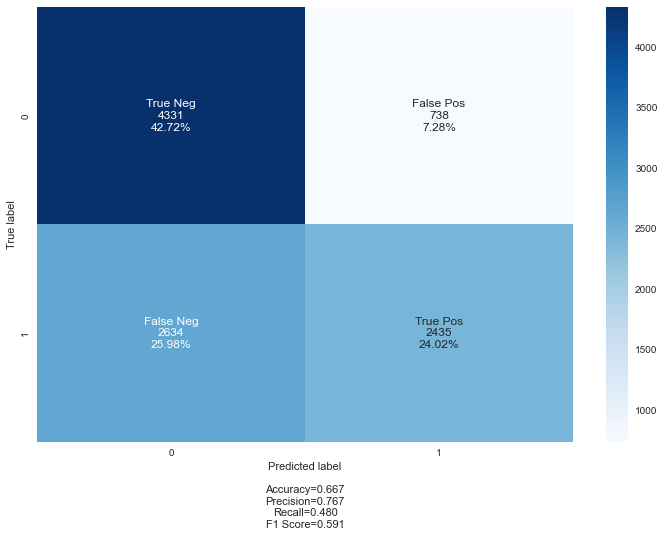

In [147]:
# Lista para armazenar todas as matrizes de confusão
all_confusion_matrices = []

# iterar por cada fold
for train_index, test_index in kf.split(X_scaled, y_resampled):
    X_train_fold, X_test_fold = X_scaled[train_index], X_scaled[test_index]
    y_train_fold, y_test_fold = y_resampled[train_index], y_resampled[test_index]
    
    # treinar o modelo
    model.fit(X_train_fold, y_train_fold)
    
    # fazer as previsões no test set
    y_pred_test_fold = model.predict(X_test_fold)
    
    # calcular a matriz de confusão
    cm_fold = metrics.confusion_matrix(y_test_fold, y_pred_test_fold)
    
    # adicionar estes fold à lista anterior
    all_confusion_matrices.append(cm_fold)

# calcular a matriz de confusão média
average_confusion_matrix = sum(all_confusion_matrices) / num_folds

labels = ['True Neg','False Pos','False Neg','True Pos']
categories = ['0', '1']

# plot com a função que criámos/adaptámos logo no início da secção de modelling (ainda com train/test split)
make_confusion_matrix(average_confusion_matrix, group_names=labels, categories=categories)

### CV com undersampling

In [148]:
# Função utilizada para criar o dataset com as métricas
# Definir o target
y = df_other_tournaments_us['number_of_sets']

# Remover o target do conjunto de dados
X = df_other_tournaments_us.drop(['number_of_sets'], axis=1)

# Aplicar undersampling para balancear o conjunto de dados
undersampler = RandomUnderSampler(random_state=123)
X_resampled, y_resampled = undersampler.fit_resample(X, y)

# Normalizar os dados com MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
X_scaled = scaler.fit_transform(X_resampled)

#### Logistic Regression

In [149]:
# MVM
model = LogisticRegression(C=0.1, penalty='l2', solver='liblinear', random_state=12)

# Definir o número de folds para a validação cruzada
num_folds = 10

# Criar um objeto StratifiedKFold para dividir os dados (preservando a distribuição das classes)
kf = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=123)

# Lista para armazenar os resultados de métricas de cada fold
all_results = []

# Loop sobre cada fold
for train_index, test_index in kf.split(X_scaled, y_resampled):
    X_train_fold, X_test_fold = X_scaled[train_index], X_scaled[test_index]
    y_train_fold, y_test_fold = y_resampled.iloc[train_index], y_resampled.iloc[test_index]
    
    # Treinar o modelo
    model.fit(X_train_fold, y_train_fold)
    
    # Fazer previsões no conjunto de treino e teste
    y_pred_train_fold = model.predict(X_train_fold)
    y_pred_test_fold = model.predict(X_test_fold)
    
    # Calcular as métricas de desempenho
    fold_results = performanceMetricsDF(metrics, y_train_fold, y_pred_train_fold, y_test_fold, y_pred_test_fold)
    
    # Adicionar os resultados deste fold à lista
    all_results.append(fold_results)

# Concatenar os resultados de todos os folds em um único DataFrame
final_results = pd.concat(all_results)

# Imprimir o DataFrame final com as métricas médias para todos os folds
final_results = final_results.groupby('Measure').mean()
final_results


,Train,Test
Measure,,
ACCURACY,0.531161,0.530704
F1 SCORE,0.556890,0.556113
PRECISION,0.527917,0.527570
RECALL,0.589240,0.587997


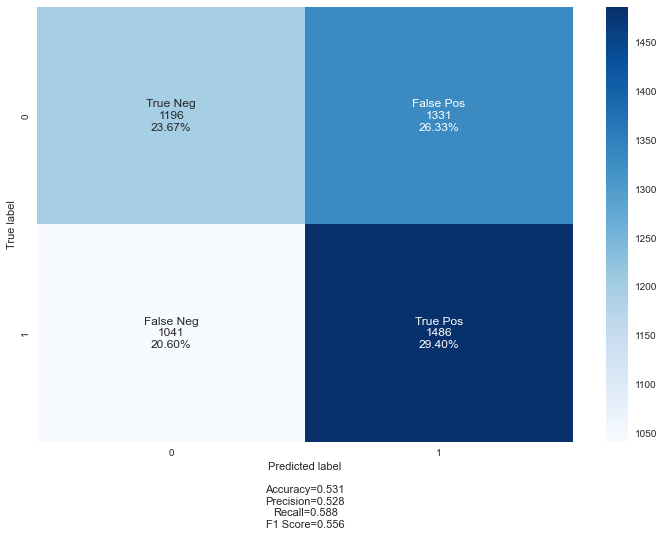

In [150]:
# Lista para armazenar todas as matrizes de confusão
all_confusion_matrices = []

# iterar por cada fold
for train_index, test_index in kf.split(X_scaled, y_resampled):
    X_train_fold, X_test_fold = X_scaled[train_index], X_scaled[test_index]
    y_train_fold, y_test_fold = y_resampled.iloc[train_index], y_resampled.iloc[test_index]
    
    # treinar o modelo
    model.fit(X_train_fold, y_train_fold)
    
    # fazer as previsões no test set
    y_pred_test_fold = model.predict(X_test_fold)
    
    # calcular a matriz de confusão
    cm_fold = metrics.confusion_matrix(y_test_fold, y_pred_test_fold)
    
    # adicionar estes fold à lista anterior
    all_confusion_matrices.append(cm_fold)

# calcular a matriz de confusão média
average_confusion_matrix = sum(all_confusion_matrices) / num_folds

labels = ['True Neg','False Pos','False Neg','True Pos']
categories = ['0', '1']

# plot com a função que criámos/adaptámos logo no início da secção de modelling (ainda com train/test split)
make_confusion_matrix(average_confusion_matrix, group_names=labels, categories=categories)

#### MLP

In [151]:
model = MLPClassifier(hidden_layer_sizes=(100, ), activation='relu', solver='adam', alpha=0.0001, 
                      learning_rate='constant', learning_rate_init=0.05, max_iter=50, random_state=12)

# Definir o número de folds para a validação cruzada
num_folds = 10

# Criar um objeto StratifiedKFold para dividir os dados (preservando a distribuição das classes)
kf = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=123)

# Lista para armazenar os resultados de métricas de cada fold
all_results = []

# Loop sobre cada fold
for train_index, test_index in kf.split(X_scaled, y_resampled):
    X_train_fold, X_test_fold = X_scaled[train_index], X_scaled[test_index]
    y_train_fold, y_test_fold = y_resampled.iloc[train_index], y_resampled.iloc[test_index]
    
    # Treinar o modelo
    model.fit(X_train_fold, y_train_fold)
    
    # Fazer previsões no conjunto de treino e teste
    y_pred_train_fold = model.predict(X_train_fold)
    y_pred_test_fold = model.predict(X_test_fold)
    
    # Calcular as métricas de desempenho
    fold_results = performanceMetricsDF(metrics, y_train_fold, y_pred_train_fold, y_test_fold, y_pred_test_fold)
    
    # Adicionar os resultados deste fold à lista
    all_results.append(fold_results)

# Concatenar os resultados de todos os folds em um único DataFrame
final_results = pd.concat(all_results)

# Imprimir o DataFrame final com as métricas médias para todos os folds
final_results = final_results.groupby('Measure').mean()
final_results

,Train,Test
Measure,,
ACCURACY,0.521287,0.517132
F1 SCORE,0.501996,0.497674
PRECISION,0.558654,0.517493
RECALL,0.646231,0.640560


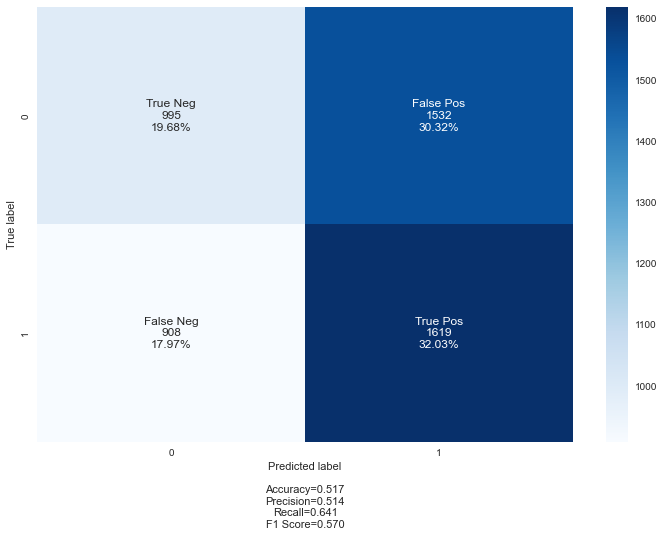

In [152]:
# Lista para armazenar todas as matrizes de confusão
all_confusion_matrices = []

# iterar por cada fold
for train_index, test_index in kf.split(X_scaled, y_resampled):
    X_train_fold, X_test_fold = X_scaled[train_index], X_scaled[test_index]
    y_train_fold, y_test_fold = y_resampled.iloc[train_index], y_resampled.iloc[test_index]
    
    # treinar o modelo
    model.fit(X_train_fold, y_train_fold)
    
    # fazer as previsões no test set
    y_pred_test_fold = model.predict(X_test_fold)
    
    # calcular a matriz de confusão
    cm_fold = metrics.confusion_matrix(y_test_fold, y_pred_test_fold)
    
    # adicionar estes fold à lista anterior
    all_confusion_matrices.append(cm_fold)

# calcular a matriz de confusão média
average_confusion_matrix = sum(all_confusion_matrices) / num_folds

labels = ['True Neg','False Pos','False Neg','True Pos']
categories = ['0', '1']

# plot com a função que criámos/adaptámos logo no início da secção de modelling (ainda com train/test split)
make_confusion_matrix(average_confusion_matrix, group_names=labels, categories=categories)

#### XGBoost

In [153]:
model = xgb.XGBClassifier(objective='binary:logistic', n_estimators=200, max_depth=4, learning_rate=0.3, 
                              subsample=0.8, colsample_bytree=0.8, min_child_weight=3, random_state=100)

# Definir o número de folds para a validação cruzada
num_folds = 10

# Criar um objeto StratifiedKFold para dividir os dados (preservando a distribuição das classes)
kf = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=123)

# Lista para armazenar os resultados de métricas de cada fold
all_results = []

# Loop sobre cada fold
for train_index, test_index in kf.split(X_scaled, y_resampled):
    X_train_fold, X_test_fold = X_scaled[train_index], X_scaled[test_index]
    y_train_fold, y_test_fold = y_resampled.iloc[train_index], y_resampled.iloc[test_index]
    
    # Treinar o modelo
    model.fit(X_train_fold, y_train_fold)
    
    # Fazer previsões no conjunto de treino e teste
    y_pred_train_fold = model.predict(X_train_fold)
    y_pred_test_fold = model.predict(X_test_fold)
    
    # Calcular as métricas de desempenho
    fold_results = performanceMetricsDF(metrics, y_train_fold, y_pred_train_fold, y_test_fold, y_pred_test_fold)
    
    # Adicionar os resultados deste fold à lista
    all_results.append(fold_results)

# Concatenar os resultados de todos os folds em um único DataFrame
final_results = pd.concat(all_results)

# Imprimir o DataFrame final com as métricas médias para todos os folds
final_results = final_results.groupby('Measure').mean()
final_results

,Train,Test
Measure,,
ACCURACY,0.620315,0.526450
F1 SCORE,0.631432,0.540485
PRECISION,0.613480,0.524970
RECALL,0.650497,0.557016


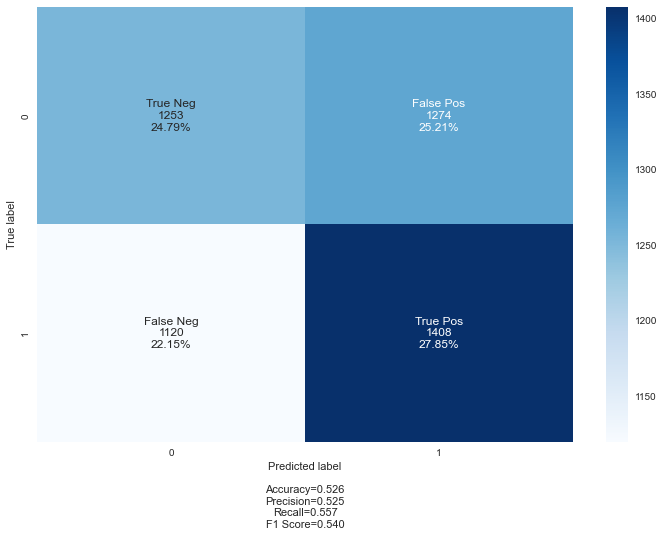

In [154]:
# Lista para armazenar todas as matrizes de confusão
all_confusion_matrices = []

# iterar por cada fold
for train_index, test_index in kf.split(X_scaled, y_resampled):
    X_train_fold, X_test_fold = X_scaled[train_index], X_scaled[test_index]
    y_train_fold, y_test_fold = y_resampled.iloc[train_index], y_resampled.iloc[test_index]
    
    # treinar o modelo
    model.fit(X_train_fold, y_train_fold)
    
    # fazer as previsões no test set
    y_pred_test_fold = model.predict(X_test_fold)
    
    # calcular a matriz de confusão
    cm_fold = metrics.confusion_matrix(y_test_fold, y_pred_test_fold)
    
    # adicionar estes fold à lista anterior
    all_confusion_matrices.append(cm_fold)

# calcular a matriz de confusão média
average_confusion_matrix = sum(all_confusion_matrices) / num_folds

labels = ['True Neg','False Pos','False Neg','True Pos']
categories = ['0', '1']

# plot com a função que criámos/adaptámos logo no início da secção de modelling (ainda com train/test split)
make_confusion_matrix(average_confusion_matrix, group_names=labels, categories=categories)

#### Random Forest

In [155]:
model = RandomForestClassifier(max_depth=8, min_samples_split=2, n_estimators=100, random_state=100)

# Definir o número de folds para a validação cruzada
num_folds = 10

# Criar um objeto StratifiedKFold para dividir os dados (preservando a distribuição das classes)
kf = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=123)

# Lista para armazenar os resultados de métricas de cada fold
all_results = []

# Loop sobre cada fold
for train_index, test_index in kf.split(X_scaled, y_resampled):
    X_train_fold, X_test_fold = X_scaled[train_index], X_scaled[test_index]
    y_train_fold, y_test_fold = y_resampled.iloc[train_index], y_resampled.iloc[test_index]
    
    # Treinar o modelo
    model.fit(X_train_fold, y_train_fold)
    
    # Fazer previsões no conjunto de treino e teste
    y_pred_train_fold = model.predict(X_train_fold)
    y_pred_test_fold = model.predict(X_test_fold)
    
    # Calcular as métricas de desempenho
    fold_results = performanceMetricsDF(metrics, y_train_fold, y_pred_train_fold, y_test_fold, y_pred_test_fold)
    
    # Adicionar os resultados deste fold à lista
    all_results.append(fold_results)

# Concatenar os resultados de todos os folds em um único DataFrame
final_results = pd.concat(all_results)

# Imprimir o DataFrame final com as métricas médias para todos os folds
final_results = final_results.groupby('Measure').mean()
final_results

,Train,Test
Measure,,
ACCURACY,0.582034,0.533790
F1 SCORE,0.620958,0.576692
PRECISION,0.568081,0.528083
RECALL,0.684793,0.635238


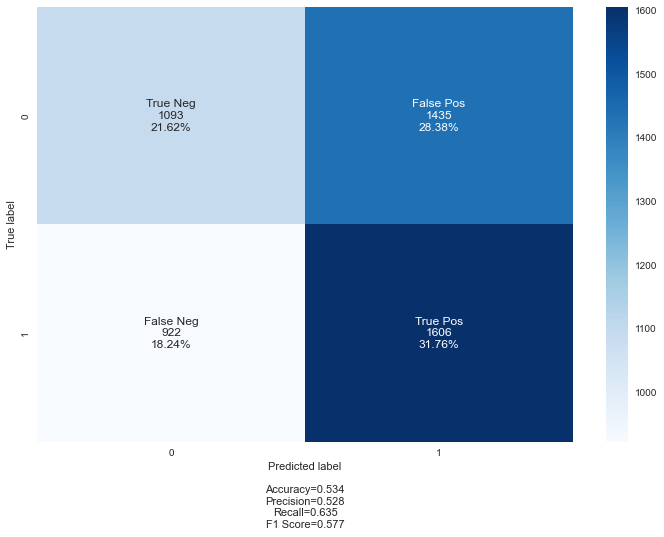

In [156]:
# Lista para armazenar todas as matrizes de confusão
all_confusion_matrices = []

# iterar por cada fold
for train_index, test_index in kf.split(X_scaled, y_resampled):
    X_train_fold, X_test_fold = X_scaled[train_index], X_scaled[test_index]
    y_train_fold, y_test_fold = y_resampled.iloc[train_index], y_resampled.iloc[test_index]
    
    # treinar o modelo
    model.fit(X_train_fold, y_train_fold)
    
    # fazer as previsões no test set
    y_pred_test_fold = model.predict(X_test_fold)
    
    # calcular a matriz de confusão
    cm_fold = metrics.confusion_matrix(y_test_fold, y_pred_test_fold)
    
    # adicionar estes fold à lista anterior
    all_confusion_matrices.append(cm_fold)

# calcular a matriz de confusão média
average_confusion_matrix = sum(all_confusion_matrices) / num_folds

labels = ['True Neg','False Pos','False Neg','True Pos']
categories = ['0', '1']

# plot com a função que criámos/adaptámos logo no início da secção de modelling (ainda com train/test split)
make_confusion_matrix(average_confusion_matrix, group_names=labels, categories=categories)